In [1]:
import re

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

import dask_geopandas
from collections import OrderedDict
import geopandas as gpd

import s3fs
import base64
import json
import os
import requests
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm
import netCDF4 as nc
from dotenv import load_dotenv
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [152]:
import pyspark

# 1. Setting up Spark

In [2]:
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import lit


# # spark = SparkSession.builder.getOrCreate()

# # only use 4 corea
# # spark = SparkSession.builder.master("local[4]").getOrCreate()


import os, sys
# point Spark’s Python to the same interpreter you’re running now
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("example") \
    .getOrCreate()


In [3]:
spark

In [4]:
spark.sparkContext.defaultParallelism

12

In [5]:
# spark.stop()

# 2. Preparing NO2 Data

For NO2 data, I will be using OMI NO2 from NASA. This dataset is daily-level ar roughly 0.1deg * 0.1deg resolution. OMI instrument present in a satellite orbits the Earth 14 to 15 times a day and calculate NO2 vertical column density. Vertical Column Density or VCD refers to the total amount of NO2 molecules present from earth surface to the top of the atmosphere. NO2 pollution would be in tons that can be calculated from surface concentrations (NO2 molecules present on earth surface). This can be done using ground based sensors from EPA or PANDORA. 

Even though the data I am using is vertical columns, it still is a very good indicator of NO2 pollution. It is satellite-based data, which means we can do global-level data analysis and evaluation. Besides, the presence of sensors is very scarce and it is not possible to place ground-based sensors throughout the world. That's where satellite-based evaluation come in handy.

<b> Higher OMI NO2 VCD indicates more NO2 emissions from burning of fuel (cars), industries, etc. Furthermore, NO2 irritates the airways in our lungs and nose, causing inflammation and swelling, and is one of the top pollutants to cause respiratory disease like Asthma</b>

I wil be using `OMI_MINDS_NO2` dataset from NASA. You can find more about it from the following link: https://disc.gsfc.nasa.gov/datasets/OMI_MINDS_NO2_1.1/summary?keywords=OMI_MINDS_NO2_1.1


This data is also available on S3. I will be reading the files directly from S3. 

In [8]:
load_dotenv()

True

In [9]:
'''
This is how we can fetch temporary credentials from NASA's Earthdata to access AWS S3 bucket.
These expire after 1 hour. And, you need an active earthdata account to get the credentials.
This code is present on NASA's website:

https://archive.podaac.earthdata.nasa.gov/s3credentialsREADME
'''

s3_endpoint = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"
username = os.getenv("EARTHDATA_USERNAME")
password = os.getenv("EARTHDATA_PASSWORD")


login_resp = requests.get(s3_endpoint, allow_redirects=False)
login_resp.raise_for_status()

auth = f"{username}:{password}"
encoded_auth = base64.b64encode(auth.encode('ascii'))

auth_redirect = requests.post(
    login_resp.headers['location'],
    data={"credentials": encoded_auth},
    headers={"Origin": s3_endpoint},
    allow_redirects=False
)
auth_redirect.raise_for_status()

final = requests.get(auth_redirect.headers['location'], allow_redirects=False)
final.raise_for_status()

results = requests.get(s3_endpoint, cookies={'accessToken': final.cookies['accessToken']})
results.raise_for_status()

creds = json.loads(results.content)

In [10]:
# creating s3fs object to access the bucket using the retrieved temporaty credentials
s3_fs = s3fs.S3FileSystem(
        key = creds['accessKeyId'],
        secret = creds['secretAccessKey'],
        token = creds['sessionToken'],
    )

In [11]:
'''
The name of the S3 bucket that contains OMI NO2 data is gesdisc-cumulus-prod-protected.
Let's quickly test if we can connect to the bucket or not.
'''

try:
    files = s3_fs.ls("s3://gesdisc-cumulus-prod-protected")
    print("Connection successful! Files found:")
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful! Files found:


We have set up our s3fs object and connected it to NASA's s3 bucket. Next thing will be to go on the NASA GESC DISC website and get the text file containing links to the s3 files for OMI NO2 from 2018 to 2022. The data is present inside `gesdisc-cumulus-prod-protected` bucket.

We can directly stream the data object into our RAM using `Xarray` python library. 

In [12]:
''''
These are the S3 links to OMI NO2 data files from year 2018 to 2022. I got this from NASA's GESC DISC.
You can get these links from the following URL:

https://disc.gsfc.nasa.gov/datasets/OMI_MINDS_NO2_1.1/summary?keywords=OMI_MINDS_NO2_1.1
'''

with open("OMI_NO2_S3_Links.txt", "r") as file:
    omi_no2_links = file.readlines()

omi_no2_links = [line.strip() for line in omi_no2_links]
omi_no2_links = [link for link in omi_no2_links if link.endswith(".nc")]
print("TOTAL NUMBER OF FILES IS: ", len(omi_no2_links))
omi_no2_links[:10]

TOTAL NUMBER OF FILES IS:  9196


['s3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2022/365/OMI-Aura_L2-OMI_MINDS_NO2_2022m1231t2250-o098205_v01-01-2023m0223t193712.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t0029-o098206_v01-01-2023m0223t193641.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t1201-o098213_v01-01-2023m0223t193846.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t1340-o098214_v01-01-2023m0223t193853.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t1519-o098215_v01-01-2023m0223t193844.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t1658-o098216_v01-01-2023m0223t193916.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101

Each file is roughly ~10mb in size (some can be larger and some can be smaller). With 23084 files, the total data size that we will be streaming will be ~250 GB. However, these files contain global data and we will filter data only for the US bounding cordinates. 

In [13]:
def is_over_us_state(lat: np.array, lon: np.array):
    """Returns True if (lat, lon) is inside any of the 50 US states (excluding territories)."""
    
    # Continental U.S. (CON 48 states)
    conus = (
        (24.5 <= lat <= 49.5) &  
        (-125.0 <= lon <= -66.95)  
    )
    
    # Alaska 
    alaska = (
        (51.0 <= lat <= 71.4) &  
        ((-170.0 <= lon <= -129.9)) 
    )
    
    # Hawaii
    hawaii = (
        (17.9 <= lat <= 26) &  
        (-162.0 <= lon <= -154.5)  
    )
    
    return conus | alaska | hawaii


In [9]:
global_latitude = []
global_longitude = []
global_ColumnAmountNO2 = []
global_cloudFraction = []
global_LAT1 = []
global_LAT2 = []
global_LAT3 = []
global_LAT4 = []
global_LON1 = []
global_LON2 = []
global_LON3 = []
global_LON4 = []
global_date = []

for current_file in tqdm(omi_no2_links[:30]):
    with s3_fs.open(current_file, mode="rb") as f:
        dataset = nc.Dataset("in-memory.nc", memory=f.read())

    filename = os.path.basename(current_file)
    date = filename.split("OMI-Aura_L2-OMI_MINDS_NO2_")[1][:9]
    ColumnAmountNO2 = dataset.groups["SCIENCE_DATA"]["ColumnAmountNO2"][:].filled(np.nan).reshape(-1)
    cloudFraction = dataset.groups["ANCILLARY_DATA"]["CloudFraction"][:].filled(np.nan).reshape(-1)
    latitude = dataset.groups["GEOLOCATION_DATA"]["Latitude"][:].filled(np.nan).reshape(-1)
    longitude = dataset.groups["GEOLOCATION_DATA"]["Longitude"][:].filled(np.nan).reshape(-1)
    corner_latitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLatitude"][:].reshape(-1, 4)
    corner_longitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLongitude"][:].reshape(-1, 4)
    LAT1 = corner_latitude[:, 0]
    LAT2 = corner_latitude[:, 1]
    LAT3 = corner_latitude[:, 2]
    LAT4 = corner_latitude[:, 3]
    LON1 = corner_longitude[:, 0]
    LON2 = corner_longitude[:, 1]
    LON3 = corner_longitude[:, 2]
    LON4 = corner_longitude[:, 3]
    date = np.repeat(date, ColumnAmountNO2.shape[0])

    boolean_mask = np.array([is_over_us_state(lat, lon) for lat, lon in zip(latitude, longitude)])

    ColumnAmountNO2 = ColumnAmountNO2[boolean_mask]
    cloudFraction = cloudFraction[boolean_mask]
    latitude = latitude[boolean_mask]
    longitude = longitude[boolean_mask]
    LAT1 = LAT1[boolean_mask]
    LAT2 = LAT2[boolean_mask]
    LAT3 = LAT3[boolean_mask]
    LAT4 = LAT4[boolean_mask]
    LON1 = LON1[boolean_mask]
    LON2 = LON2[boolean_mask]
    LON3 = LON3[boolean_mask]
    LON4 = LON4[boolean_mask]
    date = date[boolean_mask]

    global_latitude.extend(latitude)
    global_longitude.extend(longitude)
    global_ColumnAmountNO2.extend(ColumnAmountNO2)
    global_cloudFraction.extend(cloudFraction)
    global_LAT1.extend(LAT1)
    global_LAT2.extend(LAT2)
    global_LAT3.extend(LAT3)
    global_LAT4.extend(LAT4)
    global_LON1.extend(LON1)
    global_LON2.extend(LON2)
    global_LON3.extend(LON3)
    global_LON4.extend(LON4)
    global_date.extend(date)

    dataset.close()

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:11<00:00,  2.52it/s]


In [10]:
global_latitude = np.array(global_latitude)
global_longitude = np.array(global_longitude)
global_ColumnAmountNO2 = np.array(global_ColumnAmountNO2)
global_cloudFraction = np.array(global_cloudFraction)
global_LAT1 = np.array(global_LAT1)
global_LAT2 = np.array(global_LAT2)
global_LAT3 = np.array(global_LAT3)
global_LAT4 = np.array(global_LAT4)
global_LON1 = np.array(global_LON1)
global_LON2 = np.array(global_LON2)
global_LON3 = np.array(global_LON3)
global_LON4 = np.array(global_LON4)
global_date = np.array(global_date)

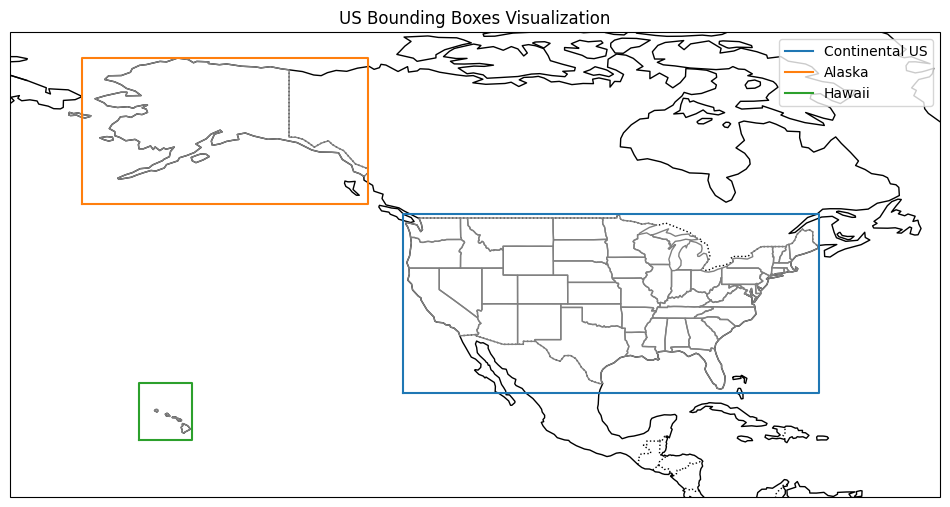

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-180, -50, 10, 75], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='gray')

bounding_boxes = {
    "Continental US": [[24.5, 49.5], [-125.0, -66.95]],
    "Alaska": [[51.0, 71.4], [-170.0, -129.9]], 
    "Hawaii": [[17.9, 26], [-162.0, -154.5]]
}

for region, ((lat_min, lat_max), (lon_min, lon_max)) in bounding_boxes.items():
    lats = [lat_min, lat_max, lat_max, lat_min, lat_min]
    lons = [lon_min, lon_min, lon_max, lon_max, lon_min]
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), label=region)

ax.legend()
plt.title("US Bounding Boxes Visualization")
plt.show()


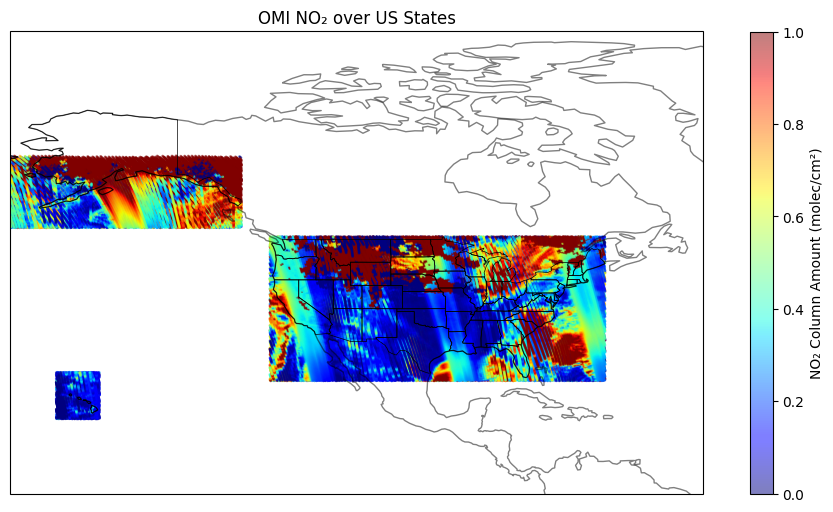

In [12]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-170, -50, 5, 85], crs=ccrs.PlateCarree()) 
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, alpha=0.5)
scatter = ax.scatter(global_longitude, global_latitude, c=global_cloudFraction, s=1, cmap='jet', transform=ccrs.PlateCarree(), alpha=0.5)
plt.colorbar(scatter, label='NO₂ Column Amount (molec/cm²)', orientation='vertical')
plt.title('OMI NO₂ over US States')
plt.show()

Perfect. Our bounding box and data filtration logic is valid. Lets process data files one month at a time and export them to not run out of memory.

In [8]:
import random

random.sample(omi_no2_links, 10)

['s3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/042/OMI-Aura_L2-OMI_MINDS_NO2_2020m0211t1604-o082852_v01-01-2022m0210t053236.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/038/OMI-Aura_L2-OMI_MINDS_NO2_2020m0207t1131-o082791_v01-01-2022m0210t052904.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2021/207/OMI-Aura_L2-OMI_MINDS_NO2_2021m0726t1505-o090584_v01-01-2022m0210t121032.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2021/306/OMI-Aura_L2-OMI_MINDS_NO2_2021m1102t2202-o092030_v01-01-2022m0210t134302.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2019/111/OMI-Aura_L2-OMI_MINDS_NO2_2019m0421t1205-o078539_v01-01-2022m0210t024711.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/132/OMI-Aura_L2-OMI_MINDS_NO2_2020m0511t1830-o084164_v01-01-2022m0210t062259.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/290/OMI-Aura_L2-OMI_MINDS_NO2_2018m1017

In [14]:

def get_s3links_for_selected_date(year: str, month:str) -> list[str]:
    """
    Get the S3 links for a specific year and month.
    """
    month_str = f"{int(month):02d}"
    pattern = re.compile(rf'.*OMI_MINDS_NO2_{year}m{month_str}\d{{2}}t\d{{4}}.*\.nc$')
    files = sorted([file for file in omi_no2_links if pattern.search(file)])
    return files

In [15]:
def process_data_monthly(year: str, month: str):
    '''
    Read the OMI NO2 data files for a specific month and year from S3 bucket and export it.
    '''
    try:
        omi_no2_links_for_selected_YYYYMM = get_s3links_for_selected_date(year, month)
        
        dfs = []

        for current_file in tqdm(omi_no2_links_for_selected_YYYYMM):
            try:
                with s3_fs.open(current_file, mode="rb") as f:
                    with nc.Dataset("in-memory.nc", memory=f.read()) as dataset:
                        filename = os.path.basename(current_file)
                        date = filename.split("OMI-Aura_L2-OMI_MINDS_NO2_")[1][:9]
                        
                        # Extract data
                        ColumnAmountNO2 = dataset.groups["SCIENCE_DATA"]["ColumnAmountNO2"][:].filled(np.nan).reshape(-1)
                        cloudFraction = dataset.groups["ANCILLARY_DATA"]["CloudFraction"][:].filled(np.nan).reshape(-1)
                        latitude = dataset.groups["GEOLOCATION_DATA"]["Latitude"][:].filled(np.nan).reshape(-1)
                        longitude = dataset.groups["GEOLOCATION_DATA"]["Longitude"][:].filled(np.nan).reshape(-1)
                        corner_latitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLatitude"][:].reshape(-1, 4)
                        corner_longitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLongitude"][:].reshape(-1, 4)
                        
                        # Create boolean mask
                        boolean_mask = np.array([is_over_us_state(lat, lon) for lat, lon in zip(latitude, longitude)])
                        
                        # Filter data
                        filtered_data = {
                            "latitude": latitude[boolean_mask],
                            "longitude": longitude[boolean_mask],
                            "ColumnAmountNO2": ColumnAmountNO2[boolean_mask],
                            "cloudFraction": cloudFraction[boolean_mask],
                            "LAT1": corner_latitude[:, 0][boolean_mask],
                            "LAT2": corner_latitude[:, 1][boolean_mask],
                            "LAT3": corner_latitude[:, 2][boolean_mask],
                            "LAT4": corner_latitude[:, 3][boolean_mask],
                            "LON1": corner_longitude[:, 0][boolean_mask],
                            "LON2": corner_longitude[:, 1][boolean_mask],
                            "LON3": corner_longitude[:, 2][boolean_mask],
                            "LON4": corner_longitude[:, 3][boolean_mask],
                            "date": np.repeat(date, np.sum(boolean_mask))
                        }
                        
                        dfs.append(pd.DataFrame(filtered_data))
            
            except Exception as e:
                print(f"Error processing file {current_file}: {str(e)}")
                continue

        if dfs:
            final_df = pd.concat(dfs, ignore_index=True)
            output_path = f"omi_no2_data_{year}_{month}.parquet"
            final_df.dropna(inplace=True)
            final_df.reset_index(drop=True, inplace=True)
            final_df.to_parquet(output_path)
        else:
            print("No valid data processed for the given month.")

        return True 
    except Exception as e:
        print(f"Error processing data for {year}-{month}: {str(e)}")
        return False

In [16]:
from joblib import Parallel, delayed

It is taking roughly 3 minutes to process one month of data. Therefore, I will utilize joblib to parallize this process. This way, I can process data for multiple months simultaneously to reduce the total processing time. Each daily file is ~10 MB and reading though them, filtering exporting month file takes some time. Each exported monthly file is ~30MB.

In [17]:
def proces_data_in_parallel(year_selected: str, num_cores= 6):
    """
    This function will process multiple months in parallel for a given year
    """
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    Parallel(n_jobs=num_cores)(delayed(process_data_monthly)(year, month) for year in [year_selected] for month in months)

In [ ]:
proces_data_in_parallel("2018")
proces_data_in_parallel("2019")
proces_data_in_parallel("2020")

In [13]:
proces_data_in_parallel("2020")

100%|██████████| 414/414 [04:32<00:00,  1.52it/s]


In [14]:
proces_data_in_parallel("2021")

100%|██████████| 432/432 [04:38<00:00,  1.55it/s]


In [15]:
proces_data_in_parallel("2022")

100%|██████████| 409/409 [03:55<00:00,  1.73it/s]


In [18]:
proces_data_in_parallel("2023")

100%|██████████| 428/428 [04:22<00:00,  1.63it/s]


In [19]:
proces_data_in_parallel("2024")

100%|██████████| 416/416 [04:50<00:00,  1.43it/s]


# 3. NO2 Pollution Analysis

In [6]:
files_path = "Data/NO2/Single_Files"
files = os.listdir(files_path)
files = [os.path.join(files_path, file) for file in files if file.endswith(".parquet")]
files = sorted(files)

In [7]:
len(files), files[0], files[-1]

(84,
 'Data/NO2/Single_Files\\omi_no2_data_2018_01.parquet',
 'Data/NO2/Single_Files\\omi_no2_data_2024_12.parquet')

If we look here, each parquet file is the NO2 data for US for each month (daily of course). We will read each parquet file into spark data frame and concat them.

In [8]:
no2_df = spark.read.parquet(files[0])

In [9]:
no2_df.show(10)

+---------+----------+---------------+------------------+-------+-------+-------+-------+--------+--------+--------+--------+---------+
| latitude| longitude|ColumnAmountNO2|     cloudFraction|   LAT1|   LAT2|   LAT3|   LAT4|    LON1|    LON2|    LON3|    LON4|     date|
+---------+----------+---------------+------------------+-------+-------+-------+-------+--------+--------+--------+--------+---------+
| 40.26102|  -66.9704|  2.14097046E15|             0.706|39.8134|40.4608|40.6886|40.0696|-67.7036|-66.0866|-66.2213|-67.8613|2018m0101|
| 40.37128| -67.03718|  2.49873493E15|             0.737|39.9231|40.5719|40.7996|40.1791|-67.7709|-66.1521|-66.2873|-67.9292|2018m0101|
|40.481525|-67.104126|  2.08931852E15|             0.739|40.0328|40.6829|40.9105|40.2886|-67.8385|-66.2179|-66.3535|-67.9971|2018m0101|
|40.591774| -67.17118|  1.86005531E15|             0.717|40.1422|40.7938|41.0213| 40.398|-67.9063|-66.2838|-66.4199|-68.0655|2018m0101|
|  40.7019|-67.238594|  2.01618274E15|0.69600000

Here, latitude, longitude and their corner cordinates are geographical information that can be used to perform spatial analysis. ColumnAmountNO2 is the OMI NO2 vertical column density whereas cloudFraction refers to the percentage/fraction of sky covered with clouds at the specific cordinates. If the value of cloud fraction is large, the OMI instrument's NO2 column values will not be accurate as cloud reflects sunlight and the measurement become inaacurate. Therefore, we will later only use data where cloud fraction is less than 0.5. The higher the threshold we set, the more data we loose. 

In [10]:
no2_df

DataFrame[latitude: float, longitude: float, ColumnAmountNO2: float, cloudFraction: double, LAT1: float, LAT2: float, LAT3: float, LAT4: float, LON1: float, LON2: float, LON3: float, LON4: float, date: string]

<span style="color:red">
Spark DataFrames do not support Shapely geometry objects like Point and Polygons. Therefore, I have used GeoPandas for this. 
Wherever I need to do some spatial operation, I convert PySpark dataframe to GeoPandas DataFrame and apply the spatial operation. 
I tried to learn Sedona but, given the time constraints, I found it very difficult to learn.
</span>


In [11]:
min_lat = 35
max_lat = 42
min_lon = -80
max_lon = -70.5

import geopandas as gpd
from shapely.geometry import Polygon

bounding_box = Polygon([(min_lon, min_lat), (max_lon, min_lat), (max_lon, max_lat), (min_lon, max_lat)])
bounding_box = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[bounding_box])

In [ ]:
import osmnx as ox

'''
I will use OpenStreetMap python library to get the geometry of relevant states; This returns GeoDataFrame.
'''
maryland = ox.geocode_to_gdf("maryland, USA")[["name", "geometry"]]


states = [
    "New York",
    "New Jersey",
    "Pennsylvania",
    "Delaware",
    "Maryland",
    "Virginia",
    "West Virginia",
    "North Carolina",
    "District of Columbia" # not a state but this is also our region of interest
]


us_states = []

for state in tqdm(states):
    state_gdf = ox.geocode_to_gdf(f"{state}, USA")[["name", "geometry"]]
    us_states.append(state_gdf)

100%|██████████| 9/9 [00:20<00:00,  2.25s/it]


In [19]:
us_states = pd.concat(us_states, ignore_index=True)

In [17]:
import geopandas as gpd
from shapely.geometry import Point

# centroid of the major cities
cities = {
    "Baltimore": (39.2904, -76.6122),
    "Philadelphia": (39.9526, -75.1652),
    "Washington, D.C.": (38.9072, -77.0369),
    "Richmond": (37.5407, -77.4360),
    "New York City": (40.7128, -74.0060)
}

geometry = [Point(lon, lat) for lat, lon in cities.values()]
city_names = list(cities.keys())
major_cities_points = gpd.GeoDataFrame({"City": city_names}, geometry=geometry, crs="EPSG:4326")

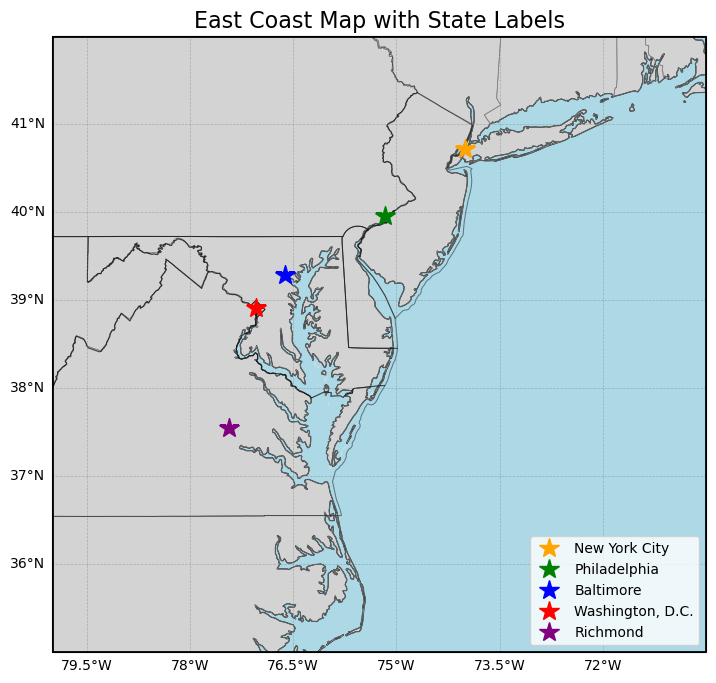

In [20]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot Maryland boundary
us_states.geometry.boundary.plot(ax=ax, color='black', linewidth=0.75, alpha=0.45, transform=ccrs.PlateCarree())
bounding_box.geometry.boundary.plot(ax=ax, color='black', linewidth=2, alpha=1, transform=ccrs.PlateCarree())

colors = ['blue', 'green', 'red', 'purple', 'orange']
for color, (idx, row) in zip(colors, major_cities_points.iterrows()):
    ax.plot(row.geometry.x, row.geometry.y, marker='*', markersize=15, color=color, alpha=1,
            transform=ccrs.PlateCarree())

from matplotlib.lines import Line2D
city_handles = [
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='orange',
              markeredgecolor='orange', label='New York City', markersize=15),

    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='green',
           markeredgecolor='green', label='Philadelphia', markersize=15),
        
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='blue',
           markeredgecolor='blue', label='Baltimore', markersize=15),
    
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='red',
           markeredgecolor='red', label='Washington, D.C.', markersize=15),
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='purple',
           markeredgecolor='purple', label='Richmond', markersize=15),

]
ax.legend(handles=city_handles, loc='lower right', fontsize=10, frameon=True)
plt.title("East Coast Map with State Labels", fontsize=16)
plt.show()

In [21]:
from pyspark.sql.functions import col

# reading the first file 
df = spark.read.parquet(files[0])

# selecting data only for our bounding box and filtering based on cloud fraction
df = df.filter(
    (col("longitude") >= min_lon) & 
    (col("longitude") <= max_lon) & 
    (col("latitude") >= min_lat) & 
    (col("latitude") <= max_lat) &
    (col("ColumnAmountNO2") > 0) &
    (col("cloudFraction") < 0.3) 
)

<b> The reason I only kept data with cloud Fraction less than 0.3 represents the quality of data. Each OMI pixel is roughly 10km*10km in resolution. Cloud Fraction represents the percentage of the pixel that is covered with cloud. Cloud reflect light and make satellite measurements unreliable if a pixel is covered a lot by a cloud. Therefore, I only kept rows where the fraction of cloud covering the data pixel is very very low.

In [22]:
# lets read rest of the files the same way and concaenate them to the first spark dataframe
for file in tqdm(files[1:]):
    try:
        no2_df = spark.read.parquet(file)
        no2_df = no2_df.filter(
            (col("longitude") >= min_lon) & 
            (col("longitude") <= max_lon) & 
            (col("latitude") >= min_lat) & 
            (col("latitude") <= max_lat) &
            (col("ColumnAmountNO2") > 0) &
            (col("cloudFraction") < 0.3) 
        )
        
        df = df.union(no2_df)
    except Exception as e:
        print(f"Error processing file {file}: {str(e)}")
        continue

100%|██████████| 83/83 [00:07<00:00, 10.39it/s]


In [23]:
df.show(10)

+---------+----------+---------------+-------------------+-------+-------+-------+-------+--------+--------+--------+--------+---------+
| latitude| longitude|ColumnAmountNO2|      cloudFraction|   LAT1|   LAT2|   LAT3|   LAT4|    LON1|    LON2|    LON3|    LON4|     date|
+---------+----------+---------------+-------------------+-------+-------+-------+-------+--------+--------+--------+--------+---------+
|35.054005|-76.120094|  3.56455335E15|              0.185|34.9601|35.0182| 35.147|35.0897|-76.2421|-75.9567|-75.9976|-76.2837|2018m0101|
|35.050556|-76.746704|   6.2522091E15|              0.123|34.9518|35.0175|35.1481|35.0836|-76.8763| -76.574|-76.6165|-76.9198|2018m0101|
|35.113728| -76.44831|   5.0609135E15|               0.17|35.0175|35.0793|35.2089|35.1481| -76.574|-76.2804|-76.3222|-76.6165|2018m0101|
|35.173218| -76.15825|  1.28521434E15|0.14200000000000002|35.0793|35.1374|35.2662|35.2089|-76.2804|-75.9946|-76.0357|-76.3222|2018m0101|
|35.030117| -77.41357|  2.62649383E15|0.1

The LAT1 LON1 etc features are essentially the OMI Pixel and latitude and longitude are the centroid of this. We can parse date to do timeseries data analysis for OMI NO2 pollution.

In [24]:
print("TOTAL NUMBER OF ROWS AVAILABLE: ", df.count())

TOTAL NUMBER OF ROWS AVAILABLE:  933312


In [25]:
df.printSchema()

root
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- ColumnAmountNO2: float (nullable = true)
 |-- cloudFraction: double (nullable = true)
 |-- LAT1: float (nullable = true)
 |-- LAT2: float (nullable = true)
 |-- LAT3: float (nullable = true)
 |-- LAT4: float (nullable = true)
 |-- LON1: float (nullable = true)
 |-- LON2: float (nullable = true)
 |-- LON3: float (nullable = true)
 |-- LON4: float (nullable = true)
 |-- date: string (nullable = true)



So, these are our columns. Lets look at the distribution our  column that is our main focus.

In [26]:
df.select("cloudFraction").describe().show()

+-------+-------------------+
|summary|      cloudFraction|
+-------+-------------------+
|  count|             933312|
|   mean| 0.0981186419975309|
| stddev|0.08331198059463912|
|    min|                0.0|
|    max|              0.299|
+-------+-------------------+



As we can see, the maximum cloud fraction available is 0.299. This is because we clipped it to 0.3. Let's also look at the distribution of ColumnAmountNO2.

In [27]:
df.select("ColumnAmountNO2").describe().show()

+-------+--------------------+
|summary|     ColumnAmountNO2|
+-------+--------------------+
|  count|              933312|
|   mean|4.866154761662119E15|
| stddev|2.344924332694524...|
|    min|       1.08984795E11|
|    max|        7.7858566E16|
+-------+--------------------+



ColumnAmountNO2 essentially represents the number of NO2 molecules from ground to the top of the atmosphere. So, there will be lots and lots of NO2 molecues at scales of 10 power 16. Lets look at the histogram of this column to better understand this.

In [28]:
ColumnAmountNO2_array  = df.select("ColumnAmountNO2").toPandas().values.flatten()

In [29]:
ColumnAmountNO2_array

array([3.5645533e+15, 6.2522091e+15, 5.0609135e+15, ..., 5.2203438e+15,
       4.6871053e+15, 4.8700280e+15], dtype=float32)

In [30]:
from matplotlib import ticker
import matplotlib.ticker as plticker
import matplotlib.dates as mdates

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,0)) 

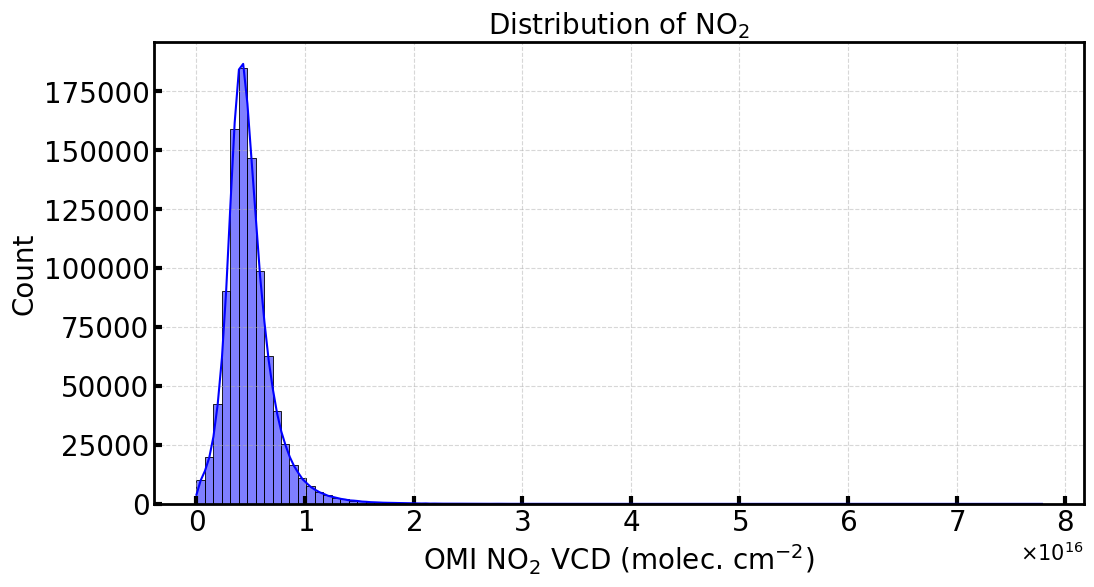

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(ColumnAmountNO2_array, bins=100, kde=True, color='blue', ax=ax)
plt.title("Distribution of NO$_2$", fontsize=20)
ax.tick_params(labelsize=20)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['left'].set_lw(2) 
ax.tick_params(which='both', width=3)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=6)
ax.tick_params(which = 'both', direction = 'in')
ax.set_ylabel("Count", fontsize=20)
ax.set_xlabel("OMI NO$_2$ VCD (molec. $\mathregular{cm^{-2}}$)", fontsize=20)
ax.xaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='scientific', axis = 'x') 
t = ax.xaxis.get_offset_text()
t.set_size(15)
ax.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [32]:
from pyspark.sql.functions import to_date, regexp_replace

# Fix date format from "2018m0101" to "20180101" then to date format
df = df.withColumn("date", to_date(regexp_replace("date", "m", ""), "yyyyMMdd"))

In [33]:
df.select("date").show(10)

+----------+
|      date|
+----------+
|2018-01-01|
|2018-01-01|
|2018-01-01|
|2018-01-01|
|2018-01-01|
|2018-01-01|
|2018-01-01|
|2018-01-01|
|2018-01-01|
|2018-01-01|
+----------+
only showing top 10 rows



In [34]:
df.printSchema()

root
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- ColumnAmountNO2: float (nullable = true)
 |-- cloudFraction: double (nullable = true)
 |-- LAT1: float (nullable = true)
 |-- LAT2: float (nullable = true)
 |-- LAT3: float (nullable = true)
 |-- LAT4: float (nullable = true)
 |-- LON1: float (nullable = true)
 |-- LON2: float (nullable = true)
 |-- LON3: float (nullable = true)
 |-- LON4: float (nullable = true)
 |-- date: date (nullable = true)



As we can see, our original date had values like 2018m0101, which have been converted to YYYY-MM-DD format. This is important as we will be doing timeseries data analysis later on. Since our date column now is in actual date data type, I will proceed to extract Year, Month, Day, DayName so that we can do detailed analysis.

In [35]:
from pyspark.sql.functions import year, month, dayofmonth, date_format
from pyspark.sql import functions as F

df = df.withColumn("year", year("date")) \
       .withColumn("month", month("date")) \
       .withColumn("day", dayofmonth("date")) \
       .withColumn("dayname", date_format("date", "EEEE"))

In [36]:
df = df.withColumn("date", F.to_date("date"))

In [37]:
df.show(5)

+---------+----------+---------------+-------------------+-------+-------+-------+-------+--------+--------+--------+--------+----------+----+-----+---+-------+
| latitude| longitude|ColumnAmountNO2|      cloudFraction|   LAT1|   LAT2|   LAT3|   LAT4|    LON1|    LON2|    LON3|    LON4|      date|year|month|day|dayname|
+---------+----------+---------------+-------------------+-------+-------+-------+-------+--------+--------+--------+--------+----------+----+-----+---+-------+
|35.054005|-76.120094|  3.56455335E15|              0.185|34.9601|35.0182| 35.147|35.0897|-76.2421|-75.9567|-75.9976|-76.2837|2018-01-01|2018|    1|  1| Monday|
|35.050556|-76.746704|   6.2522091E15|              0.123|34.9518|35.0175|35.1481|35.0836|-76.8763| -76.574|-76.6165|-76.9198|2018-01-01|2018|    1|  1| Monday|
|35.113728| -76.44831|   5.0609135E15|               0.17|35.0175|35.0793|35.2089|35.1481| -76.574|-76.2804|-76.3222|-76.6165|2018-01-01|2018|    1|  1| Monday|
|35.173218| -76.15825|  1.28521434

As we can see, we have the new columns extracted. Lets also create YYYY-MM column that way we can compute monthly average for each year from 2018-2024 for multiple cities to see the trend.

In [38]:
df = df.withColumn("year_month", date_format("date", "yyyy-MM"))
df.show(10)

+---------+----------+---------------+-------------------+-------+-------+-------+-------+--------+--------+--------+--------+----------+----+-----+---+-------+----------+
| latitude| longitude|ColumnAmountNO2|      cloudFraction|   LAT1|   LAT2|   LAT3|   LAT4|    LON1|    LON2|    LON3|    LON4|      date|year|month|day|dayname|year_month|
+---------+----------+---------------+-------------------+-------+-------+-------+-------+--------+--------+--------+--------+----------+----+-----+---+-------+----------+
|35.054005|-76.120094|  3.56455335E15|              0.185|34.9601|35.0182| 35.147|35.0897|-76.2421|-75.9567|-75.9976|-76.2837|2018-01-01|2018|    1|  1| Monday|   2018-01|
|35.050556|-76.746704|   6.2522091E15|              0.123|34.9518|35.0175|35.1481|35.0836|-76.8763| -76.574|-76.6165|-76.9198|2018-01-01|2018|    1|  1| Monday|   2018-01|
|35.113728| -76.44831|   5.0609135E15|               0.17|35.0175|35.0793|35.2089|35.1481| -76.574|-76.2804|-76.3222|-76.6165|2018-01-01|201

In [39]:
# from pyspark.sql.functions import avg

# monthly_avg_df = df.groupBy("year_month").agg(avg("ColumnAmountNO2").alias("avg_NO2"))

In [40]:
# monthly_avg_df = monthly_avg_df.toPandas()
# monthly_avg_df

Since OMI-NO2 is at around 0.1deg * 0.1deg grid dimension, I will proceed to create a 0.1deg * 0.1deg uniform fishnet(grids) accross the east coast. Then, I will use the data polygons and check their intersection with grid polygons and compute average OMI NO2 for each grid based on the number of data polygons that intersect the corresponding grid. This approach is a linear interpolation approach to make sure that all pixels around the grid are utilized to compute its average. I will use shapely for this. This can also be done in Apache Sedona, which I will continue learning.

In [41]:
import shapely
import dask_geopandas

def create_fishnet(polygon: shapely.Polygon, width_degree: float, height_degree: float):
    '''
    Takes in a Shapely Polygon, grid height and width to create uniform 0.1deg x 0.1deg grid cells accross the polygon.
    The function returns a GeoDataFrame of the grid cells that are inside the polygon.

    Also uses Dask-Geopandas to parallize and speed up the GeoPandas spatial join operation.
    '''
    xmin, ymin, xmax, ymax = polygon.total_bounds
    cell_width  = width_degree
    cell_height = height_degree
    grid_cells = []
    
    ''' CREATING PIXELS/GRIDS AROUND THE POLYGON '''
    for x0 in tqdm(np.arange(xmin, xmax+cell_width, cell_width )):
        for y0 in np.arange(ymin, ymax+cell_height, cell_height):
            x1 = x0-cell_width
            y1 = y0+cell_height
            new_cell = shapely.geometry.box(x0, y0, x1, y1)
            grid_cells.append(new_cell)
            
    fishnet_x = gpd.GeoDataFrame({'geometry':grid_cells}).set_geometry('geometry').set_crs('EPSG:4326')
    fishnet_x = fishnet_x[['geometry']]
    
    ''' ONLY SELECTING THE CREATED PIXELS THAT INERSECT WITH THE ORIGINAL POLYGON '''
    fishnet_dask = dask_geopandas.from_geopandas(fishnet_x, npartitions=12)
    fishnet_x = dask_geopandas.sjoin(fishnet_dask, polygon, predicate = 'intersects').compute()
    fishnet_x = fishnet_x[['geometry']].reset_index(drop = True)
    
    
    ''' CLIPPING THE PIXELS THAT OVERLAP THE POLYGON TO THE AREA INSIDE THE POLYGON '''
    fishnet_dask = dask_geopandas.from_geopandas(fishnet_x, npartitions=12)
    fishnet_x = dask_geopandas.clip(fishnet_dask, polygon, keep_geom_type = True).compute()
    fishnet_x = fishnet_x[['geometry']].reset_index(drop = True)
    
    return fishnet_x

fishnet_x = create_fishnet(bounding_box, 0.1, 0.1)
fishnet_x["ID"] =  range(1, len(fishnet_x) + 1)

100%|██████████| 96/96 [00:00<00:00, 577.55it/s]


In [42]:
fishnet_x

geometry    ID
0     POLYGON ((-80 35.1, -79.9 35.1, -79.9 35, -80 ...     1
1     POLYGON ((-80 35.2, -79.9 35.2, -79.9 35.1, -8...     2
2     POLYGON ((-80 35.3, -79.9 35.3, -79.9 35.2, -8...     3
3     POLYGON ((-80 35.4, -79.9 35.4, -79.9 35.3, -8...     4
4     POLYGON ((-80 35.5, -79.9 35.5, -79.9 35.4, -8...     5
...                                                 ...   ...
6645  POLYGON ((-70.6 41.6, -70.5 41.6, -70.5 41.5, ...  6646
6646  POLYGON ((-70.6 41.7, -70.5 41.7, -70.5 41.6, ...  6647
6647  POLYGON ((-70.6 41.8, -70.5 41.8, -70.5 41.7, ...  6648
6648  POLYGON ((-70.6 41.9, -70.5 41.9, -70.5 41.8, ...  6649
6649  POLYGON ((-70.6 42, -70.5 42, -70.5 41.9, -70....  6650

[6650 rows x 2 columns]

We have a total of 6650 grids accross the selected east-coast region that are all 0.1deg * 0.1deg dimension. Lets plot everything I've build together.

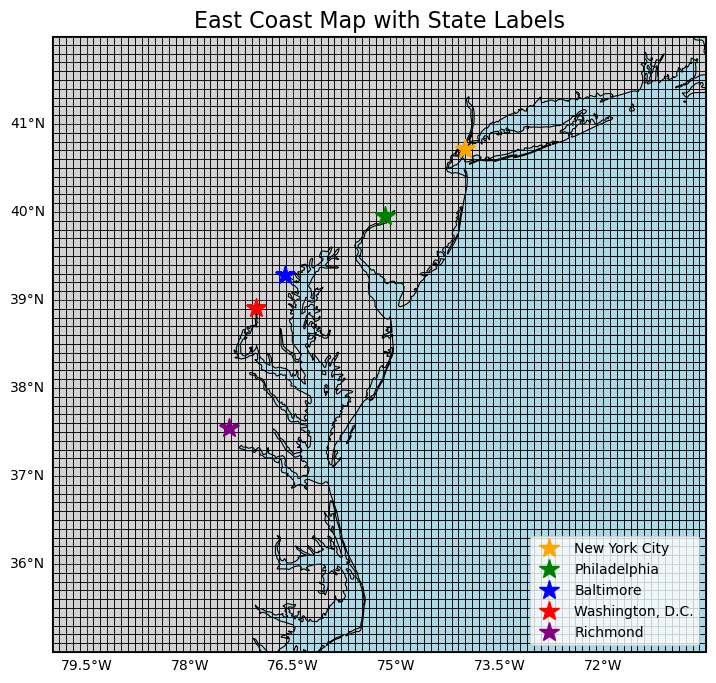

In [43]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

fishnet_x.geometry.boundary.plot(ax=ax, color = "black", alpha = 1, linewidth = 0.5, edgecolor = "black")
bounding_box.geometry.boundary.plot(ax=ax, color='black', linewidth=2, alpha=1, transform=ccrs.PlateCarree())

colors = ['blue', 'green', 'red', 'purple', 'orange']
for color, (idx, row) in zip(colors, major_cities_points.iterrows()):
    ax.plot(row.geometry.x, row.geometry.y, marker='*', markersize=15, color=color, alpha=1,
            transform=ccrs.PlateCarree())

from matplotlib.lines import Line2D
city_handles = [
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='orange',
              markeredgecolor='orange', label='New York City', markersize=15),

    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='green',
           markeredgecolor='green', label='Philadelphia', markersize=15),
        
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='blue',
           markeredgecolor='blue', label='Baltimore', markersize=15),
    
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='red',
           markeredgecolor='red', label='Washington, D.C.', markersize=15),
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='purple',
           markeredgecolor='purple', label='Richmond', markersize=15),

]
ax.legend(handles=city_handles, loc='lower right', fontsize=10, frameon=True)
plt.title("East Coast Map with State Labels", fontsize=16)
plt.show()

Now that we have set up the grids and our data, lets do spatial data analysis and check trend of NO2 pollution accross multiple cities from 2018 to 2024. Also, lets zoom in around the lockdowns in 2020 to see the impact of covid-19 on NO2 pollution accross major cities in the east coast of USA.

## 3.1 Covid-19 NO2 Pollution Trend Analysis

In [44]:
from shapely import Polygon

def get_polygon(row):
    '''
    Takes in corner cordinates of Latitude and Longitudes and return a polygon that is roughly 0.1deg * 0.1deg.
    '''
    return Polygon([(row['LON1'], row['LAT1']), (row['LON2'], row['LAT2']),(row['LON3'], row['LAT3']), (row['LON4'], row['LAT4'])])

Unfortunately, using PySpark dataframes to store Shapely Objects is not possible, unless I use Sedona. So, I will convert Spark dataframe to GeoPandas dataframe to do spatial calculations like within, intersection, sjoin_nearest etc. Howeever, all of the other standard operations will be done purely in PySpark.

In [45]:
geopandas_df = df.toPandas() # reverting back to pandas dataframe

In [46]:
from tqdm.notebook import tqdm
tqdm.pandas()


# creating polygons from corner cordinates
geopandas_df['rectangle'] = geopandas_df.progress_apply(get_polygon, axis = 1)
geopandas_df = gpd.GeoDataFrame(geopandas_df, geometry="rectangle", crs="EPSG:4326")

  0%|          | 0/933312 [00:00<?, ?it/s]

In [47]:
geopandas_df.columns

Index(['latitude', 'longitude', 'ColumnAmountNO2', 'cloudFraction', 'LAT1',
       'LAT2', 'LAT3', 'LAT4', 'LON1', 'LON2', 'LON3', 'LON4', 'date', 'year',
       'month', 'day', 'dayname', 'year_month', 'rectangle'],
      dtype='object')

In [48]:
geopandas_df = geopandas_df[["date", "year", "month", "day", "year_month", "dayname", "rectangle", "ColumnAmountNO2"]].copy()
geopandas_df["date"] = pd.to_datetime(geopandas_df["date"])
geopandas_df.head()

date  year  month  day year_month dayname  \
0 2018-01-01  2018      1    1    2018-01  Monday   
1 2018-01-01  2018      1    1    2018-01  Monday   
2 2018-01-01  2018      1    1    2018-01  Monday   
3 2018-01-01  2018      1    1    2018-01  Monday   
4 2018-01-01  2018      1    1    2018-01  Monday   

                                           rectangle  ColumnAmountNO2  
0  POLYGON ((-76.2421 34.9601, -75.9567 35.0182, ...     3.564553e+15  
1  POLYGON ((-76.8763 34.9518, -76.574 35.0175, -...     6.252209e+15  
2  POLYGON ((-76.574 35.0175, -76.2804 35.0793, -...     5.060914e+15  
3  POLYGON ((-76.2804 35.0793, -75.9946 35.1374, ...     1.285214e+15  
4  POLYGON ((-77.5533 34.9252, -77.2286 35.0005, ...     2.626494e+15

In [49]:
geopandas_df["date"]

0        2018-01-01
1        2018-01-01
2        2018-01-01
3        2018-01-01
4        2018-01-01
            ...    
933307   2024-12-30
933308   2024-12-30
933309   2024-12-30
933310   2024-12-30
933311   2024-12-30
Name: date, Length: 933312, dtype: datetime64[ns]

In [50]:
from collections import OrderedDict
def get_ordered_dict(dx, IDs):
    '''
    This will sort the values in order of the fishnet grid IDs after doing spatial joins
    '''
    for id_ in IDs:
        if id_ not in dx.keys():
            dx[id_] = np.nan
    
    dict1 = dict(OrderedDict(sorted(dx.items())))
    return np.array(list(dict1.values()))

In [51]:
def apply_spatial_join_with_intersection(dataframe: gpd.GeoDataFrame, start_date: str, end_date: str, output_column: str):
    '''
    This function will take in a dataframe and do a spatial join with the fishnet grid cells based on intersection and return average OMI NO2 values for each grid cell.
    '''
    dataframe = dataframe[(dataframe["date"] >= start_date) & (dataframe["date"] <= end_date)]
    result = fishnet_x.sjoin(dataframe, predicate = 'intersects')
    fishnet_x[output_column]  = get_ordered_dict(dict(result.groupby('ID', dropna = False)['ColumnAmountNO2'].mean()), fishnet_x['ID'])

Based on quick google search, I found that the core lockdowns during Covid-19 happened between March and May of 2020. So, lets only use that date range to do averaging for years 2019, 2020, and 2021. This way, we can directly compare 2020 values with 2019 and 2020 to see how NO2 pollution looked like in 2019, how much reduction we got in 2020 and for the same timeframe in 2021 when everything was normal, the pattern of NO2 pollution recovery.

In [52]:
%%time

local_data = geopandas_df[geopandas_df.year==2019].copy()
apply_spatial_join_with_intersection(local_data, "2019-03-01", "2019-05-31", "NO2_2019")

CPU times: total: 562 ms
Wall time: 1.01 s


In [53]:
%%time

local_data = geopandas_df[geopandas_df.year==2020].copy()
apply_spatial_join_with_intersection(local_data, "2020-03-01", "2020-05-31", "NO2_2020")

CPU times: total: 594 ms
Wall time: 859 ms


In [54]:
%%time

local_data = geopandas_df[geopandas_df.year==2021].copy()
apply_spatial_join_with_intersection(local_data, "2021-03-01", "2021-05-31", "NO2_2021")

CPU times: total: 812 ms
Wall time: 1.11 s


In [55]:
fishnet_x.head()

geometry  ID      NO2_2019  \
0  POLYGON ((-80 35.1, -79.9 35.1, -79.9 35, -80 ...   1  5.116796e+15   
1  POLYGON ((-80 35.2, -79.9 35.2, -79.9 35.1, -8...   2  5.155025e+15   
2  POLYGON ((-80 35.3, -79.9 35.3, -79.9 35.2, -8...   3  5.186121e+15   
3  POLYGON ((-80 35.4, -79.9 35.4, -79.9 35.3, -8...   4  5.067850e+15   
4  POLYGON ((-80 35.5, -79.9 35.5, -79.9 35.4, -8...   5  5.028969e+15   

       NO2_2020      NO2_2021  
0  4.331176e+15  4.841020e+15  
1  4.229415e+15  4.882031e+15  
2  4.433685e+15  4.901506e+15  
3  4.384126e+15  4.850389e+15  
4  4.391195e+15  4.830525e+15

Now that we have averages for each grid, lets do the spatial plot next.

0it [00:00, ?it/s]

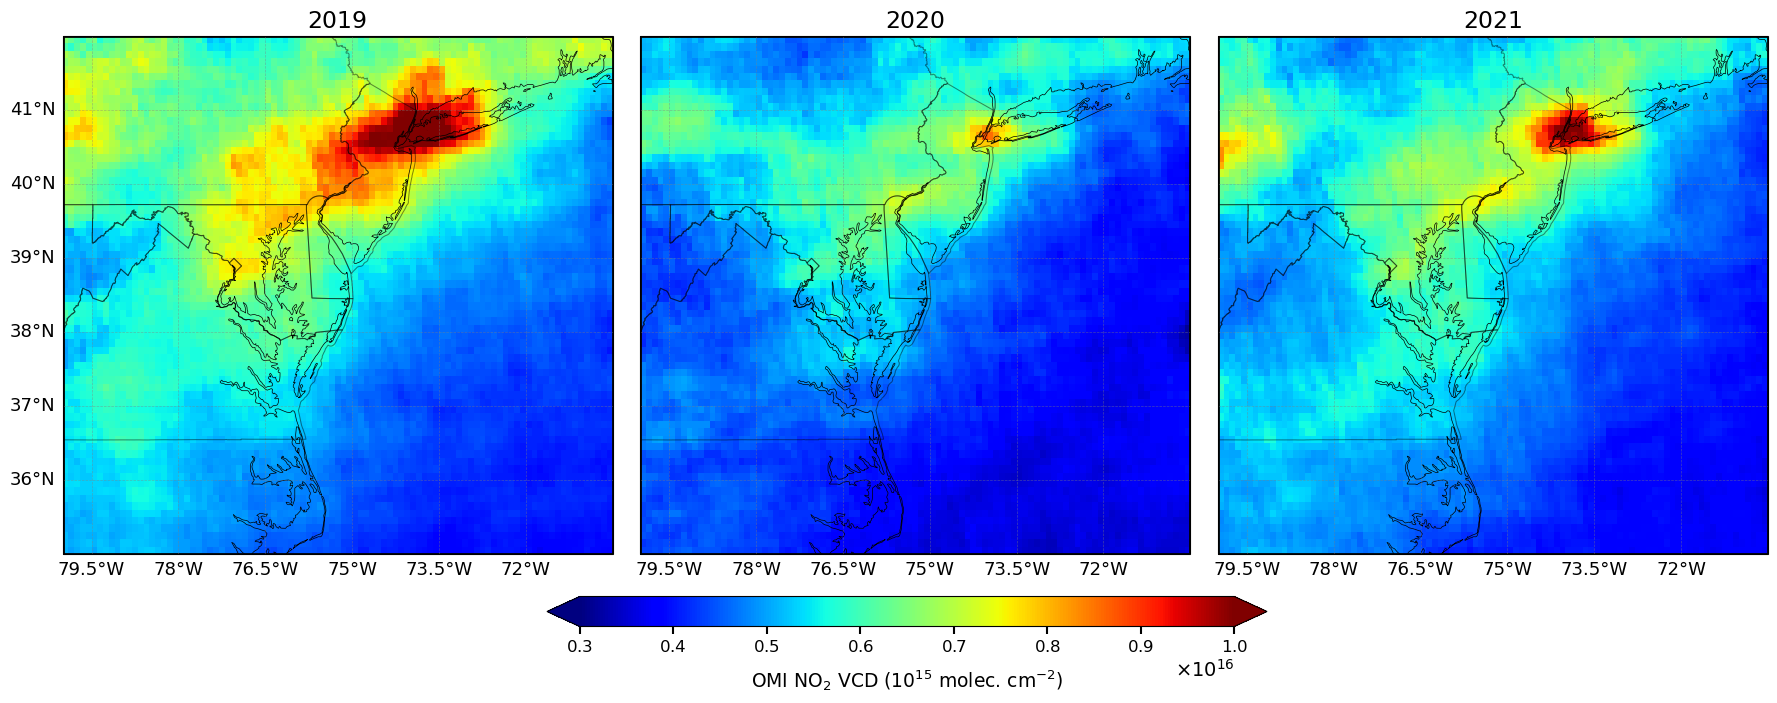

In [56]:
vmin = 3e+15
vmax = 10e+15
cmap = "jet"
alpha = 1

plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, figsize=(18, 6), 
                        subplot_kw={"projection": ccrs.PlateCarree()},
                        gridspec_kw={'width_ratios': [1, 1, 1]})

years = ['2019', '2020', '2021']
columns = ['NO2_2019', 'NO2_2020', 'NO2_2021']
current_col = 0

for ax, year, col in tqdm(zip(axes, years, columns)):
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    # ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    if current_col != 0:
        gl.left_labels = False
    
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}

    
    bounding_box.geometry.boundary.plot(ax=ax, color='black', linewidth=2, alpha=1, transform=ccrs.PlateCarree())
    us_states.geometry.boundary.plot(ax=ax, color='black', linewidth=0.75, alpha=0.45, transform=ccrs.PlateCarree())

    fishnet_x.plot(ax=ax, column=col, alpha=alpha, linewidth=0, edgecolor=None, cmap=cmap,
                   missing_kwds=dict(color='grey', label='No Data'), vmin=vmin, vmax=vmax, legend=False)
    
    ax.set_title(year, fontsize=17)

    ax.tick_params(labelsize=20)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_lw(2) 
    ax.tick_params(which='both', width=3)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=6)
    ax.tick_params(which = 'both', direction = 'in')
    current_col += 1

cax = fig.add_axes([0.31, -0.02, 0.4, 0.05])  
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal', extend='both')
cbar.set_label('OMI NO$_2$ VCD ($10^{15}$ molec. $\mathregular{cm^{-2}}$)', 
               fontsize=13.5, labelpad=10, fontweight='normal')
cbar.ax.tick_params(length=5, width=1.5, which="major", direction='out', labelsize=12)
cbar.set_alpha(alpha)
cbar.draw_all()
cbar.formatter.set_useMathText(True)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, hspace=0.1, wspace=0.05)  
plt.show()  

We can cleary see during 2020, the NO2 pollution has dropped by a significant margin. This figure calculation is done using March-May for 2019, 2020, and 2021. Due to covid lockdowns, stuff like vehicle emissions, industrial process etc reduced by a huge margin, which ultimately led to less NO2 in the atmosphere. Similarly, when lockdowns eased, the same timeframe (March-May) in 2021 shows pollution has recovered by a lot margin as people started driving their cars to go to work, power plants, airplaes etc started operating at normal rate.

In [57]:
import matplotlib.ticker as mticker

In [58]:
geopandas_df

date  year  month  day year_month dayname  \
0      2018-01-01  2018      1    1    2018-01  Monday   
1      2018-01-01  2018      1    1    2018-01  Monday   
2      2018-01-01  2018      1    1    2018-01  Monday   
3      2018-01-01  2018      1    1    2018-01  Monday   
4      2018-01-01  2018      1    1    2018-01  Monday   
...           ...   ...    ...  ...        ...     ...   
933307 2024-12-30  2024     12   30    2024-12  Monday   
933308 2024-12-30  2024     12   30    2024-12  Monday   
933309 2024-12-30  2024     12   30    2024-12  Monday   
933310 2024-12-30  2024     12   30    2024-12  Monday   
933311 2024-12-30  2024     12   30    2024-12  Monday   

                                                rectangle  ColumnAmountNO2  
0       POLYGON ((-76.2421 34.9601, -75.9567 35.0182, ...     3.564553e+15  
1       POLYGON ((-76.8763 34.9518, -76.574 35.0175, -...     6.252209e+15  
2       POLYGON ((-76.574 35.0175, -76.2804 35.0793, -...     5.060914e+15  
3       POLYGON ((-76.2804 35.0793, -75.9946 35.1374, ...     1.285214e+15  
4       POLYGON ((-77.5533 34.9252, -77.2286 35.0005, ...     2.626494e+15  
...                                                   ...              ...  
933307  POLYGON ((-78.507 40.1252, -78.1651 40.2053, -...     4.929410e+15  
933308  POLYGON ((-78.1651 40.2053, -77.8351 40.2801, ...     5.846137e+15  
933309  POLYGON ((-80.0836 39.8535, -79.6723 39.9631, ...     5.220344e+15  
933310  POLYGON ((-80.1322 39.9711, -79.7202 40.0809, ...     4.687105e+15  
933311  POLYGON ((-77.9703 40.6357, -77.6493 40.706, -...     4.870028e+15  

[933312 rows x 8 columns]

In [59]:
for year in tqdm(range(2018, 2025)):
    local_data = geopandas_df[geopandas_df.year==year].copy()
    result = fishnet_x[["ID", "geometry"]].sjoin(local_data, predicate = 'intersects')
    fishnet_x[str(year)]  = get_ordered_dict(dict(result.groupby('ID', dropna = False)['ColumnAmountNO2'].mean()), fishnet_x['ID'])

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

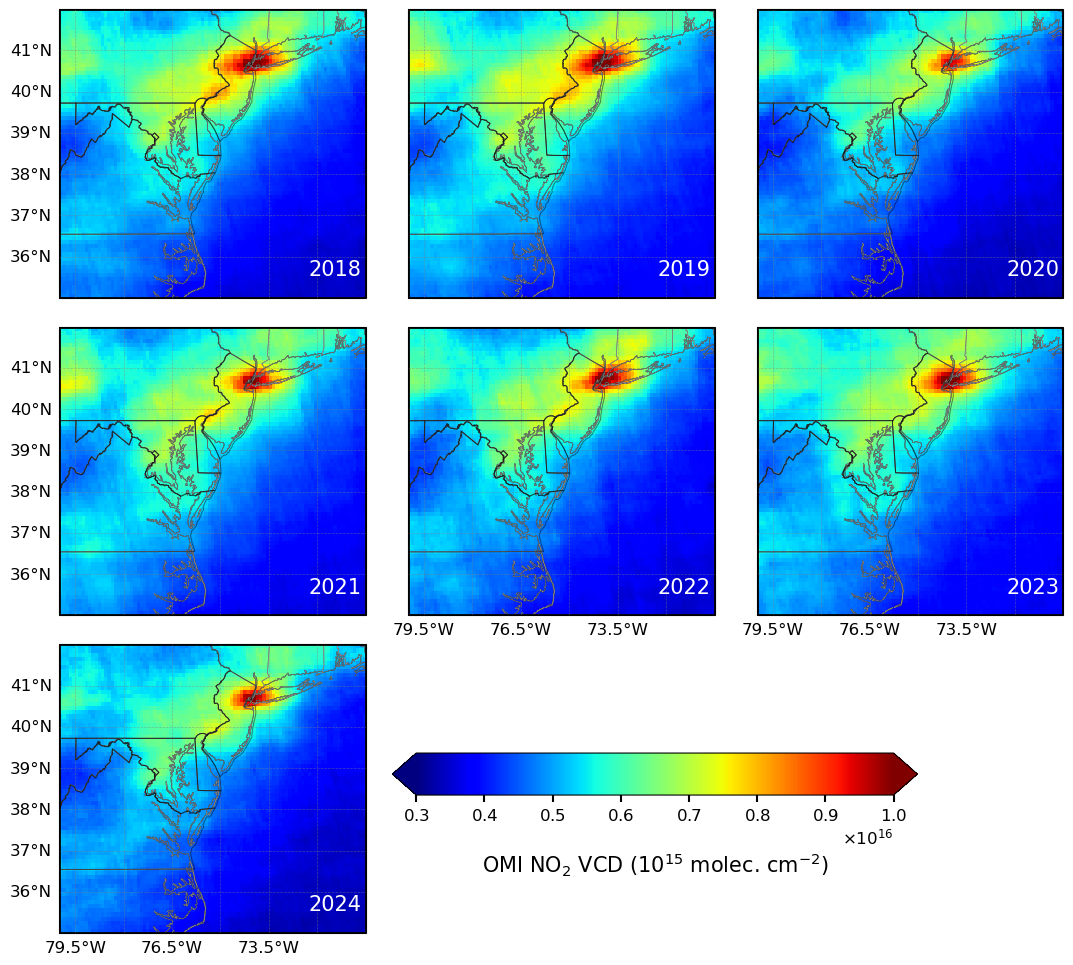

In [60]:
vmin = 3e+15
vmax = 10e+15
cmap = "jet"
alpha = 1

plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(3, 3, figsize=(15, 12), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten() 

years = ["2018", '2019', '2020', '2021', "2022", "2023", "2024"]
current_col = 0

for ax, year in tqdm(zip(axes[:len(years)], years)):
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    if current_col not in [0, 3, 6]:
        gl.left_labels = False

    if current_col not in [4, 5, 6]:
        gl.bottom_labels = False
    
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

    
    bounding_box.geometry.boundary.plot(ax=ax, color='black', linewidth=2, alpha=1, transform=ccrs.PlateCarree())
    us_states.geometry.boundary.plot(ax=ax, color='black', linewidth=0.75, alpha=0.45, transform=ccrs.PlateCarree())

    fishnet_x.plot(ax=ax, column=year, alpha=alpha, linewidth=0, edgecolor=None, cmap=cmap,
                   missing_kwds=dict(color='grey', label='No Data'), vmin=vmin, vmax=vmax, legend=False)
    
    ax.annotate(year, xy=(0.9, 0.1), xycoords='axes fraction', fontsize=15, ha='center', va='center', color="white", fontweight="normal")

    ax.tick_params(labelsize=15)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_lw(2) 
    ax.tick_params(which='both', width=3)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=6)
    ax.tick_params(which = 'both', direction = 'in')
    gl.xlocator = mticker.MaxNLocator(nbins=8) 
    current_col += 1

cax = fig.add_axes([0.4, 0.225, 0.35, 0.035])  
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal', extend='both')
cbar.set_label('OMI NO$_2$ VCD ($10^{15}$ molec. $\mathregular{cm^{-2}}$)', 
               fontsize=15, labelpad=20, fontweight='normal')
cbar.ax.tick_params(length=5, width=1.5, which="major", direction='out', labelsize=12)
cbar.set_alpha(alpha)
cbar.draw_all()
cbar.formatter.set_useMathText(True)

for ax in axes[len(years):]:
    ax.set_visible(False)

plt.subplots_adjust(wspace=-0.25, hspace=0.1)  
plt.show()  

This is yearly average for all years from 2018 to 2024. If we look at this plot in detail, we see NO2 pollution going down overtime. If I had used data from 2000s to 2024 (25 year average), it would have been more clear. But, the concentrated region in NYC is also diluting over the year and same case applies to regional hotspots.

This is due to EV mandates, reduction in use of coal, and cleaner energy sources that are being applied more in recent years.

In [61]:
spark_df = spark.createDataFrame(fishnet_x[["ID", "NO2_2019", "NO2_2020", "NO2_2021"]])

In [62]:
spark_df.show(5)

+---+--------------------+--------------------+--------------------+
| ID|            NO2_2019|            NO2_2020|            NO2_2021|
+---+--------------------+--------------------+--------------------+
|  1|5.116796403187712E15|4.331175749353472E15|4.841020311207936E15|
|  2|5.155025370218496E15|4.229414820773888E15|4.882031343304704E15|
|  3|5.186121470312448E15|4.433684539113472E15|4.901505798766592E15|
|  4|5.067850419011584E15|4.384125716791296E15|4.850389245493248E15|
|  5| 5.02896915382272E15|4.391194964525056E15|4.830525021749248E15|
+---+--------------------+--------------------+--------------------+
only showing top 5 rows



In [63]:
spark_df.printSchema()

root
 |-- ID: long (nullable = true)
 |-- NO2_2019: double (nullable = true)
 |-- NO2_2020: double (nullable = true)
 |-- NO2_2021: double (nullable = true)



In [64]:
from pyspark.sql.functions import col

# calculating the percent change between 2019 and 2020
spark_df = spark_df.withColumn("percentage_change_2019_2020",
    ((col("NO2_2020") - col("NO2_2019")) / col("NO2_2019")) * 100
)

# calculating the percent change between 2020 and 2021
spark_df = spark_df.withColumn("percentage_change_2020_2021",
    ((col("NO2_2021") - col("NO2_2020")) / col("NO2_2020")) * 100
)

In [65]:
spark_df.select("percentage_change_2019_2020", "percentage_change_2020_2021").describe().show()

+-------+---------------------------+---------------------------+
|summary|percentage_change_2019_2020|percentage_change_2020_2021|
+-------+---------------------------+---------------------------+
|  count|                       6650|                       6650|
|   mean|         -16.26226314642942|          10.30686638165524|
| stddev|          5.848220852093333|          6.841962251124877|
|    min|        -41.812832071780214|         -11.83230896331333|
|    max|          4.205607214208522|          52.91901832077501|
+-------+---------------------------+---------------------------+



Across all grids, from 2019-2020, NO2 reduced by 16% and from 2020-2021 for same march-may period, there is 10% increment in NO2.

In [66]:
results = spark_df.select("percentage_change_2019_2020", "percentage_change_2020_2021").toPandas()
fishnet_x["percentage_change_2019_2020"] = results["percentage_change_2019_2020"].values
fishnet_x["percentage_change_2020_2021"] = results["percentage_change_2020_2021"].values

0it [00:00, ?it/s]

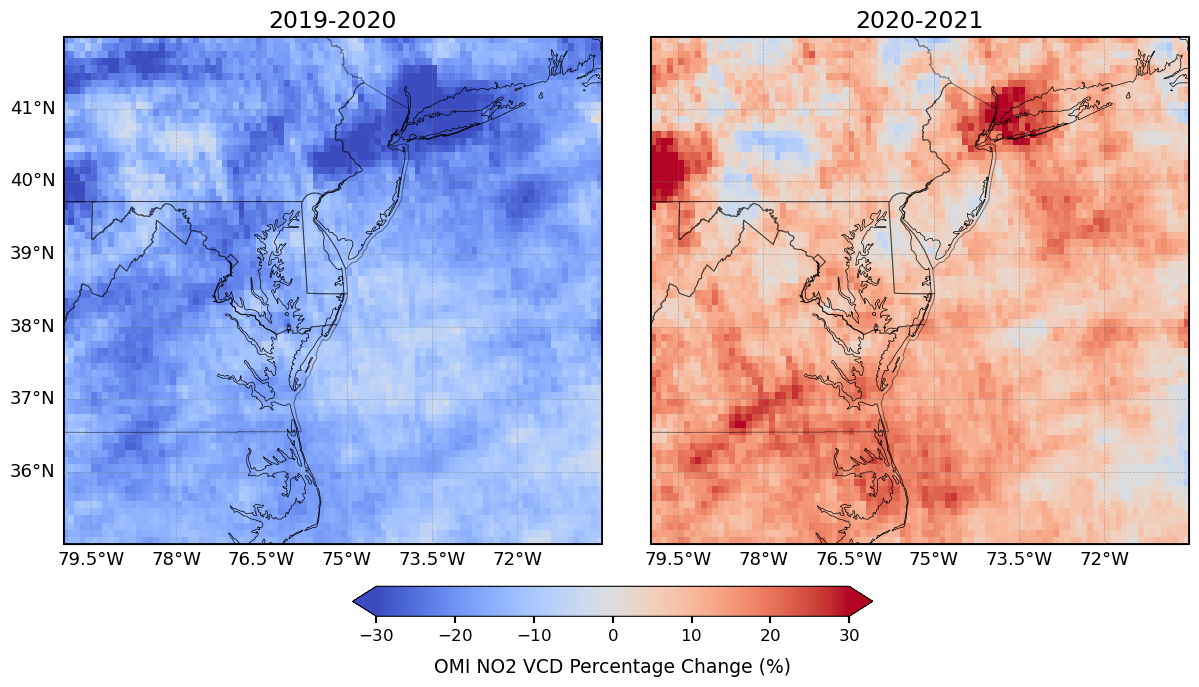

In [67]:
vmin = -30
vmax = 30
cmap = "coolwarm"
alpha = 1

plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 2, figsize=(13, 6), 
                        subplot_kw={"projection": ccrs.PlateCarree()},
                        gridspec_kw={'width_ratios': [1, 1]})

years = ["2019-2020", "2020-2021"]
columns = ['percentage_change_2019_2020', 'percentage_change_2020_2021']
current_col = 0

for ax, year, col in tqdm(zip(axes, years, columns)):
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    if current_col != 0:
        gl.left_labels = False
    
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}

    
    bounding_box.geometry.boundary.plot(ax=ax, color='black', linewidth=2, alpha=1, transform=ccrs.PlateCarree())
    us_states.geometry.boundary.plot(ax=ax, color='black', linewidth=0.75, alpha=0.45, transform=ccrs.PlateCarree())

    fishnet_x.plot(ax=ax, column=col, alpha=alpha, linewidth=0, edgecolor=None, cmap=cmap,
                   missing_kwds=dict(color='grey', label='No Data'), vmin=vmin, vmax=vmax, legend=False)
    
    ax.set_title(year, fontsize=17)

    ax.tick_params(labelsize=20)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_lw(2) 
    ax.tick_params(which='both', width=3)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=6)
    ax.tick_params(which = 'both', direction = 'in')
    current_col += 1

cax = fig.add_axes([0.31, -0.02, 0.4, 0.05])  
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal', extend='both')
cbar.set_label('OMI NO2 VCD Percentage Change (%)', 
               fontsize=13.5, labelpad=10, fontweight='normal')
cbar.ax.tick_params(length=5, width=1.5, which="major", direction='out', labelsize=12)
cbar.set_alpha(alpha)
cbar.draw_all()
cbar.formatter.set_useMathText(True)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, hspace=0.1, wspace=-0.05)  
plt.show()  

This is essentially percentage change between each grid cell from 2019-2020 and 2020-2021 for NO2. Due to lockdowns, we see huge percentage reduction of OMI NO2 in the atmosphere for core NYC area and other hotspots whereas, in 2021, pollution has almost recovered as lockdowns eased and things went back to normal.

Let's look at each major citie in East Coast: `NYC, Philly, DC, Baltimore and Richmond`.

In [68]:
'''
OpenStreetMap python package is very useful to get the geometries of the cities and their boundaries.
'''

cities = ["Baltimore, Maryland, USA", 
          "Richmond, Virginia, USA", 
          "Philadelphia, Pennsylvania, USA", 
          "New York City, New York, USA", 
          "Washington D.C, USA"]

city_geometries = []
for city in cities:
    city_name = city.split(",")[0]
    city_geometries.append(ox.geocode_to_gdf(city)["geometry"].values[0]) # OSM python package returns a GeoDataFrame

city_geometries = gpd.GeoDataFrame({"City": cities}, geometry=city_geometries, crs="EPSG:4326")
city_geometries["City"] = city_geometries["City"].str.split(",").str[0]

In [69]:
city_geometries

City                                           geometry
0       Baltimore  POLYGON ((-76.7113 39.37193, -76.71129 39.3675...
1        Richmond  POLYGON ((-77.60117 37.54516, -77.60077 37.544...
2    Philadelphia  POLYGON ((-75.2803 39.975, -75.28022 39.97489,...
3   New York City  MULTIPOLYGON (((-74.25884 40.49888, -74.25814 ...
4  Washington D.C  POLYGON ((-77.11979 38.93435, -77.11977 38.934...

In [70]:
def filter_data_for_city(local_df: gpd.GeoDataFrame, city_name: str):
    '''
    Given a city Name, filter the data for that city and return the filtered dataframe for the corresponding city.
    '''
    local_df = local_df.copy()
    local_df = local_df.sjoin(city_geometries[city_geometries["City"] == city_name], predicate = 'intersects')
    local_df = local_df[["date", "year", "month", "day", "year_month", "dayname", "ColumnAmountNO2"]].copy()
    return local_df

In [71]:
baltimore_df = filter_data_for_city(geopandas_df, "Baltimore")
richmond_df = filter_data_for_city(geopandas_df, "Richmond")
philadelphia_df = filter_data_for_city(geopandas_df, "Philadelphia")
newyork_df = filter_data_for_city(geopandas_df, "New York City")
washington_df = filter_data_for_city(geopandas_df, "Washington D.C") 

baltimore_df.shape, richmond_df.shape, philadelphia_df.shape, newyork_df.shape, washington_df.shape

((4743, 7), (4476, 7), (5672, 7), (10223, 7), (4754, 7))

In [72]:
selected_columns = ["date", "year", "month", "day", "year_month", "dayname", "ColumnAmountNO2"]

# recreating spark dataframes for each of the cities
baltimore_spark_df = spark.createDataFrame(baltimore_df[selected_columns])
richmond_spark_df = spark.createDataFrame(richmond_df[selected_columns])
philadelphia_spark_df = spark.createDataFrame(philadelphia_df[selected_columns])
newyork_spark_df = spark.createDataFrame(newyork_df[selected_columns])
washington_spark_df = spark.createDataFrame(washington_df[selected_columns])

In [73]:
baltimore_spark_df.show(5)

+-------------------+----+-----+---+----------+---------+--------------------+
|               date|year|month|day|year_month|  dayname|     ColumnAmountNO2|
+-------------------+----+-----+---+----------+---------+--------------------+
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|  Tuesday|7.739732930854912E15|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|  Tuesday| 5.15592301838336E15|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|  Tuesday|4.500884671168512E15|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|  Tuesday|5.594668423184384E15|
|2018-01-03 00:00:00|2018|    1|  3|   2018-01|Wednesday| 1.30681627738112E16|
+-------------------+----+-----+---+----------+---------+--------------------+
only showing top 5 rows



Now that we have spark dataframes for each city, lets compute average NO2 per YEAR-MONTH and plot a lineplot to check the NO2 pattern overtime.

In [74]:
baltimore_city_summary = baltimore_spark_df.groupBy("year_month").agg(
    F.mean("ColumnAmountNO2").alias("mean"),
    (F.stddev("ColumnAmountNO2") / F.sqrt(F.count("ColumnAmountNO2"))).alias("std_error")
).orderBy(F.asc("year_month"))

In [75]:
baltimore_city_summary.show(5)

+----------+--------------------+--------------------+
|year_month|                mean|           std_error|
+----------+--------------------+--------------------+
|   2018-01|8.020084467726098E15|4.180340238392059E14|
|   2018-02|9.590144483947202E15|6.646565639232591E14|
|   2018-03|9.843674173564518E15|7.291387846602438E14|
|   2018-04|  6.2571404110471E15|1.952124850932289...|
|   2018-05|6.660900496867328E15|1.657644356532552...|
+----------+--------------------+--------------------+
only showing top 5 rows



Here, standard error is standard deviation divided by square root of the number of samples. I am plotting error bar and using standard deviation only would show huge spikes that would disturb the plot. That's why I used standard error instead. Now, lets calculate the mean and standard error for other cities.

In [76]:
# getting values for other cities as well
richmond_city_summary = richmond_spark_df.groupBy("year_month").agg(
    F.mean("ColumnAmountNO2").alias("mean"),
    (F.stddev("ColumnAmountNO2") / F.sqrt(F.count("ColumnAmountNO2"))).alias("std_error")
).orderBy(F.asc("year_month"))

washingtonDC_city_summary = washington_spark_df.groupBy("year_month").agg(
    F.mean("ColumnAmountNO2").alias("mean"),
    (F.stddev("ColumnAmountNO2") / F.sqrt(F.count("ColumnAmountNO2"))).alias("std_error")
).orderBy(F.asc("year_month"))

philadelphia_city_summary = philadelphia_spark_df.groupBy("year_month").agg(
    F.mean("ColumnAmountNO2").alias("mean"),
    (F.stddev("ColumnAmountNO2") / F.sqrt(F.count("ColumnAmountNO2"))).alias("std_error")
).orderBy(F.asc("year_month"))

newyork_city_summary = newyork_spark_df.groupBy("year_month").agg(
    F.mean("ColumnAmountNO2").alias("mean"),
    (F.stddev("ColumnAmountNO2") / F.sqrt(F.count("ColumnAmountNO2"))).alias("std_error")
).orderBy(F.asc("year_month"))

In [77]:
city_dfs = {
    "New York City": newyork_city_summary,
    "Baltimore": baltimore_city_summary,
    "Washington D.C": washingtonDC_city_summary,
}

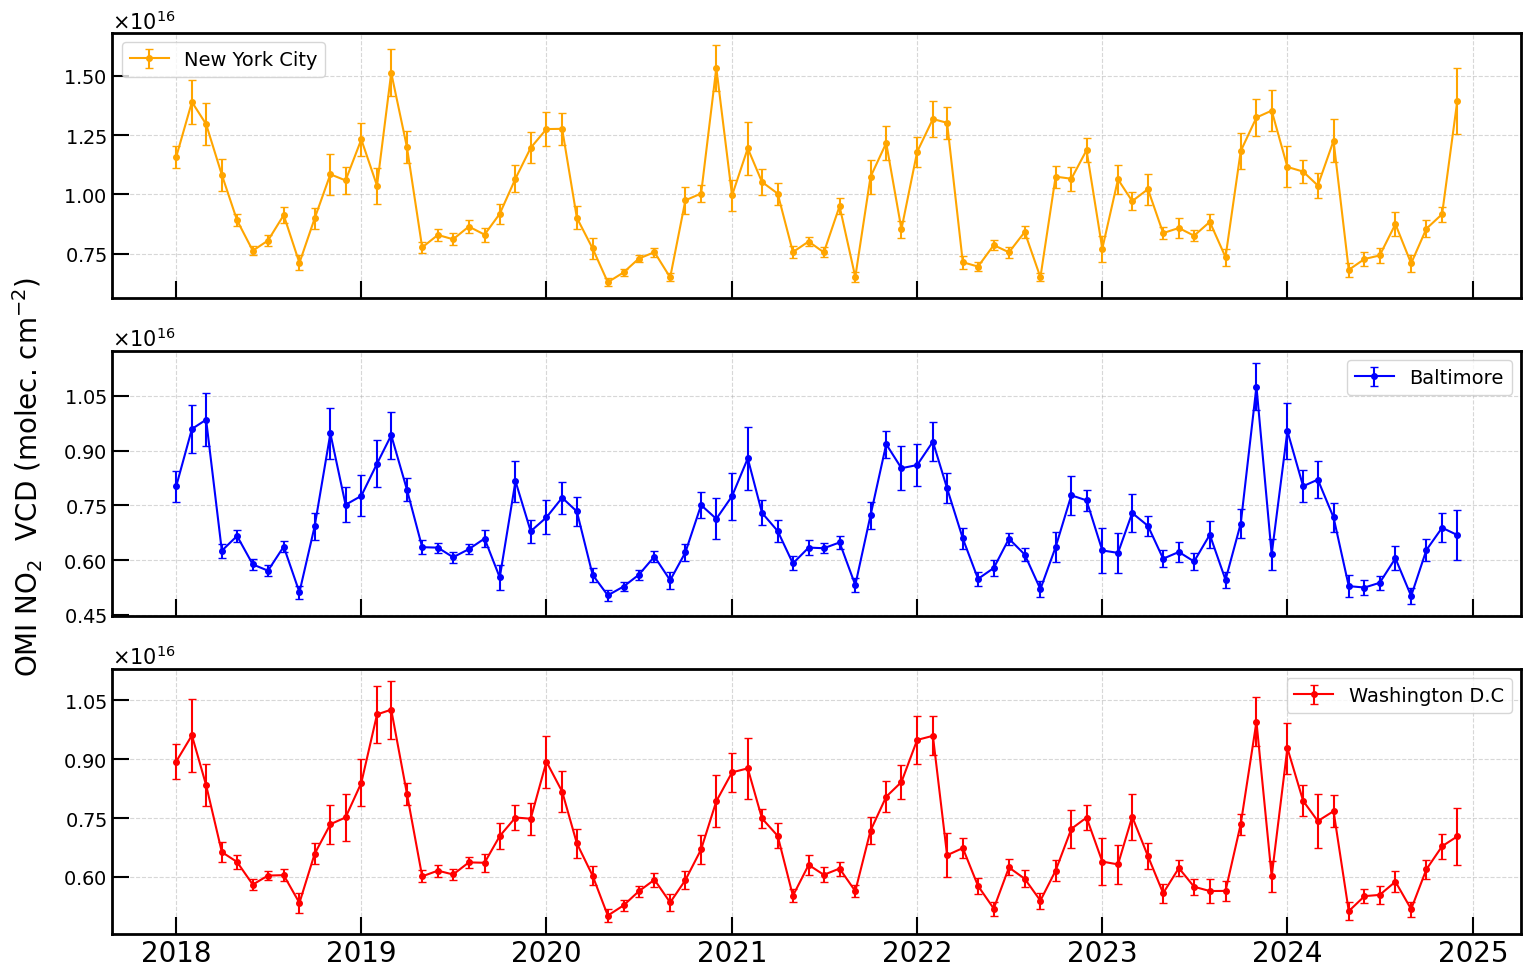

In [78]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))  
col = 1
city_and_colors = {
    "New York City": "orange",
    "Baltimore": "blue",
    "Richmond": "purple",    
    "Washington D.C": "red",
    "Philadelphia": "green",
}

for ax, (city_name, city_df) in zip(axes, city_dfs.items()):
    city_summary = city_df.toPandas() # reverting back to pandas for matplotlib integration
    city_summary["year_month"] = pd.to_datetime(city_summary["year_month"])
    city_summary.sort_values(by="year_month", inplace=True)
    color = city_and_colors[city_name]

    ax.errorbar(
        city_summary["year_month"],
        city_summary["mean"],
        yerr=city_summary["std_error"],
        fmt="o-", 
        capsize=3, 
        markersize=4,
        color=color,
        label=city_name
    )
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()
    if col != 3:
        plt.setp(ax.get_xticklabels(), visible=False)

    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_lw(2)
    ax.tick_params(which='minor', width=.8)
    ax.tick_params(which='major', width=1.5)
    ax.tick_params(which='major', length=12)
    ax.tick_params(which='minor', length=6.5)
    ax.tick_params(which = 'both', direction = 'in')
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='scientific', axis = 'y') 
    t = ax.yaxis.get_offset_text()
    t.set_size(15)
    col += 1

fig.text(-0.01, 0.512, 'OMI NO$_2$  VCD (molec. $\mathregular{cm^{-2}}$)', ha='center', va='center', rotation='vertical', fontsize = 20)
plt.subplots_adjust(bottom=0.1, hspace=-1, wspace=-0.3)  
plt.tight_layout()
plt.show()

Well, if we look here, there is a huge dip on March/April/May of 2020 as compared to same months in 2019. Similarly, the reduction in NO2 has recovered for the same time in 2021.

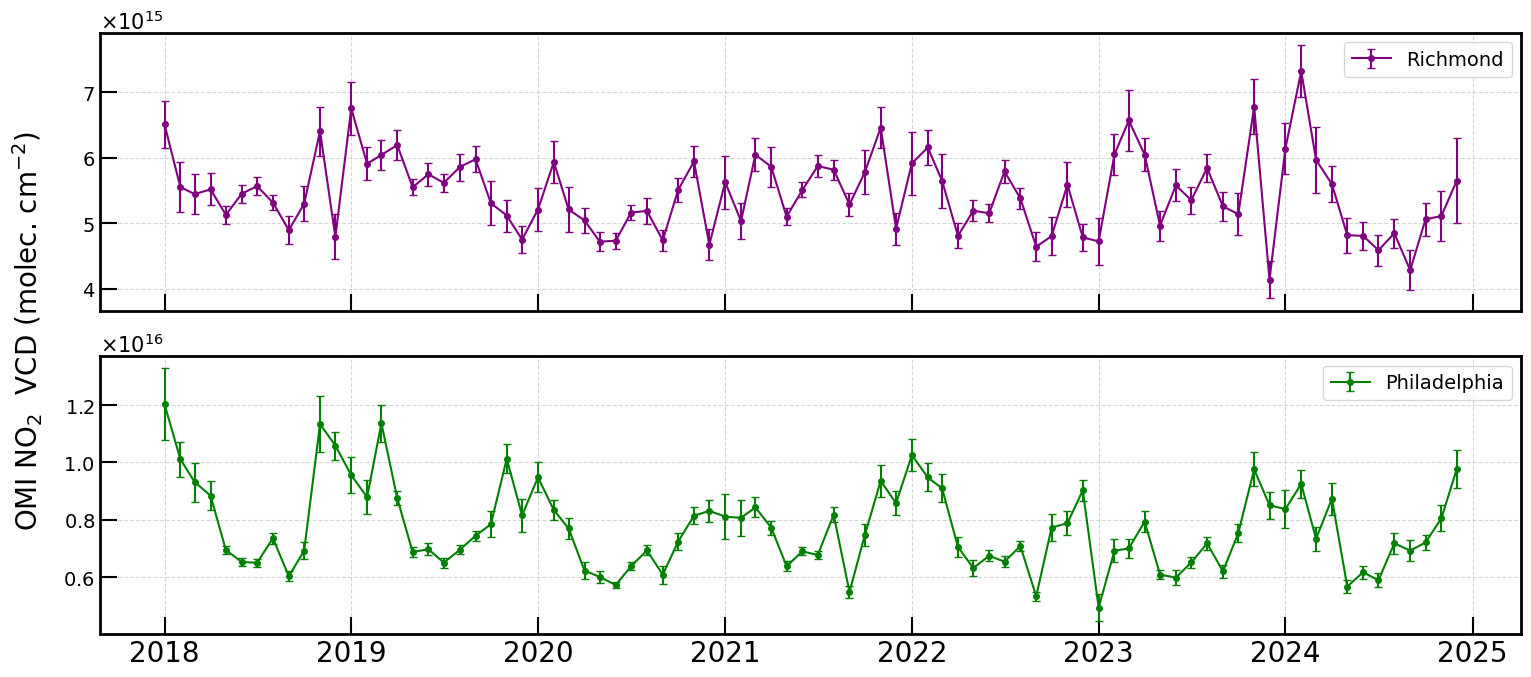

In [79]:
city_dfs = {
    "Richmond": richmond_city_summary,
    "Philadelphia": philadelphia_city_summary,
}

fig, axes = plt.subplots(2, 1, figsize=(15, 7))  
col = 1

for ax, (city_name, city_df) in zip(axes, city_dfs.items()):
    city_summary = city_df.toPandas() # reverting back to pandas for matplotlib integration
    city_summary["year_month"] = pd.to_datetime(city_summary["year_month"])
    color = city_and_colors[city_name]

    ax.errorbar(
        city_summary["year_month"],
        city_summary["mean"],
        yerr=city_summary["std_error"],
        fmt="o-", 
        capsize=3, 
        markersize=4,
        color=color,
        label=city_name
    )
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()
    if col != 2:
        plt.setp(ax.get_xticklabels(), visible=False)

    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_lw(2)
    ax.tick_params(which='minor', width=.8)
    ax.tick_params(which='major', width=1.5)
    ax.tick_params(which='major', length=12)
    ax.tick_params(which='minor', length=6.5)
    ax.tick_params(which = 'both', direction = 'in')
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='scientific', axis = 'y') 
    t = ax.yaxis.get_offset_text()
    t.set_size(15)
    col += 1

fig.text(-0.01, 0.512, 'OMI NO$_2$  VCD (molec. $\mathregular{cm^{-2}}$)', ha='center', va='center', rotation='vertical', fontsize = 20)
plt.subplots_adjust(bottom=0.1, hspace=-1, wspace=-0.3)  
plt.tight_layout()
plt.show()

<b> Let's compare the monthly average NO2 for all cities for 2019, 2020, and 2021.

In [80]:
from pyspark.sql.functions import substring

def get_monthly_value_for_3_years(spark_dataframe, city_name):
    '''
    Given a spark dataframe and city name, this function will return the monthly values for the given city.
    '''
    filtered_df = spark_dataframe.filter(
        F.col("year_month").isin(["2019-03", "2019-04", "2019-05", 
                                 "2020-03", "2020-04", "2020-05",
                                 "2021-03", "2021-04", "2021-05"])
    )
    
    # get year and month from year-month using slicing the string
    filtered_df = filtered_df.withColumn("year", substring("year_month", 1, 4)) \
                         .withColumn("month", substring("year_month", 6, 2))

    filtered_df = filtered_df.groupBy("year").pivot("month").agg(F.first("mean")).orderBy("year")
    filtered_df = filtered_df.withColumnRenamed("year", f"Year ({city_name})")
    return filtered_df

In [81]:
baltimore_city_summary = get_monthly_value_for_3_years(baltimore_city_summary, "Baltimore")
print(baltimore_city_summary.show())

+----------------+--------------------+--------------------+--------------------+
|Year (Baltimore)|                  03|                  04|                  05|
+----------------+--------------------+--------------------+--------------------+
|            2019|9.418311177421268E15|7.928413953545557E15|6.354189448662725E15|
|            2020|7.331136017830473E15|5.599459870423345E15|5.034874480671279E15|
|            2021| 7.29549172087988E15|6.795088120949419E15|5.909344705052672E15|
+----------------+--------------------+--------------------+--------------------+

None


In [82]:
washingtonDC_city_summary = get_monthly_value_for_3_years(washingtonDC_city_summary, "Washington DC")
print(washingtonDC_city_summary.show())

+--------------------+--------------------+--------------------+--------------------+
|Year (Washington DC)|                  03|                  04|                  05|
+--------------------+--------------------+--------------------+--------------------+
|                2019|1.026567031991828...|8.117745350606848E15|6.010647329943435E15|
|                2020|6.854541888123266E15|6.029382921218614E15| 5.00949339783733E15|
|                2021|7.490342244548146E15|7.043635527913874E15|5.514093607957576E15|
+--------------------+--------------------+--------------------+--------------------+

None


In [83]:
richmond_city_summary = get_monthly_value_for_3_years(richmond_city_summary, "Richmond")
print(richmond_city_summary.show())

+---------------+--------------------+--------------------+--------------------+
|Year (Richmond)|                  03|                  04|                  05|
+---------------+--------------------+--------------------+--------------------+
|           2019|6.044684956172957E15|6.195424514843607E15|5.550297764768427E15|
|           2020|5.210141477568512E15|5.042064911761408E15|4.718381200234166E15|
|           2021| 6.04745454583808E15|5.864383383610038E15|5.100400864058222E15|
+---------------+--------------------+--------------------+--------------------+

None


In [84]:
philadelphia_city_summary = get_monthly_value_for_3_years(philadelphia_city_summary, "Philadelphia")
print(philadelphia_city_summary.show())

+-------------------+--------------------+--------------------+--------------------+
|Year (Philadelphia)|                  03|                  04|                  05|
+-------------------+--------------------+--------------------+--------------------+
|               2019|1.136701088624760...|8.750736764197466E15|6.878533656658907E15|
|               2020|7.696638492890453E15|6.227301637292032E15|6.005477637054033E15|
|               2021|8.433521691298265E15|7.726886978085657E15|6.381291746272103E15|
+-------------------+--------------------+--------------------+--------------------+

None


In [85]:
newyork_city_summary = get_monthly_value_for_3_years(newyork_city_summary, "New York City")
print(newyork_city_summary.show())

+--------------------+--------------------+--------------------+--------------------+
|Year (New York City)|                  03|                  04|                  05|
+--------------------+--------------------+--------------------+--------------------+
|                2019|1.513335507850737...|1.199201143758236E16|7.760381773796756E15|
|                2020|9.009616153496038E15|7.719058855235857E15|6.290899802506534E15|
|                2021|1.052455730431577...|1.003212075929893...|7.563603453744405E15|
+--------------------+--------------------+--------------------+--------------------+

None


If we look here, for each city's corresponding monthly value from 2019-2020 is down significantly whereas from 2020-2021, it has increased representing the recovery of NO2 pollution in 2021.

In [86]:
def get_percentage_change(spark_dataframe, city: str) -> pd.DataFrame: 
    pandas_df = spark_dataframe.toPandas().set_index(f"Year ({city})")
    pandas_df = pandas_df[["03","04","05"]].pct_change() * 100
    return pandas_df

In [87]:
get_percentage_change(baltimore_city_summary, "Baltimore").rename(columns={"03": "March", "04": "April", "05": "May"})

March      April        May
Year (Baltimore)                                 
2019                    NaN        NaN        NaN
2020             -22.160822 -29.374779 -20.762915
2021              -0.486204  21.352564  17.368263

In [88]:
get_percentage_change(washingtonDC_city_summary, "Washington DC").rename(columns={"03": "March", "04": "April", "05": "May"})

March      April        May
Year (Washington DC)                                 
2019                        NaN        NaN        NaN
2020                 -33.228502 -25.725892 -16.656341
2021                   9.275607  16.821831  10.072879

In [89]:
get_percentage_change(richmond_city_summary, "Richmond").rename(columns={"03": "March", "04": "April", "05": "May"})

March      April        May
Year (Richmond)                                 
2019                   NaN        NaN        NaN
2020            -13.806236 -18.616313 -14.988683
2021             16.070832  16.309161   8.096414

In [90]:
get_percentage_change(philadelphia_city_summary, "Philadelphia").rename(columns={"03": "March", "04": "April", "05": "May"})

March      April        May
Year (Philadelphia)                                 
2019                       NaN        NaN        NaN
2020                -32.289688 -28.836830 -12.692473
2021                  9.574091  24.080821   6.257855

In [91]:
get_percentage_change(newyork_city_summary, "New York City").rename(columns={"03": "March", "04": "April", "05": "May"})

March      April        May
Year (New York City)                                 
2019                        NaN        NaN        NaN
2020                 -40.465177 -35.631659 -18.935692
2021                  16.814714  29.965595  20.230868

If we look here, for each city's corresponding monthly value from 2019-2020 is down significantly whereas from 2020-2021, it has increased representing the recovery of NO2 pollution in 2021.

<b> Let's create a barplot that shows yearly average NO2 for each city.

In [92]:
baltimore_spark_df.show(5)

+-------------------+----+-----+---+----------+---------+--------------------+
|               date|year|month|day|year_month|  dayname|     ColumnAmountNO2|
+-------------------+----+-----+---+----------+---------+--------------------+
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|  Tuesday|7.739732930854912E15|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|  Tuesday| 5.15592301838336E15|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|  Tuesday|4.500884671168512E15|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|  Tuesday|5.594668423184384E15|
|2018-01-03 00:00:00|2018|    1|  3|   2018-01|Wednesday| 1.30681627738112E16|
+-------------------+----+-----+---+----------+---------+--------------------+
only showing top 5 rows



In [93]:
from pyspark.sql.functions import col, lit

In [94]:
# compute yearly average for each city from 2018-2024
baltimore_yearly_average = baltimore_spark_df.groupBy("year").agg(F.mean("ColumnAmountNO2").alias("yearly_mean")).orderBy(F.asc("year"))
baltimore_yearly_average = baltimore_yearly_average.withColumn("city", lit("Baltimore"))

In [95]:
baltimore_yearly_average.show()

+----+--------------------+---------+
|year|         yearly_mean|     city|
+----+--------------------+---------+
|2018|6.999369116294466E15|Baltimore|
|2019|6.825789689163326E15|Baltimore|
|2020| 6.22786319221825E15|Baltimore|
|2021|6.958089628237598E15|Baltimore|
|2022|6.792614347300711E15|Baltimore|
|2023|6.765537641583771E15|Baltimore|
|2024| 6.38984017502738E15|Baltimore|
+----+--------------------+---------+



In [96]:
# lets calculate for other cities
richmond_yearly_average = richmond_spark_df.groupBy("year").agg(F.mean("ColumnAmountNO2").alias("yearly_mean")).orderBy(F.asc("year"))
richmond_yearly_average = richmond_yearly_average.withColumn("city", lit("Richmond"))

philadelphia_yearly_average = philadelphia_spark_df.groupBy("year").agg(F.mean("ColumnAmountNO2").alias("yearly_mean")).orderBy(F.asc("year"))
philadelphia_yearly_average = philadelphia_yearly_average.withColumn("city", lit("Philadelphia"))

newyork_yearly_average = newyork_spark_df.groupBy("year").agg(F.mean("ColumnAmountNO2").alias("yearly_mean")).orderBy(F.asc("year"))
newyork_yearly_average = newyork_yearly_average.withColumn("city", lit("New York City"))

washington_yearly_average = washington_spark_df.groupBy("year").agg(F.mean("ColumnAmountNO2").alias("yearly_mean")).orderBy(F.asc("year"))
washington_yearly_average = washington_yearly_average.withColumn("city", lit("Washington D.C"))

In [97]:
from functools import reduce
from pyspark.sql import DataFrame

dataframes = [
    baltimore_yearly_average,
    richmond_yearly_average,
    philadelphia_yearly_average,
    newyork_yearly_average,
    washington_yearly_average
]

# combining all dataframes (equivalent to pd.concat([df1, df2, df3]))
dataframes = reduce(DataFrame.unionAll, dataframes)
dataframes.show(10)

+----+--------------------+---------+
|year|         yearly_mean|     city|
+----+--------------------+---------+
|2018|6.999369116294466E15|Baltimore|
|2019|6.825789689163326E15|Baltimore|
|2020| 6.22786319221825E15|Baltimore|
|2021|6.958089628237598E15|Baltimore|
|2022|6.792614347300711E15|Baltimore|
|2023|6.765537641583771E15|Baltimore|
|2024| 6.38984017502738E15|Baltimore|
|2018| 5.49862190854329E15| Richmond|
|2019|5.692822893352469E15| Richmond|
|2020|5.140383139142621E15| Richmond|
+----+--------------------+---------+
only showing top 10 rows



In [98]:
city_yearly_df = dataframes.toPandas()

In [99]:
city_yearly_df.head()

year   yearly_mean       city
0  2018  6.999369e+15  Baltimore
1  2019  6.825790e+15  Baltimore
2  2020  6.227863e+15  Baltimore
3  2021  6.958090e+15  Baltimore
4  2022  6.792614e+15  Baltimore

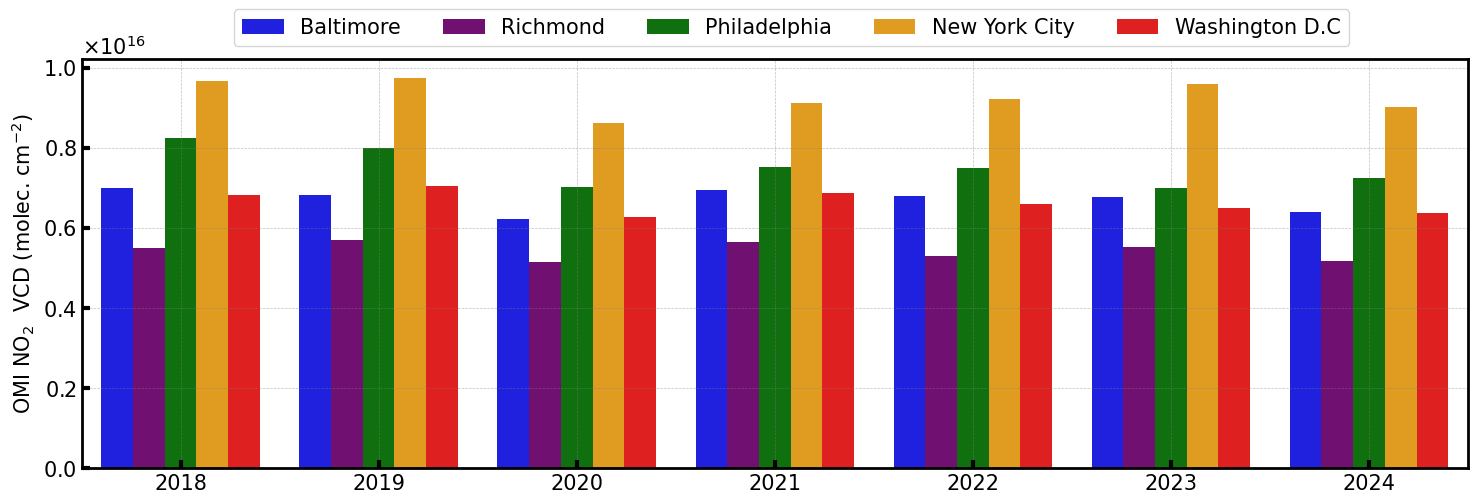

In [100]:
cities_ordered = city_yearly_df['city'].unique()
palette = [city_and_colors[city] for city in cities_ordered]

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=city_yearly_df, x="year", y="yearly_mean", hue="city", ax=ax, palette=palette)
ax.set_ylabel('OMI NO$_2$  VCD (molec. $\mathregular{cm^{-2}}$)', fontsize=15)
ax.set_xlabel('')
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

ax.tick_params(labelsize=15)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['left'].set_lw(2) 
ax.tick_params(which='both', width=3)
ax.tick_params(which='major', length=6)
ax.grid(True, linestyle="--", alpha=0.5)
ax.tick_params(which='minor', length=6)
ax.tick_params(which = 'both', direction = 'in')
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='scientific', axis = 'y') 
t = ax.yaxis.get_offset_text()
t.set_size(15)

handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()  
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.535, 1.03),  ncol=5,  fontsize=15,  frameon=True)  

plt.tight_layout()  
plt.show()

<b> Lets look at weekly pattern for New York City. 

In [101]:
newyork_spark_df.show(5)

+-------------------+----+-----+---+----------+-------+--------------------+
|               date|year|month|day|year_month|dayname|     ColumnAmountNO2|
+-------------------+----+-----+---+----------+-------+--------------------+
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|1.520586356005273...|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday| 7.82990791671808E15|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|1.809719903649792E16|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|7.438694378110976E15|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|1.389325390866022...|
+-------------------+----+-----+---+----------+-------+--------------------+
only showing top 5 rows



In [102]:
from pyspark.sql import functions as F

day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

In [103]:
'''
This is the mapping format to sort the dataframe based on day names. For instance, Monday is assigned 1, Tuesday as 2 and Sunday as 7.
So, when we do ascending order, our dataframe becomes Monday to Saturday
'''

mapping_expr = F.create_map(
    *sum(
        ([F.lit(d), F.lit(i+1)] for i, d in enumerate(day_order)),
        []
    )
)
mapping_expr

Column<'map(Monday, 1, Tuesday, 2, Wednesday, 3, Thursday, 4, Friday, 5, Saturday, 6, Sunday, 7)'>

In [104]:
weekday_averages = (
    newyork_spark_df
      .groupBy("dayname")
      .agg(F.mean("ColumnAmountNO2").alias("ColumnAmountNO2"))
      .withColumn("sort_order", mapping_expr[F.col("dayname")])
      .orderBy("sort_order")
      .drop("sort_order") # don't need this column anymore; only used to sort based on day names
)

weekday_averages.show()

+---------+--------------------+
|  dayname|     ColumnAmountNO2|
+---------+--------------------+
|   Monday|9.154675971124548E15|
|  Tuesday|9.600606284692308E15|
|Wednesday|1.020543889645855...|
| Thursday|9.652670845771842E15|
|   Friday| 1.04532493869349E16|
| Saturday|7.984665537176087E15|
|   Sunday|7.734370694739485E15|
+---------+--------------------+



In [105]:
# checking if a day is weekend or not
weekday_averages = weekday_averages.withColumn("is_weekend", col("dayname").isin("Saturday", "Sunday").cast("integer"))

In [106]:
weekday_averages.show()

+---------+--------------------+----------+
|  dayname|     ColumnAmountNO2|is_weekend|
+---------+--------------------+----------+
|   Monday|9.154675971124548E15|         0|
|  Tuesday|9.600606284692308E15|         0|
|Wednesday|1.020543889645855...|         0|
| Thursday|9.652670845771842E15|         0|
|   Friday| 1.04532493869349E16|         0|
| Saturday|7.984665537176087E15|         1|
|   Sunday|7.734370694739485E15|         1|
+---------+--------------------+----------+



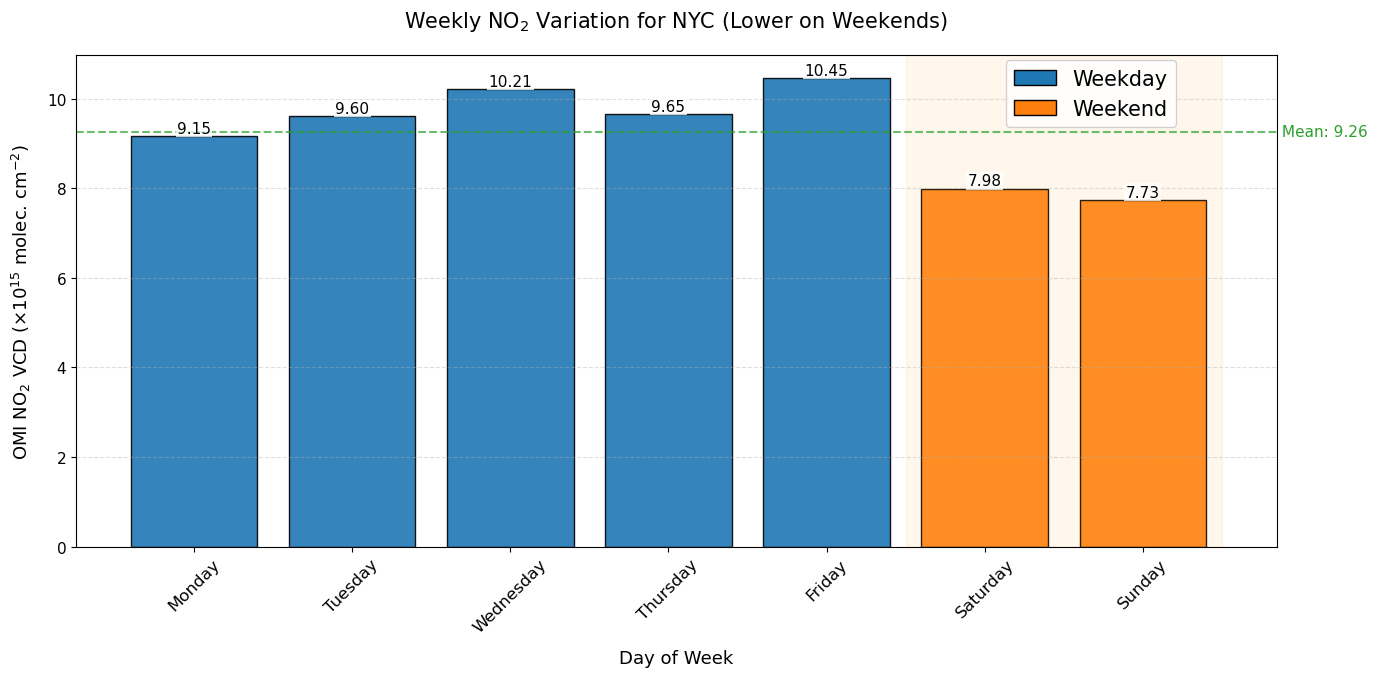

In [107]:
plt.figure(figsize=(14, 7))

weekday_averages = weekday_averages.toPandas() # reverting back to pandas for matplotlib integration
colors = ['#1f77b4' if not weekend else '#ff7f0e' for weekend in weekday_averages['is_weekend']]
bars = plt.bar(
    weekday_averages['dayname'],
    weekday_averages['ColumnAmountNO2'] / 1e15,
    color=colors,
    edgecolor='black',
    linewidth=1,
    alpha=0.9
)

plt.title('Weekly NO$_2$ Variation for NYC (Lower on Weekends)', 
          fontsize=15, pad=20, fontweight='normal')
plt.xlabel('Day of Week', fontsize=13, labelpad=10)
plt.ylabel('OMI NO$_2$ VCD ($\\times10^{15}$ molec. $\mathregular{cm^{-2}}$)', 
           fontsize=13, labelpad=10)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=11)

plt.axvspan(4.5, 6.5, color='orange', alpha=0.08, label='Weekend')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=11,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))

weekday_patch = plt.Rectangle((0,0),1,1, fc='#1f77b4', edgecolor='black')
weekend_patch = plt.Rectangle((0,0),1,1, fc='#ff7f0e', edgecolor='black')
plt.legend([weekday_patch, weekend_patch], ['Weekday', 'Weekend'], 
           frameon=True, framealpha=0.9, fontsize=15, loc='upper right',
           bbox_to_anchor=(0.925, 1.01))

overall_mean = (weekday_averages['ColumnAmountNO2'].mean()) / 1e15
plt.axhline(y=overall_mean, color='#2ca02c', linestyle='--', linewidth=1.5, alpha=0.7)
plt.text(6.85, overall_mean, f' Mean: {overall_mean:.2f}', 
         va='center', ha='left', color='#2ca02c', fontsize=11)

plt.tight_layout()
plt.show()

In [108]:
def assign_season(month: int):
    '''
    Given a month, this function will return the season for that month.
    '''
    if month in [12, 1, 2]:
        return "DJF"
    elif month in [3, 4, 5]:
        return "MAM"
    elif month in [6, 7, 8]:
        return "JJA"
    elif month in [9, 10, 11]:
        return "SON"

In [109]:
geopandas_df["season"] = geopandas_df["month"].apply(assign_season)

In [110]:
def get_monthly_average_spatial(local_df: gpd.GeoDataFrame, season: str) -> gpd.GeoDataFrame:
    '''
    Given a local dataframe and season, this function will return the monthly average for the given season.
    '''
    local_df = local_df[local_df["season"] == season]
    result = fishnet_x[["ID", "geometry"]].sjoin(local_df, predicate = 'intersects')
    fishnet_x[season]  = get_ordered_dict(dict(result.groupby('ID', dropna = False)['ColumnAmountNO2'].mean()), fishnet_x['ID'])

In [111]:
%%time

get_monthly_average_spatial(geopandas_df, "DJF")

CPU times: total: 3.16 s
Wall time: 5.13 s


In [112]:
%%time

get_monthly_average_spatial(geopandas_df, "MAM")

CPU times: total: 5.83 s
Wall time: 7.83 s


In [113]:
%%time

get_monthly_average_spatial(geopandas_df, "JJA")

CPU times: total: 8.41 s
Wall time: 12 s


In [114]:
%%time

get_monthly_average_spatial(geopandas_df, "SON")

CPU times: total: 5.09 s
Wall time: 7.22 s


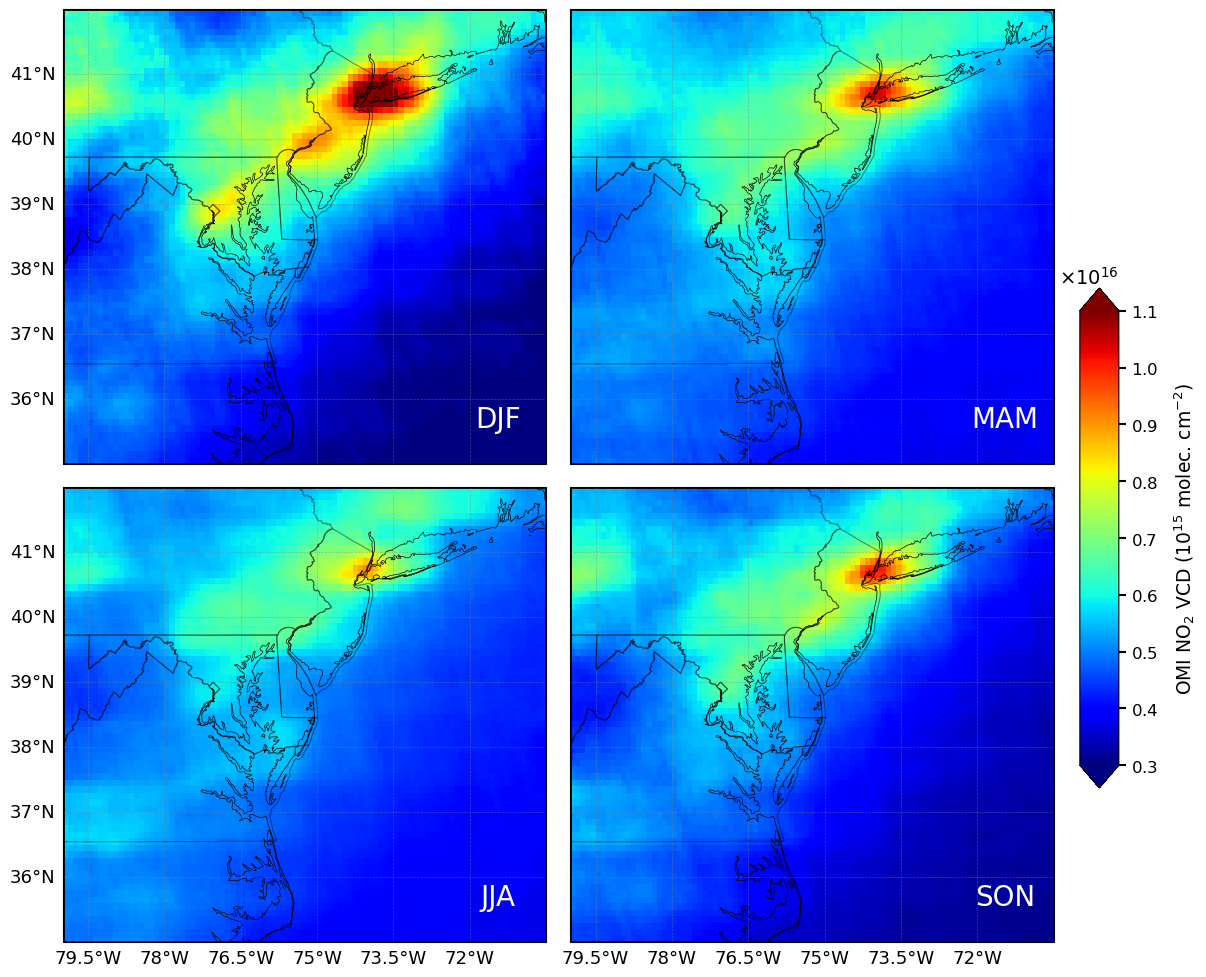

In [115]:
vmin = 3e+15
vmax = 11e+15
cmap = "jet"
alpha = 1

plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(2, 2, figsize=(13, 10), 
                        subplot_kw={"projection": ccrs.PlateCarree()})
columns = ['DJF', 'MAM', "JJA", "SON"]
current_col = 0

for ax, col in zip(axes.ravel(), columns):
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    if current_col not in [0, 2]:
        gl.left_labels = False

    if current_col not in [2, 3]:
        gl.bottom_labels = False
    
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}

    
    bounding_box.geometry.boundary.plot(ax=ax, color='black', linewidth=2, alpha=1, transform=ccrs.PlateCarree())
    us_states.geometry.boundary.plot(ax=ax, color='black', linewidth=0.75, alpha=0.45, transform=ccrs.PlateCarree())

    fishnet_x.plot(ax=ax, column=col, alpha=alpha, linewidth=0, edgecolor=None, cmap=cmap,
                   missing_kwds=dict(color='grey', label='No Data'), vmin=vmin, vmax=vmax, legend=False)
    
    ax.annotate(col, xy=(0.9, 0.1), xycoords='axes fraction', fontsize=20, ha='center', va='center', color="white", fontweight="normal")

    ax.tick_params(labelsize=20)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_lw(2) 
    ax.tick_params(which='both', width=3)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=6)
    ax.tick_params(which = 'both', direction = 'in')
    current_col += 1

cax = fig.add_axes([0.905, 0.2, 0.03, 0.5])  
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='vertical', extend='both')
cbar.set_label('OMI NO$_2$ VCD ($10^{15}$ molec. $\mathregular{cm^{-2}}$)', 
               fontsize=13.5, labelpad=10, fontweight='normal')
cbar.ax.tick_params(length=5, width=1.5, which="major", direction='out', labelsize=12)
cbar.set_alpha(alpha)
cbar.draw_all()
cbar.formatter.set_useMathText(True)
plt.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=-0.315)  
plt.show()  

If we look at this plot, we see that NO2 pollution is very high during winter and less during summer season. During winter, people use more fossil fuel for heating their homes, their cars, buildings, and the cold traps NO2 and prevents it from reacting with sun and that way, less NO2 converts to Ozone. In summer, more sunglight leads to faster/higher NO2 conversion to ozone. This is a very important pattern of NO2. Lets look for each month by calculating monthly average. We should see similar pattern.

In [116]:
newyork_spark_df.show(5)

+-------------------+----+-----+---+----------+-------+--------------------+
|               date|year|month|day|year_month|dayname|     ColumnAmountNO2|
+-------------------+----+-----+---+----------+-------+--------------------+
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|1.520586356005273...|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday| 7.82990791671808E15|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|1.809719903649792E16|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|7.438694378110976E15|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|1.389325390866022...|
+-------------------+----+-----+---+----------+-------+--------------------+
only showing top 5 rows



In [117]:
from pyspark.sql.functions import when, col

In [118]:
# extracting season based on month
newyork_spark_df = newyork_spark_df.withColumn(
    "season",
    when(col("month").isin(12, 1, 2), "Winter")
    .when(col("month").between(3, 5),  "Spring")
    .when(col("month").between(6, 8),  "Summer")
    .otherwise("Fall")
)

In [119]:
newyork_spark_df.show(10)

+-------------------+----+-----+---+----------+-------+--------------------+------+
|               date|year|month|day|year_month|dayname|     ColumnAmountNO2|season|
+-------------------+----+-----+---+----------+-------+--------------------+------+
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|1.520586356005273...|Winter|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday| 7.82990791671808E15|Winter|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|1.809719903649792E16|Winter|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|7.438694378110976E15|Winter|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|1.389325390866022...|Winter|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|6.900511353602048E15|Winter|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|1.254613849001164...|Winter|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|1.221634727870464E16|Winter|
|2018-01-02 00:00:00|2018|    1|  2|   2018-01|Tuesday|7.559945599844352E15|

In [120]:
newyork_PDF = newyork_spark_df.toPandas() 

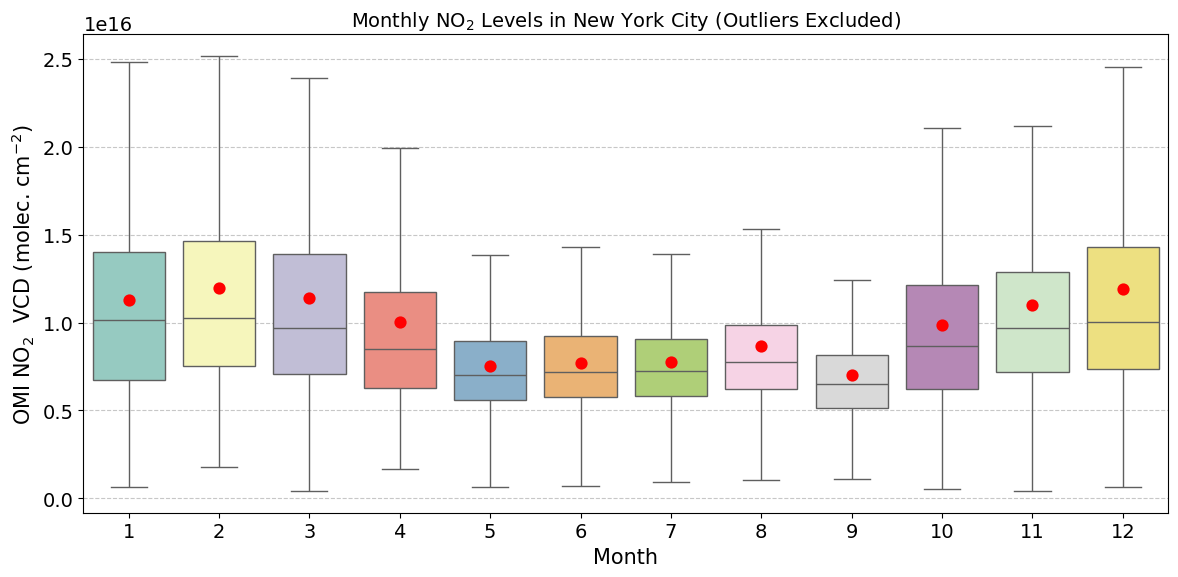

In [121]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=newyork_PDF, x="month", y="ColumnAmountNO2", palette="Set3", showfliers=False)
sns.pointplot(data=newyork_PDF, x="month", y="ColumnAmountNO2", color="red", markers="o", linestyles="", ci=None, estimator=np.mean)
plt.title("Monthly NO$_2$ Levels in New York City (Outliers Excluded)", fontsize=14)
plt.xlabel("Month", fontsize=15)
plt.ylabel('OMI NO$_2$  VCD (molec. $\mathregular{cm^{-2}}$)', fontsize=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
ax.tick_params(labelsize=20)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['left'].set_lw(2) 
ax.tick_params(which='both', width=3)
ax.tick_params(which='major', length=6)
ax.grid(True, linestyle="--", alpha=0.5)
ax.tick_params(which='minor', length=6)
ax.tick_params(which = 'both', direction = 'in')
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='scientific', axis = 'y') 
t = ax.yaxis.get_offset_text()
t.set_size(15)
plt.tight_layout()
plt.show()

## 3.2 NO2 Pollution and Traffic Frequency Relation

For the Traffic Station Hourly Vehicle count data, we can download these from Federal Highway Administration data portal at: https://www.fhwa.dot.gov/policyinformation/tables/tmasdata/#y20.

The data is available for each month for Traffic stations accross the US highways at hourly level. These stations can be tolling stations, sensors on top of bridges, cameras etc. 

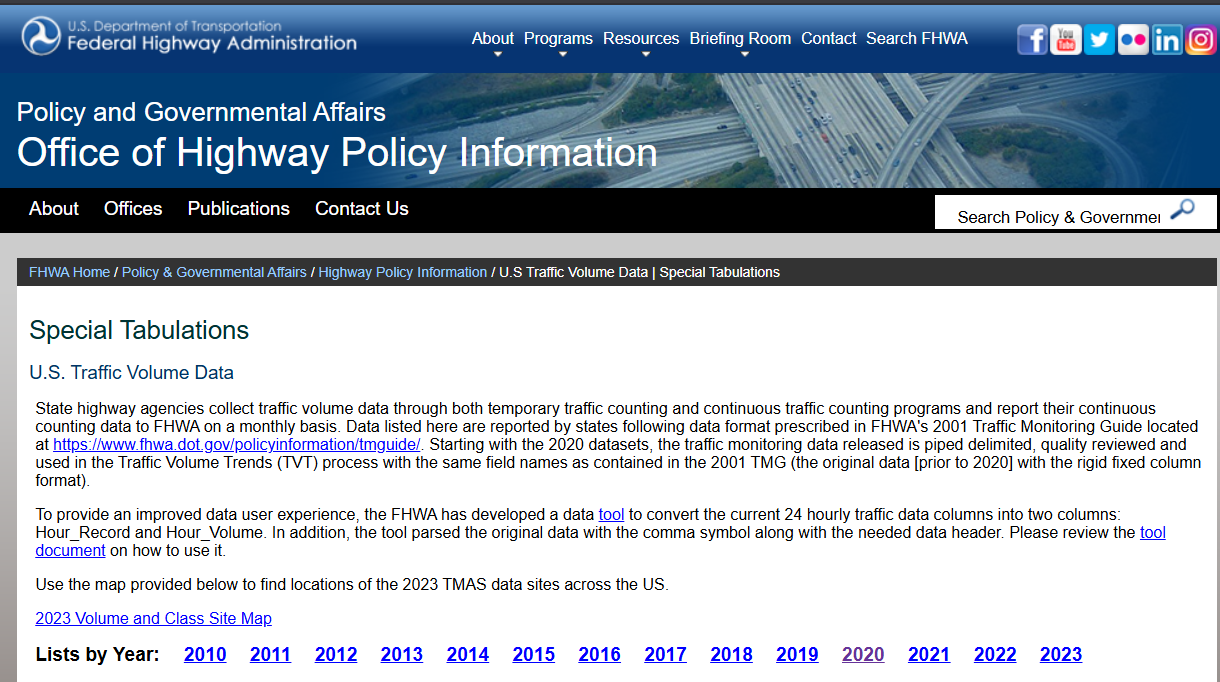

The data format looks like this:

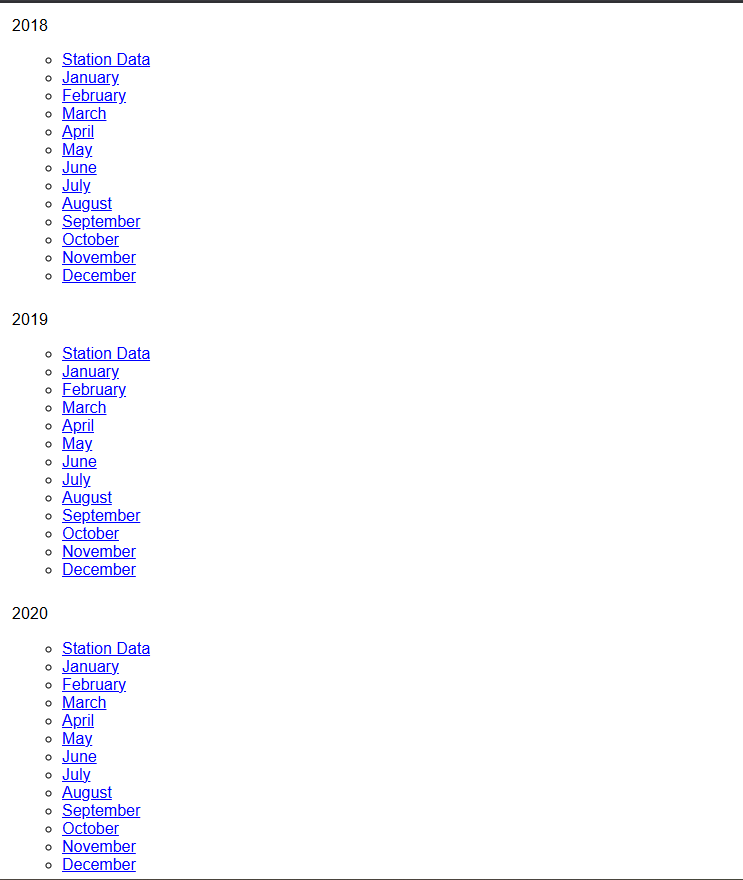

For each year, there is a distinct station data file, and data for each month. The station data file is a metadata file that contains location of stations, and their unique IDs, which can be joined to monthly file.

In [281]:
def process_station_data(filepath: str) :
    # reading the data using spark, doing some minor preprocessings
    station_data = spark.read.csv(filepath, sep="|", header=True, inferSchema=True)
    station_data = station_data.filter(station_data.Sample_Type_Volume == "T")
    station_data = station_data.withColumn("Latitude", col("Latitude") / 1000000)
    station_data = station_data.withColumn("Longitude", -col("Longitude") / 1000000)
    station_data = station_data.select(["Station_Id", "State_Code", "F_System", "Sample_Type_Volume", "Latitude", "Longitude", "County_Code", "Method_Volume"])
    station_data = station_data.toPandas()

    station_data["geometry"] = gpd.points_from_xy(station_data["Longitude"], station_data["Latitude"])
    station_data = gpd.GeoDataFrame(station_data, geometry="geometry", crs="EPSG:4326")  

    # only select the stations within the bounding box that is of interest to us
    station_data = gpd.sjoin(station_data, bounding_box, predicate="within")
    try:
        station_data.drop(columns=["index_right"], inplace=True)
    except:
        pass

    station_data.drop_duplicates(inplace=True)
    station_data.reset_index(drop=True, inplace=True)  
    return station_data

In [282]:
station_data_2019 = r"C:\Users\neupa\Downloads\Traffic Data\2019\Station_Data_Extract_Pipe_Delimited_CleanData_2019.txt"
station_data_2020 = r"C:\Users\neupa\Downloads\Traffic Data\2020\Station_Data_Extract_Pipe_Delimited_CleanData_2020.txt"
station_data_2021 = r"C:\Users\neupa\Downloads\Traffic Data\2021\Station_Data_Extract_Pipe_Delimited_CleanData_2021.txt"

station_data_2019 = process_station_data(station_data_2019)
station_data_2020 = process_station_data(station_data_2020)
station_data_2021 = process_station_data(station_data_2021)

In [283]:
station_data_2019

Station_Id  State_Code F_System Sample_Type_Volume   Latitude  Longitude  \
0        004108           9       2U                  T  41.544034 -73.033709   
1        004204           9       2U                  T  41.784930 -72.455197   
2        004347           9       2U                  T  41.372946 -72.430859   
3        004933           9       1U                  T  41.455102 -72.374396   
4        004934           9       1U                  T  41.454723 -72.380331   
...         ...         ...      ...                ...        ...        ...   
1934     840078          51       1R                  T  37.676000 -77.655860   
1935     880032          51       1R                  T  37.906020 -79.262630   
1936     890045          51       1R                  T  38.847860 -77.766100   
1937     980188          51       1R                  T  38.909970 -78.048930   
1938     980503          51       1R                  T  39.006450 -78.329380   

      County_Code  Method_Volume                    geometry  
0               5              2  POINT (-73.03371 41.54403)  
1              13              2   POINT (-72.4552 41.78493)  
2               3              2  POINT (-72.43086 41.37295)  
3               3              2    POINT (-72.3744 41.4551)  
4               3              2  POINT (-72.38033 41.45472)  
...           ...            ...                         ...  
1934           75              3    POINT (-77.65586 37.676)  
1935          163              3  POINT (-79.26263 37.90602)  
1936           61              3   POINT (-77.7661 38.84786)  
1937           61              3  POINT (-78.04893 38.90997)  
1938          187              3  POINT (-78.32938 39.00645)  

[1939 rows x 9 columns]

In [284]:
available_state_codes = station_data_2019["State_Code"].unique()

The monthly file contain hourly level vehicle count for each traffic station for number of vehicles (cars, trucks etc) that pass through it. This is daily data at hourly level. 
Each monthly folder contains individual files for each state. Concatenating everything becomes fairly large quickly. For instance, data files for all 50 states for 2020 is 1.07GB.

Up until 2020, the data files are stored in fixed-width format. Meaning, first few columns are metadata like station_id, date etc then, the remaining columns are hourly counts of traffic passing through the station. For this project, I have utilized data from 2019-2021 to see the trend of vehicle count versus NO2 pollution. 

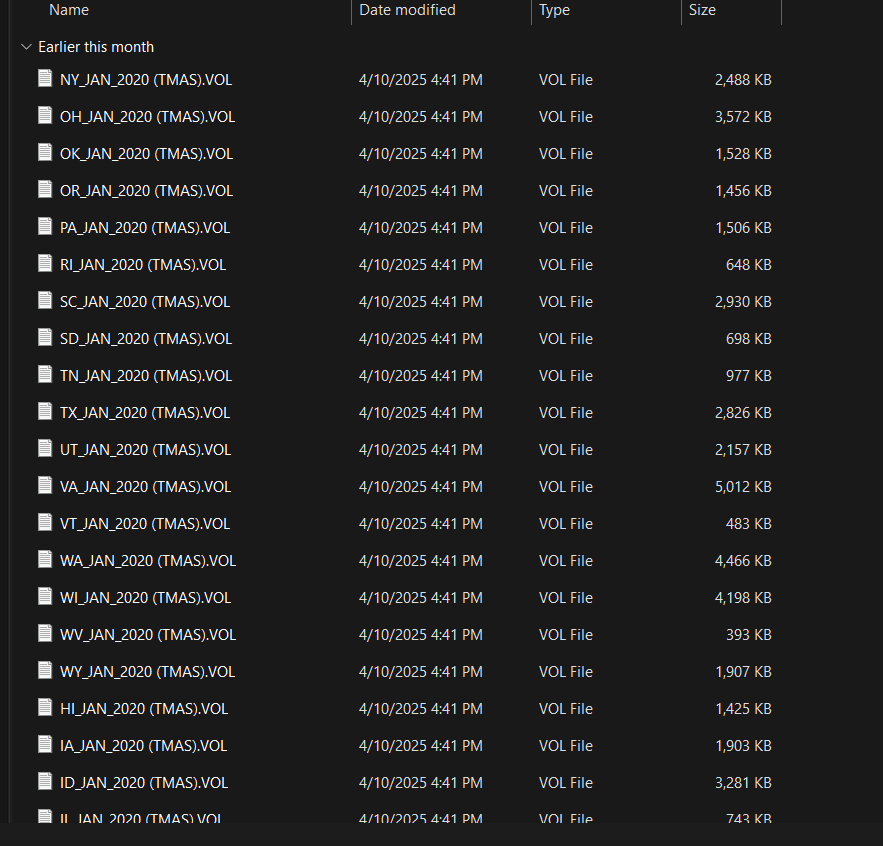

This is how the data for 2019/2020 looks like:

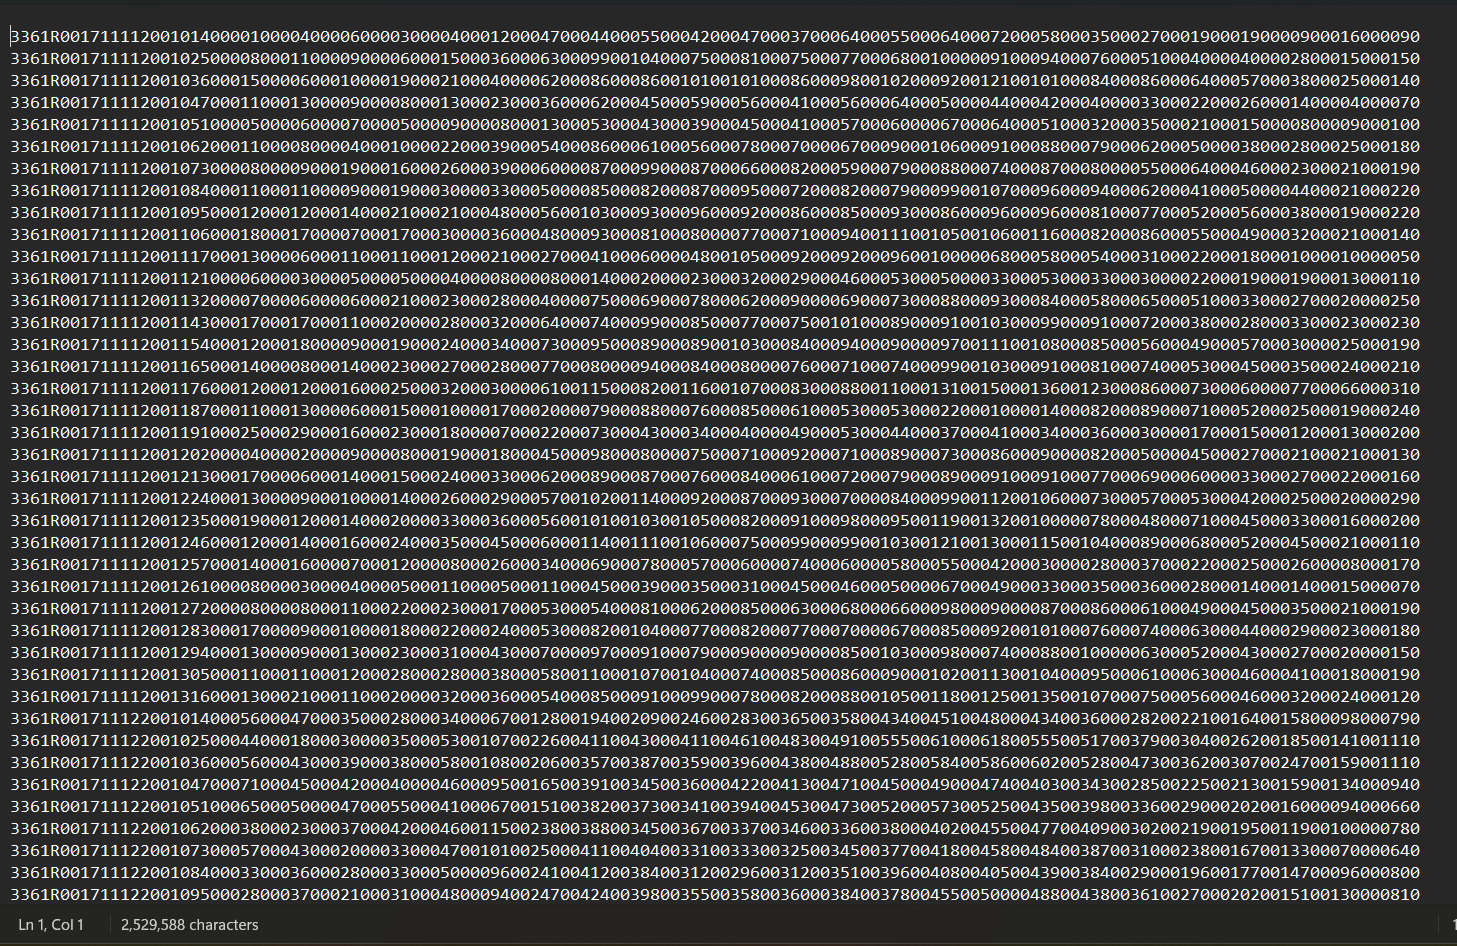

This is for 2021: 

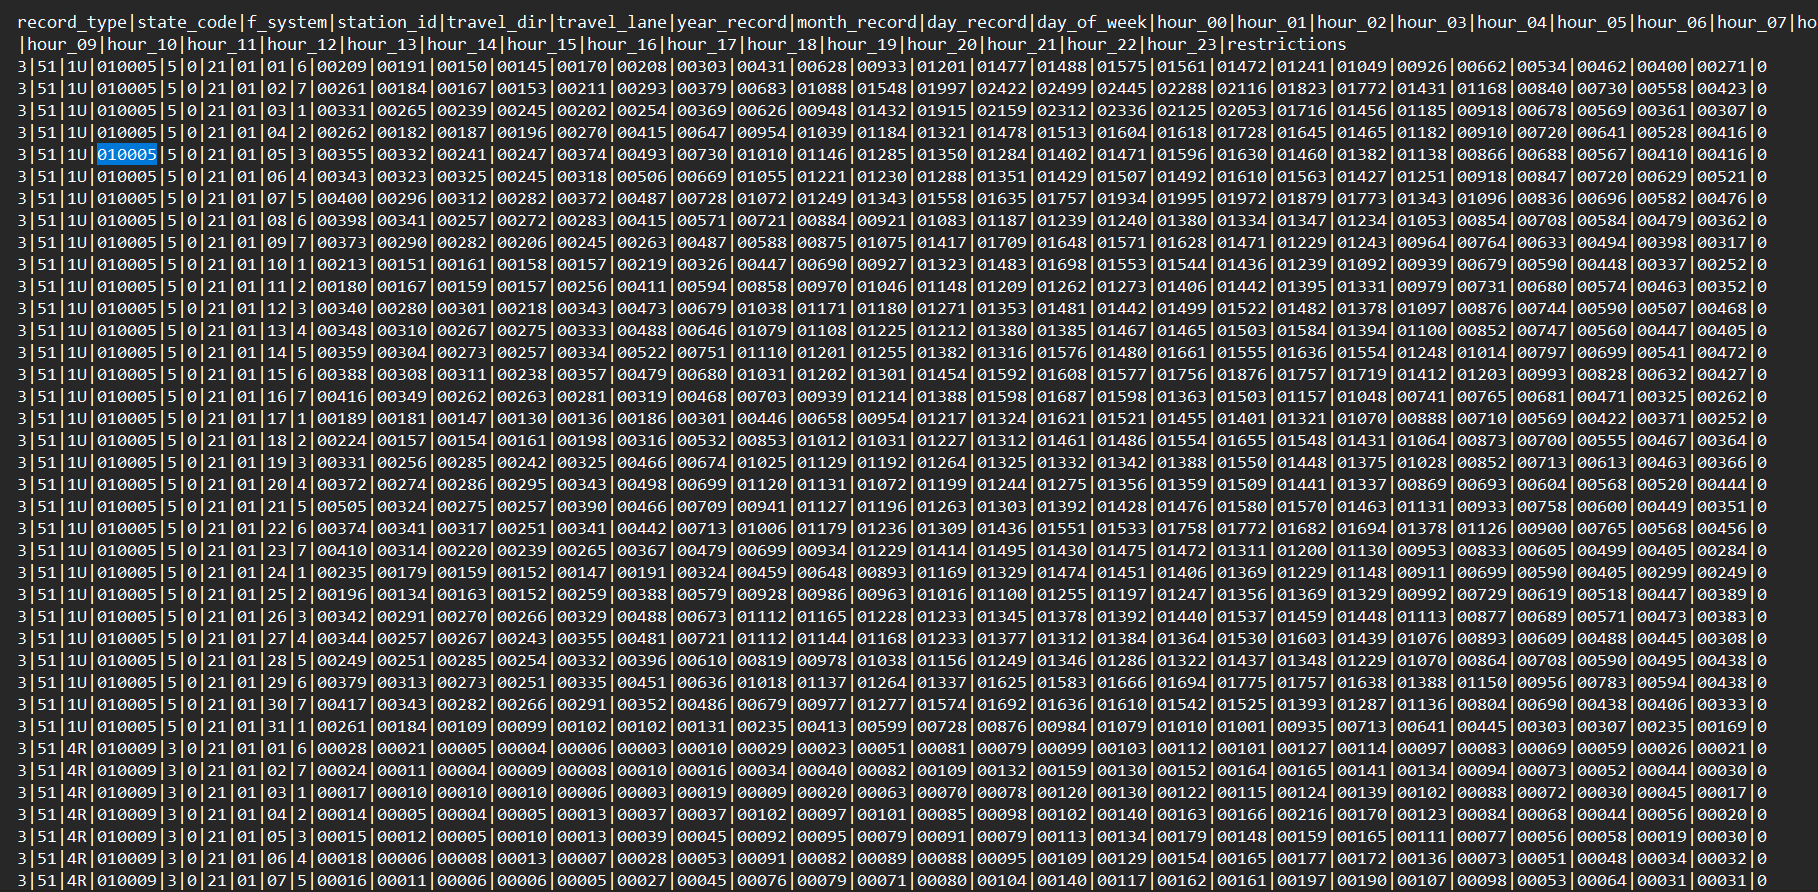

It is easy to work with data beyond 2020 as it is seperated by `|`. For 2019 and 2020, we need to do additional preprocessing to bring data to manageble state.

In [285]:
def process_data(filepath: str) -> pd.DataFrame:
    '''
    The hourly traffic frequency data is stored in a fixed-width format for years up to 2020. After 2020, the data is stored in seperated by |.
    Therefore, I will use this function to process data for 2019 and 2020. But, for 2021, I will directly use pd.read_csv() with sep = "|".
    '''
    widths = (
        [1, 2, 2, 6, 1, 1, 2, 2, 2, 1] +  # Metadata fields
        [5] * 24 +                         # 24 hourly counts (5 characters each)
        [1]                                # Restrictions field (optional)
    )

    col_names = (['record_type', 'state_code', 'functional_classification', 'station_id', 'direction_of_travel', 'lane_of_travel', 'year', 'month', 'day', 'day_of_week'] +
        [f'hour_{i:02d}' for i in range(24)] +  # Hourly counts from hour_00 to hour_23
        ['restrictions'] 
    )


    traffic_frequency_df = pd.read_fwf(filepath, widths=widths, header=None, names=col_names)
    traffic_frequency_df['year'] = traffic_frequency_df['year'].apply(lambda x: 2000 + int(x) if str(x).isdigit() else x)

    for col in [f'hour_{i:02d}' for i in range(24)]:
        traffic_frequency_df[col] = pd.to_numeric(traffic_frequency_df[col], errors='coerce')


    traffic_frequency_df = traffic_frequency_df[traffic_frequency_df.state_code.isin(available_state_codes)]

    useful_cols = [
        "station_id",
        "year",
        "month",
        "day",
        "day_of_week",
        ] + [
            f"hour_{i:02d}" for i in range(24)
    ]
    traffic_frequency_df = traffic_frequency_df[useful_cols]
    return traffic_frequency_df

In [286]:
def process_traffic_frequency_data_for_year(file_path: str) -> pd.DataFrame:
    '''
    Given a file path, this function will process the traffic frequency data for the given year.
    '''
    
    files = os.listdir(file_path)
    files = [os.path.join(file_path, file) for file in files]

    traffic_df = pd.DataFrame()

    for file in tqdm(files):
        temp_df = process_data(file)
        traffic_df = pd.concat([traffic_df, temp_df], ignore_index=True)

    traffic_df.reset_index(drop=True, inplace=True)

    return traffic_df

<B> Each year has 50 states and territories * 12 Months number of files, which is 600+ files. Reading through files and processing them takes ~5 minutes. Therefore, I used the function above to process files and then export them as parquet files for 2019 and 2020 for ease. You can download files and run the above function to process in case you want to test for other days. Since I will need to run this notebook multiple times (this project cannot be completed in one sitting), I will read the exported parquet file for ease.

In [287]:
# file_path = r"C:\Users\neupa\Downloads\Traffic Data\2019\Traffic_Frequency"
# traffic_df_2019 = process_traffic_frequency_data_for_year(file_path)
# traffic_df_2019["station_id"] = traffic_df_2019["station_id"].astype(str)
# traffic_df_2019.to_parquet("TrafficData_2019_EastCoast.parquet")

In [288]:
# file_path = r"C:\Users\neupa\Downloads\Traffic Data\2020\Traffic_Frequency"
# traffic_df_2020 = process_traffic_frequency_data_for_year(file_path)
# traffic_df_2020["station_id"] = traffic_df_2020["station_id"].astype(str)
# traffic_df_2020.to_parquet("TrafficData_2020_EastCoast.parquet")

In [289]:
# this is the column format
header = "record_type|state_code|f_system|station_id|travel_dir|travel_lane|year_record|month_record|day_record|day_of_week|hour_00|hour_01|hour_02|hour_03|hour_04|hour_05|hour_06|hour_07|hour_08|hour_09|hour_10|hour_11|hour_12|hour_13|hour_14|hour_15|hour_16|hour_17|hour_18|hour_19|hour_20|hour_21|hour_22|hour_23|restrictions"
header = header.split("|")
header = [col.strip() for col in header]

def read_traffic_file(file_path: str) -> pd.DataFrame:
    '''
    Given a file path, this function will read the traffic data for the given year.
    '''
    files = os.listdir(file_path)
    files = [os.path.join(file_path, file) for file in files]
    traffic_df = pd.DataFrame()    
    
    for file in tqdm(files):
        try:
            df = pd.read_csv(file, sep="|")
        except:
            df = pd.read_csv(file, sep="|", header=None, names=header)
        
        df = df[df.state_code.isin(available_state_codes)]
        traffic_df = pd.concat([traffic_df, df], ignore_index=True)

    traffic_df.reset_index(drop=True, inplace=True)
    traffic_df["station_id"] = traffic_df["station_id"].astype(str)
    return traffic_df

<b> The same applies to 2021 data. The only difference is that we already have data in seperated format. All we need to do is read them individually and concatenate them, which takes ~5 minutes. Therefore, for this year as well, I ran the function once and exported the dataframe as parquet file, and will read that file for ease.

In [290]:
# file_path = r"C:\Users\neupa\Downloads\Traffic Data\2021\Traffic_Frequency"
# traffic_df_2021 = read_traffic_file(file_path)
# traffic_df_2021.to_parquet("TrafficData_2021_EastCoast.parquet")

In [291]:
from pyspark.sql.types import IntegerType

In [292]:
traffic_df_2019 = spark.read.parquet(r"C:\Users\neupa\Downloads\Traffic Data\2019\TrafficData_2019_EastCoast.parquet")
traffic_df_2019 = traffic_df_2019.withColumnRenamed("station_id", "Station_Id")

In [293]:
traffic_df_2019.show(5)

+----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|Station_Id|year|month|day|day_of_week|hour_00|hour_01|hour_02|hour_03|hour_04|hour_05|hour_06|hour_07|hour_08|hour_09|hour_10|hour_11|hour_12|hour_13|hour_14|hour_15|hour_16|hour_17|hour_18|hour_19|hour_20|hour_21|hour_22|hour_23|
+----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      9007|2019|    1|  2|          4|  235.0|  164.0|  128.0|  144.0|  222.0|  391.0|  731.0|  910.0|  878.0|  828.0|  904.0|  894.0|  950.0| 1078.0| 1202.0| 1330.0| 1363.0| 1251.0|  876.0|  632.0|  562.0|  464.0|  344.0|  350.0|
|      9007|2019|    1|  3|          5|  226.0|  167.0|  144.0|  141.0| 

This is how our traffic frequency data looks like. Since we have station_id, we can join this with our station data.

In [294]:
traffic_df_2020 = spark.read.parquet(r"C:\Users\neupa\Downloads\Traffic Data\2020\TrafficData_2020_EastCoast.parquet")
traffic_df_2020 = traffic_df_2020.withColumnRenamed("station_id", "Station_Id")

In [296]:
traffic_df_2020.show()

+----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|Station_Id|year|month|day|day_of_week|hour_00|hour_01|hour_02|hour_03|hour_04|hour_05|hour_06|hour_07|hour_08|hour_09|hour_10|hour_11|hour_12|hour_13|hour_14|hour_15|hour_16|hour_17|hour_18|hour_19|hour_20|hour_21|hour_22|hour_23|
+----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      9024|2020|    4|  2|          5|  178.0|  128.0|  138.0|  162.0|  199.0|  324.0|  556.0|  655.0|  659.0|  614.0|  642.0|  708.0|  692.0|  746.0|  774.0|  865.0|  866.0|  788.0|  623.0|  502.0|  362.0|  271.0|  224.0|  229.0|
|      9024|2020|    4|  3|          6|  186.0|  125.0|  143.0|  166.0| 

In [297]:
traffic_df_2021 = spark.read.parquet(r"C:\Users\neupa\Downloads\Traffic Data\2021\TrafficData_2021_EastCoast.parquet")
traffic_df_2021 = traffic_df_2021.withColumnRenamed("station_id", "Station_Id")
traffic_df_2021.show(5)

+-----------+----------+--------+----------+----------+-----------+-----------+------------+----------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------+
|record_type|state_code|f_system|Station_Id|travel_dir|travel_lane|year_record|month_record|day_record|day_of_week|hour_00|hour_01|hour_02|hour_03|hour_04|hour_05|hour_06|hour_07|hour_08|hour_09|hour_10|hour_11|hour_12|hour_13|hour_14|hour_15|hour_16|hour_17|hour_18|hour_19|hour_20|hour_21|hour_22|hour_23|restrictions|
+-----------+----------+--------+----------+----------+-----------+-----------+------------+----------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------+
|          3|         9|      4R|    

If we look here, the year_record column is 21. The FHA seems to be keeping the number of years beyond 2000 to identify the year. So, we can add 2000 to this to bring it to the actual year value.

In [298]:
traffic_df_2021 = traffic_df_2021.withColumn("year_record", col("year_record").cast(IntegerType()))
traffic_df_2021 = traffic_df_2021.withColumn("year_record", col("year_record") + 2000)

In [299]:
traffic_df_2021.show(5)

+-----------+----------+--------+----------+----------+-----------+-----------+------------+----------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------+
|record_type|state_code|f_system|Station_Id|travel_dir|travel_lane|year_record|month_record|day_record|day_of_week|hour_00|hour_01|hour_02|hour_03|hour_04|hour_05|hour_06|hour_07|hour_08|hour_09|hour_10|hour_11|hour_12|hour_13|hour_14|hour_15|hour_16|hour_17|hour_18|hour_19|hour_20|hour_21|hour_22|hour_23|restrictions|
+-----------+----------+--------+----------+----------+-----------+-----------+------------+----------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------+
|          3|         9|      4R|    

Perfect. Now lets bring in EPA NO2 data.

<b> Why EPA? OMI NO2 is satellite measurement that is only available at daily level (not hourly level). Furthermore, each NO2 measurement is for almost 100KM square area. That is pretty big area by itself and trying to see how each traffic station is contributing to NO2 becomes very difficult to quantify as there will be way many NO2 sources besides traffic in that big of an area. 

EPA refers to Environmental Protection Agency. They have NO2 measurements through their network of ground based sensors. So, what I will do is, select a FHA station (or multiple), choose EPA NO2 sensors nearest to the FHA station, and compare traffic frequency with NO2. This is the closest we can do the comparision between Traffic and NO2 pollution in this project. Still, the FHA station counts the number of traffic passing through it. There can be multiple NO2 emitting sources nearby. And, i there are 2 FHA stations very close, a vehicle passing through both of them will be counted twice. Therefore, it is impossible to quantify the sole impact of traffic with respect to NO2 pollution in this project. However, it is a general estimate we can use to understand the relationship.

You can download EPA daily Hourly/Daily ground sensor-based NO2 data from their official website: https://aqs.epa.gov/aqsweb/airdata/download_files.html

In [147]:
from pyspark.sql.functions import col, substring

In [149]:
min_lat, max_lat, min_lon, max_lat

(35, 42, -80, 42)

In [189]:
from pyspark.sql.functions import hour

In [194]:
def process_EPA_NO2_data(filepath: str) -> pyspark.sql.DataFrame:
    '''
    Given a file path, this function will process the EPA NO2 data for the given year.
    '''
    epa_df = spark.read.csv(filepath, header=True, inferSchema=True)
    epa_df = epa_df.filter(col("State Code").isin(list(available_state_codes)))
    epa_df = epa_df.withColumn("Hour", hour("Time Local"))
    epa_df = epa_df.filter(col("Sample Measurement") >= 0)

    # spark is reading cordinates as double, but we need them as float
    epa_df = epa_df.withColumn("Latitude", col("Latitude").cast("float"))
    epa_df = epa_df.withColumn("Longitude", col("Longitude").cast("float"))

    # we only need EPA NO2 sensors for our bounding box
    epa_df = epa_df.filter(
        (col("Latitude") >= min_lat) & (col("Latitude") <= max_lat) &
        (col("Longitude") >= min_lon) & (col("Longitude") <= max_lon)
    )
    epa_df = epa_df.select(["Site Num", "Date Local", "Time Local", "Hour", "Date GMT", "Time GMT", "Latitude", "Longitude", "Sample Measurement"])
    return epa_df

In [195]:
epa_2020_path = r"C:\Users\neupa\Downloads\EPA_DATA\hourly_42602_2020.csv"
epa_2021_path = r"C:\Users\neupa\Downloads\EPA_DATA\hourly_42602_2021.csv"
epa_2019_path = r"C:\Users\neupa\Downloads\EPA_DATA\hourly_42602_2019.csv"

In [ ]:
epa_2020_spark_df = process_EPA_NO2_data(epa_2020_path)
epa_2021_spark_df = process_EPA_NO2_data(epa_2021_path) 
epa_2019_spark_df = process_EPA_NO2_data(epa_2019_path)

In [197]:
epa_2020_spark_df.show(5)

+--------+----------+-------------------+----+----------+-------------------+---------+---------+------------------+
|Site Num|Date Local|         Time Local|Hour|  Date GMT|           Time GMT| Latitude|Longitude|Sample Measurement|
+--------+----------+-------------------+----+----------+-------------------+---------+---------+------------------+
|    9003|2020-01-01|2025-04-21 00:00:00|   0|2020-01-01|2025-04-21 05:00:00|41.118332|-73.33667|               4.0|
|    9003|2020-01-01|2025-04-21 01:00:00|   1|2020-01-01|2025-04-21 06:00:00|41.118332|-73.33667|               3.5|
|    9003|2020-01-01|2025-04-21 02:00:00|   2|2020-01-01|2025-04-21 07:00:00|41.118332|-73.33667|               3.4|
|    9003|2020-01-01|2025-04-21 03:00:00|   3|2020-01-01|2025-04-21 08:00:00|41.118332|-73.33667|               3.1|
|    9003|2020-01-01|2025-04-21 04:00:00|   4|2020-01-01|2025-04-21 09:00:00|41.118332|-73.33667|               2.7|
+--------+----------+-------------------+----+----------+-------

In [200]:
unique_epa_stations = epa_2020_spark_df.select(["Site Num", "Latitude", "Longitude"]).dropDuplicates(["Site Num", "Latitude", "Longitude"])
unique_epa_stations.show()

+--------+---------+----------+
|Site Num| Latitude| Longitude|
+--------+---------+----------+
|      43| 38.92185|-77.013176|
|      50|38.970093|-77.016716|
|      25|41.771442|-72.679924|
|      41|38.895573| -76.95807|
|    2004|39.739464|-75.557556|
|    9003|41.118332| -73.33667|
|    1003| 41.78472| -72.63167|
|      27|  41.3014| -72.90287|
|      51| 38.89477| -76.95342|
|       2| 39.70595|   -79.012|
|       9|39.371677| -76.74681|
|       6| 39.14313| -76.84611|
|    3001|39.310833| -76.47444|
|      40|39.297733| -76.60461|
|      30| 39.05528|-76.878334|
|       7| 40.92458| -75.06782|
|       7| 39.42227| -75.02521|
|       6| 40.67025| -74.12608|
|       3| 40.72099|-74.192894|
|      11| 40.46218|-74.429436|
+--------+---------+----------+
only showing top 20 rows



In [201]:
epa_2019_spark_df.select("Sample Measurement").describe().show()

+-------+------------------+
|summary|Sample Measurement|
+-------+------------------+
|  count|            487816|
|   mean| 9.600482354002306|
| stddev| 9.110583482804635|
|    min|               0.0|
|    max|             110.2|
+-------+------------------+



In [202]:
epa_2020_spark_df.select("Sample Measurement").describe().show()

+-------+------------------+
|summary|Sample Measurement|
+-------+------------------+
|  count|            510771|
|   mean|  8.58233474492488|
| stddev| 8.377536508758212|
|    min|               0.0|
|    max|              91.7|
+-------+------------------+



In [203]:
epa_2020_spark_df.select("Sample Measurement").describe().show()

+-------+------------------+
|summary|Sample Measurement|
+-------+------------------+
|  count|            510771|
|   mean|  8.58233474492488|
| stddev| 8.377536508758212|
|    min|               0.0|
|    max|              91.7|
+-------+------------------+



In [204]:
unique_epa_stations = unique_epa_stations.toPandas() # need to revert back to geopandas
unique_epa_stations["geometry"] = gpd.points_from_xy(unique_epa_stations["Longitude"], unique_epa_stations["Latitude"])
unique_epa_stations = gpd.GeoDataFrame(unique_epa_stations, geometry="geometry", crs="EPSG:4326")

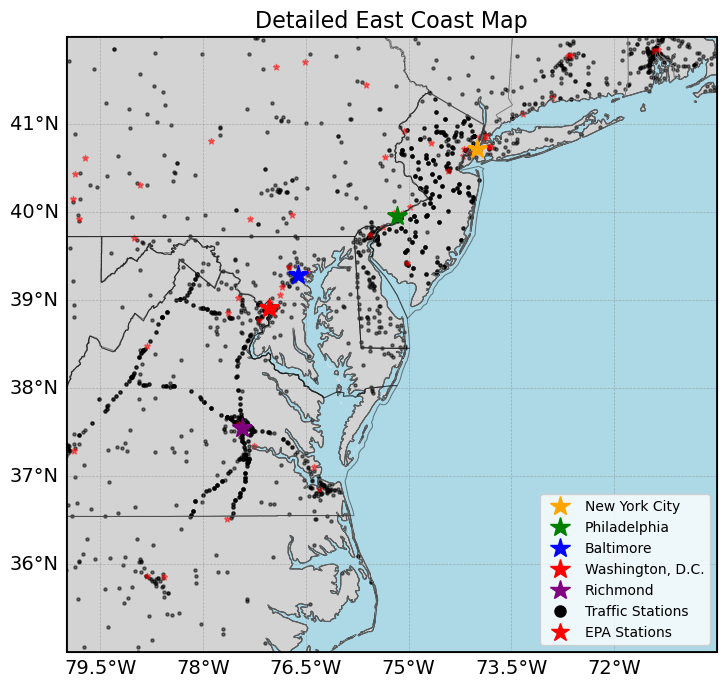

In [206]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot Maryland boundary
us_states.geometry.boundary.plot(ax=ax, color='black', linewidth=0.75, alpha=0.45, transform=ccrs.PlateCarree())
bounding_box.geometry.boundary.plot(ax=ax, color='black', linewidth=2, alpha=1, transform=ccrs.PlateCarree())

colors = ['blue', 'green', 'red', 'purple', 'orange']
for color, (idx, row) in zip(colors, major_cities_points.iterrows()):
    ax.plot(row.geometry.x, row.geometry.y, marker='*', markersize=15, color=color, alpha=1,
            transform=ccrs.PlateCarree())

from matplotlib.lines import Line2D
city_handles = [
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='orange',
              markeredgecolor='orange', label='New York City', markersize=15),

    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='green',
           markeredgecolor='green', label='Philadelphia', markersize=15),
        
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='blue',
           markeredgecolor='blue', label='Baltimore', markersize=15),
    
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='red',
           markeredgecolor='red', label='Washington, D.C.', markersize=15),
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='purple',
           markeredgecolor='purple', label='Richmond', markersize=15),

]
station_data_2020.plot(ax=ax, color='black', markersize=5, alpha=0.5, label="Traffic Stations")
station_legend = Line2D([0], [0], marker='o', linestyle='None', markerfacecolor='black',
                                          markeredgecolor='black', label='Traffic Stations', markersize=8)


unique_epa_stations.plot(ax=ax, color='red', markersize=20, alpha=0.5, label="EPA Stations", marker="*")
epa_legend = Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='red',
                                          markeredgecolor='red', label='EPA Stations', markersize=13.5)
city_handles.append(station_legend)
city_handles.append(epa_legend)
ax.legend(handles=city_handles, loc='lower right', fontsize=10, frameon=True)
plt.title("Detailed East Coast Map", fontsize=16)
plt.show()

In [207]:
city_geometries

City                                           geometry
0       Baltimore  POLYGON ((-76.7113 39.37193, -76.71129 39.3675...
1        Richmond  POLYGON ((-77.60117 37.54516, -77.60077 37.544...
2    Philadelphia  POLYGON ((-75.2803 39.975, -75.28022 39.97489,...
3   New York City  MULTIPOLYGON (((-74.25884 40.49888, -74.25814 ...
4  Washington D.C  POLYGON ((-77.11979 38.93435, -77.11977 38.934...

<b> For this particular analysis, I will only focus on FHA-Traffic and EPA-NO2 stations in New York City Area.

In [208]:
nyc_gdf = city_geometries[city_geometries["City"] == "New York City"]

# selecting only the unique EPA stations that fall inside NYC Polygon
epa_sensor_within_nyc = gpd.sjoin(unique_epa_stations, nyc_gdf, predicate="within")

try:
    epa_sensor_within_nyc.drop(columns=["index_right"], inplace=True)
except:
    pass

In [209]:
epa_sensor_within_nyc

Site Num   Latitude  Longitude                    geometry           City
27       110  40.816002 -73.902000      POINT (-73.902 40.816)  New York City
29       133  40.867901 -73.878090   POINT (-73.87809 40.8679)  New York City
30       125  40.739265 -73.817696   POINT (-73.8177 40.73927)  New York City
32       124  40.736141 -73.821533  POINT (-73.82153 40.73614)  New York City

In [211]:
# getting closest FHA station to the EPA stations within NYC using geopandas
closest_FHA_station_near_EPA_Station = gpd.sjoin_nearest(epa_sensor_within_nyc, station_data_2020[["Station_Id", "geometry", "Latitude", "Longitude"]], \
                                                         how='left', distance_col='distance_meters')

In [215]:
closest_FHA_station_near_EPA_Station["geometry"] = gpd.points_from_xy(closest_FHA_station_near_EPA_Station["Longitude_right"], \
                                closest_FHA_station_near_EPA_Station["Latitude_right"])

In [218]:
closest_FHA_station_near_EPA_Station = gpd.GeoDataFrame(closest_FHA_station_near_EPA_Station, geometry="geometry", crs="EPSG:4326")

try:
    closest_FHA_station_near_EPA_Station.drop(columns=["index_right"], inplace=True)
except:
    pass

In [220]:
closest_FHA_station_near_EPA_Station

Site Num  Latitude_left  Longitude_left                    geometry  \
27       110      40.816002      -73.902000   POINT (-73.9063 40.84513)   
29       133      40.867901      -73.878090  POINT (-73.88471 40.89246)   
30       125      40.739265      -73.817696  POINT (-73.82038 40.74045)   
32       124      40.736141      -73.821533  POINT (-73.82038 40.74045)   

             City Station_Id  Latitude_right  Longitude_right  distance_meters  
27  New York City     000199       40.845130        -73.90630         0.029444  
29  New York City     000180       40.892460        -73.88471         0.025436  
30  New York City     000580       40.740446        -73.82038         0.002933  
32  New York City     000580       40.740446        -73.82038         0.004457

In [221]:
epa_sensor_within_nyc

Site Num   Latitude  Longitude                    geometry           City
27       110  40.816002 -73.902000      POINT (-73.902 40.816)  New York City
29       133  40.867901 -73.878090   POINT (-73.87809 40.8679)  New York City
30       125  40.739265 -73.817696   POINT (-73.8177 40.73927)  New York City
32       124  40.736141 -73.821533  POINT (-73.82153 40.73614)  New York City

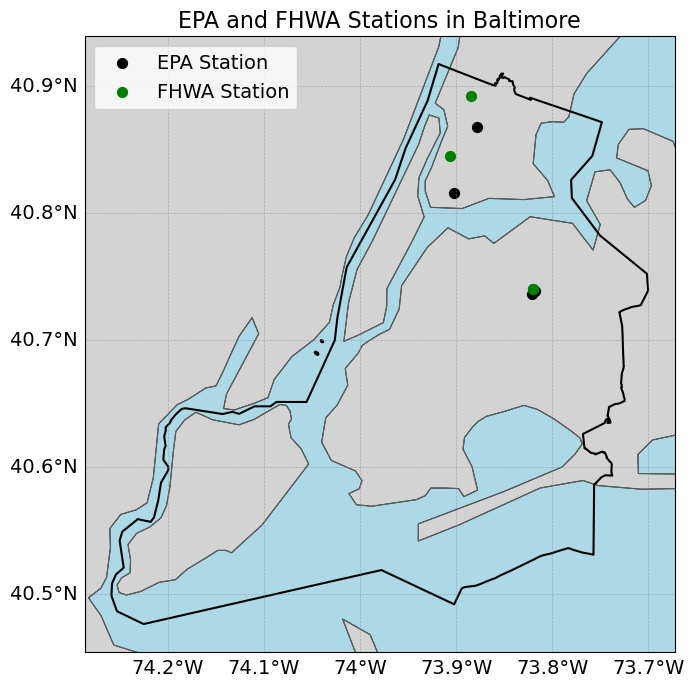

In [222]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

nyc_gdf.geometry.boundary.plot(ax=ax, color='black')
epa_sensor_within_nyc.plot(ax=ax, color="black", markersize=50, alpha=1, label="EPA Station")
closest_FHA_station_near_EPA_Station.plot(ax=ax, color="green", markersize=50, alpha=1, label="FHWA Station")    
ax.set_title("EPA and FHWA Stations in Baltimore", fontsize=16)
ax.legend(loc="upper left")

In [224]:
unique_FHA_stations = closest_FHA_station_near_EPA_Station["Station_Id"].map(int).map(str)

In [227]:
traffic_df_2019.show(5)

+----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|Station_Id|year|month|day|day_of_week|hour_00|hour_01|hour_02|hour_03|hour_04|hour_05|hour_06|hour_07|hour_08|hour_09|hour_10|hour_11|hour_12|hour_13|hour_14|hour_15|hour_16|hour_17|hour_18|hour_19|hour_20|hour_21|hour_22|hour_23|
+----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      9007|2019|    1|  2|          4|  235.0|  164.0|  128.0|  144.0|  222.0|  391.0|  731.0|  910.0|  878.0|  828.0|  904.0|  894.0|  950.0| 1078.0| 1202.0| 1330.0| 1363.0| 1251.0|  876.0|  632.0|  562.0|  464.0|  344.0|  350.0|
|      9007|2019|    1|  3|          5|  226.0|  167.0|  144.0|  141.0| 

In [228]:
from pyspark.sql.functions import concat_ws, to_date

In [300]:
traffic_df_2019_within_NY = traffic_df_2019.filter(col("Station_Id").isin(list(unique_FHA_stations)))

# concat year-month-day and make it date object
traffic_df_2019_within_NY = traffic_df_2019_within_NY.withColumn("date", to_date(concat_ws("-", col("year"), col("month"), col("day")), "yyyy-M-d"))

In [301]:
traffic_df_2019_within_NY.show(5)

+----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+----------+
|Station_Id|year|month|day|day_of_week|hour_00|hour_01|hour_02|hour_03|hour_04|hour_05|hour_06|hour_07|hour_08|hour_09|hour_10|hour_11|hour_12|hour_13|hour_14|hour_15|hour_16|hour_17|hour_18|hour_19|hour_20|hour_21|hour_22|hour_23|      date|
+----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+----------+
|       180|2019|    1|  1|          3|  606.0|  932.0|  795.0|  645.0|  578.0|  450.0|  467.0|  469.0|  444.0|  450.0|  556.0|  668.0|  879.0|  900.0| 1081.0| 1210.0| 1160.0| 1095.0|  978.0|  946.0|  927.0|  745.0|  705.0|  565.0|2019-01-01|
|       180|2019|    1|  2| 

Lets do the same for other years.

In [302]:
traffic_df_2020_within_NY = traffic_df_2020.filter(col("Station_Id").isin(list(unique_FHA_stations)))


traffic_df_2020_within_NY = traffic_df_2020_within_NY.withColumnRenamed("year_record", "year")
traffic_df_2020_within_NY = traffic_df_2020_within_NY.withColumnRenamed("month_record", "month")
traffic_df_2020_within_NY = traffic_df_2020_within_NY.withColumnRenamed("day_record", "day")
traffic_df_2020_within_NY = traffic_df_2020_within_NY.withColumn("date", to_date(concat_ws("-", col("year"), col("month"), col("day")), "yyyy-M-d"))
traffic_df_2020_within_NY.show(5)

+----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+----------+
|Station_Id|year|month|day|day_of_week|hour_00|hour_01|hour_02|hour_03|hour_04|hour_05|hour_06|hour_07|hour_08|hour_09|hour_10|hour_11|hour_12|hour_13|hour_14|hour_15|hour_16|hour_17|hour_18|hour_19|hour_20|hour_21|hour_22|hour_23|      date|
+----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+----------+
|       199|2020|    4|  1|          4|  412.0|  257.0|  202.0|  210.0|  332.0|  579.0|  888.0| 1031.0| 1030.0|  885.0|  918.0|  922.0|  963.0| 1045.0| 1121.0| 1128.0| 1215.0| 1128.0|  991.0|  825.0|  805.0|  603.0|  561.0|  547.0|2020-04-01|
|       199|2020|    4|  2| 

In [304]:
traffic_df_2021_within_NY = traffic_df_2021.filter(col("Station_Id").isin(list(unique_FHA_stations)))

traffic_df_2021_within_NY = traffic_df_2021_within_NY.withColumnRenamed("year_record", "year")
traffic_df_2021_within_NY = traffic_df_2021_within_NY.withColumnRenamed("month_record", "month")
traffic_df_2021_within_NY = traffic_df_2021_within_NY.withColumnRenamed("day_record", "day")
traffic_df_2021_within_NY = traffic_df_2021_within_NY.withColumn("date", to_date(concat_ws("-", col("year"), col("month"), col("day")), "yyyy-M-d"))
traffic_df_2021_within_NY.show(5)

+-----------+----------+--------+----------+----------+-----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------+----------+
|record_type|state_code|f_system|Station_Id|travel_dir|travel_lane|year|month|day|day_of_week|hour_00|hour_01|hour_02|hour_03|hour_04|hour_05|hour_06|hour_07|hour_08|hour_09|hour_10|hour_11|hour_12|hour_13|hour_14|hour_15|hour_16|hour_17|hour_18|hour_19|hour_20|hour_21|hour_22|hour_23|restrictions|      date|
+-----------+----------+--------+----------+----------+-----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------+----------+
|          3|        36|      1U|       180|         1|          1|

In [244]:
epa_2020_within_NY = epa_2020_spark_df.filter(col("Site Num").isin(list(epa_sensor_within_nyc["Site Num"].unique())))
epa_2019_within_NY = epa_2019_spark_df.filter(col("Site Num").isin(list(epa_sensor_within_nyc["Site Num"].unique())))
epa_2021_within_NY = epa_2021_spark_df.filter(col("Site Num").isin(list(epa_sensor_within_nyc["Site Num"].unique())))

In [245]:
epa_2020_within_NY.show(5)

+--------+----------+-------------------+----+----------+-------------------+--------+---------+------------------+
|Site Num|Date Local|         Time Local|Hour|  Date GMT|           Time GMT|Latitude|Longitude|Sample Measurement|
+--------+----------+-------------------+----+----------+-------------------+--------+---------+------------------+
|     110|2020-01-01|2025-04-21 00:00:00|   0|2020-01-01|2025-04-21 05:00:00|  40.816|  -73.902|               9.7|
|     110|2020-01-01|2025-04-21 01:00:00|   1|2020-01-01|2025-04-21 06:00:00|  40.816|  -73.902|              10.1|
|     110|2020-01-01|2025-04-21 02:00:00|   2|2020-01-01|2025-04-21 07:00:00|  40.816|  -73.902|              10.0|
|     110|2020-01-01|2025-04-21 03:00:00|   3|2020-01-01|2025-04-21 08:00:00|  40.816|  -73.902|               9.8|
|     110|2020-01-01|2025-04-21 04:00:00|   4|2020-01-01|2025-04-21 09:00:00|  40.816|  -73.902|               9.7|
+--------+----------+-------------------+----+----------+---------------

Now, this is epa no2 data for 2020 for NYC only.

Let's get Year-Month-Day-Hour average NO2 for each year.

In [248]:
from pyspark.sql.functions import year, avg

In [252]:
def get_hourly_average_EPA_NO2(spark_dataframe: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
    '''
    Given a spark dataframe, return the hourly average for the given year.
    '''
    # extractting year month and day from the date column
    spark_dataframe = spark_dataframe.withColumn("year", year("Date Local"))
    spark_dataframe = spark_dataframe.withColumn("month", month("Date Local")) 
    spark_dataframe = spark_dataframe.withColumn("day", dayofmonth("Date Local"))
    epa_hourly_average = epa_2020_within_NY.groupBy("year", "month", "day", "Hour").agg(avg("Sample Measurement").alias("Sample Measurement"))\
        .orderBy("year", "month", "day", "Hour")
    return epa_hourly_average

In [253]:
epa_hourly_average_2020 = get_hourly_average_EPA_NO2(epa_2020_within_NY)
epa_hourly_average_2019 = get_hourly_average_EPA_NO2(epa_2019_within_NY)
epa_hourly_average_2021 = get_hourly_average_EPA_NO2(epa_2021_within_NY)

In [254]:
epa_hourly_average_2021.show()

+----+-----+---+----+------------------+
|year|month|day|Hour|Sample Measurement|
+----+-----+---+----+------------------+
|2020|    1|  1|   0| 8.174999999999999|
|2020|    1|  1|   1|             8.525|
|2020|    1|  1|   2|               8.6|
|2020|    1|  1|   3| 8.774999999999999|
|2020|    1|  1|   4|              7.75|
|2020|    1|  1|   5|               8.5|
|2020|    1|  1|   6| 9.774999999999999|
|2020|    1|  1|   7| 8.725000000000001|
|2020|    1|  1|   8|             7.275|
|2020|    1|  1|   9|             6.825|
|2020|    1|  1|  10| 5.925000000000001|
|2020|    1|  1|  11|              5.15|
|2020|    1|  1|  12|             5.775|
|2020|    1|  1|  13| 6.800000000000001|
|2020|    1|  1|  14|             7.025|
|2020|    1|  1|  15| 8.524999999999999|
|2020|    1|  1|  16| 9.774999999999999|
|2020|    1|  1|  17|             10.75|
|2020|    1|  1|  18|            10.675|
|2020|    1|  1|  19|12.774999999999999|
+----+-----+---+----+------------------+
only showing top

Now that we have hourly/daily average EPA NO2 for our selected region, let get traffic frequency statistics as well.

In [256]:
traffic_df_2019_within_NY.show(5)

+----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+----------+
|Station_Id|year|month|day|day_of_week|hour_00|hour_01|hour_02|hour_03|hour_04|hour_05|hour_06|hour_07|hour_08|hour_09|hour_10|hour_11|hour_12|hour_13|hour_14|hour_15|hour_16|hour_17|hour_18|hour_19|hour_20|hour_21|hour_22|hour_23|      date|
+----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+----------+
|       180|2019|    1|  1|          3|  606.0|  932.0|  795.0|  645.0|  578.0|  450.0|  467.0|  469.0|  444.0|  450.0|  556.0|  668.0|  879.0|  900.0| 1081.0| 1210.0| 1160.0| 1095.0|  978.0|  946.0|  927.0|  745.0|  705.0|  565.0|2019-01-01|
|       180|2019|    1|  2| 

Since all the hours are in columns and wide format, lets melt it to bring in to row format such that each hour and value will be in rows inside two new columns.

In [270]:
from pyspark.sql.functions import regexp_extract

In [271]:
def melt_spark_dataframe(spark_dataframe: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
    '''
    Given a spark dataframe, this function will melt the dataframe to get the hourly average for each day from wide format to row format.
    '''
    try:
        melted_dataframe = spark_dataframe.melt(
                ids= ['Station_Id', 'year', 'month', 'day', 'day_of_week', 'date'],
                values= [f'hour_{h:02d}' for h in range(24)],
                variableColumnName='hour_str',
                valueColumnName='traffic_count'
        )
        
        # extract hour from hour_str: hour_00 = 0
        melted_dataframe = melted_dataframe.withColumn('Hour', regexp_extract('hour_str', r'hour_(\d+)', 1).cast('int'))
        return melted_dataframe
    except Exception as e:
        print(f"Error in melting dataframe: {e}")
        return None

In [272]:
traffic_long_2019 = melt_spark_dataframe(traffic_df_2019_within_NY)

In [273]:
traffic_long_2019.show(5)

+----------+----+-----+---+-----------+----------+--------+-------------+----+
|Station_Id|year|month|day|day_of_week|      date|hour_str|traffic_count|Hour|
+----------+----+-----+---+-----------+----------+--------+-------------+----+
|       180|2019|    1|  1|          3|2019-01-01| hour_00|        606.0|   0|
|       180|2019|    1|  1|          3|2019-01-01| hour_01|        932.0|   1|
|       180|2019|    1|  1|          3|2019-01-01| hour_02|        795.0|   2|
|       180|2019|    1|  1|          3|2019-01-01| hour_03|        645.0|   3|
|       180|2019|    1|  1|          3|2019-01-01| hour_04|        578.0|   4|
+----------+----+-----+---+-----------+----------+--------+-------------+----+
only showing top 5 rows



Lets melt the dataframes for next 2 years as well.

In [274]:
traffic_long_2020 = melt_spark_dataframe(traffic_df_2020_within_NY)
traffic_long_2020.show(5)

+----------+----+-----+---+-----------+----------+--------+-------------+----+
|Station_Id|year|month|day|day_of_week|      date|hour_str|traffic_count|Hour|
+----------+----+-----+---+-----------+----------+--------+-------------+----+
|       199|2020|    4|  1|          4|2020-04-01| hour_00|        412.0|   0|
|       199|2020|    4|  1|          4|2020-04-01| hour_01|        257.0|   1|
|       199|2020|    4|  1|          4|2020-04-01| hour_02|        202.0|   2|
|       199|2020|    4|  1|          4|2020-04-01| hour_03|        210.0|   3|
|       199|2020|    4|  1|          4|2020-04-01| hour_04|        332.0|   4|
+----------+----+-----+---+-----------+----------+--------+-------------+----+
only showing top 5 rows



In [305]:
traffic_df_2021_within_NY.show(5)

+-----------+----------+--------+----------+----------+-----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------+----------+
|record_type|state_code|f_system|Station_Id|travel_dir|travel_lane|year|month|day|day_of_week|hour_00|hour_01|hour_02|hour_03|hour_04|hour_05|hour_06|hour_07|hour_08|hour_09|hour_10|hour_11|hour_12|hour_13|hour_14|hour_15|hour_16|hour_17|hour_18|hour_19|hour_20|hour_21|hour_22|hour_23|restrictions|      date|
+-----------+----------+--------+----------+----------+-----------+----+-----+---+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------+----------+
|          3|        36|      1U|       180|         1|          1|

In [306]:
traffic_long_2021 = melt_spark_dataframe(traffic_df_2021_within_NY)
traffic_long_2021.show(5)

+----------+----+-----+---+-----------+----------+--------+-------------+----+
|Station_Id|year|month|day|day_of_week|      date|hour_str|traffic_count|Hour|
+----------+----+-----+---+-----------+----------+--------+-------------+----+
|       180|2021|    4|  4|          1|2021-04-04| hour_00|          713|   0|
|       180|2021|    4|  4|          1|2021-04-04| hour_01|          490|   1|
|       180|2021|    4|  4|          1|2021-04-04| hour_02|          318|   2|
|       180|2021|    4|  4|          1|2021-04-04| hour_03|          238|   3|
|       180|2021|    4|  4|          1|2021-04-04| hour_04|          208|   4|
+----------+----+-----+---+-----------+----------+--------+-------------+----+
only showing top 5 rows



In [307]:
# concatenate all traffic melted dataframes together to create a lineplot later on
traffic_long = traffic_long_2019.union(traffic_long_2020).union(traffic_long_2021)

In [309]:
# concatenate all epa dataframes together to craeate a line plot later on
epa_no2 = epa_hourly_average_2019.union(epa_hourly_average_2020).union(epa_hourly_average_2021)

In [104]:
traffic = traffic_long.groupby("Hour")["traffic_count"].mean().reset_index()

In [105]:
no2 = epa_no2.groupby("Hour")["Sample Measurement"].mean().reset_index()

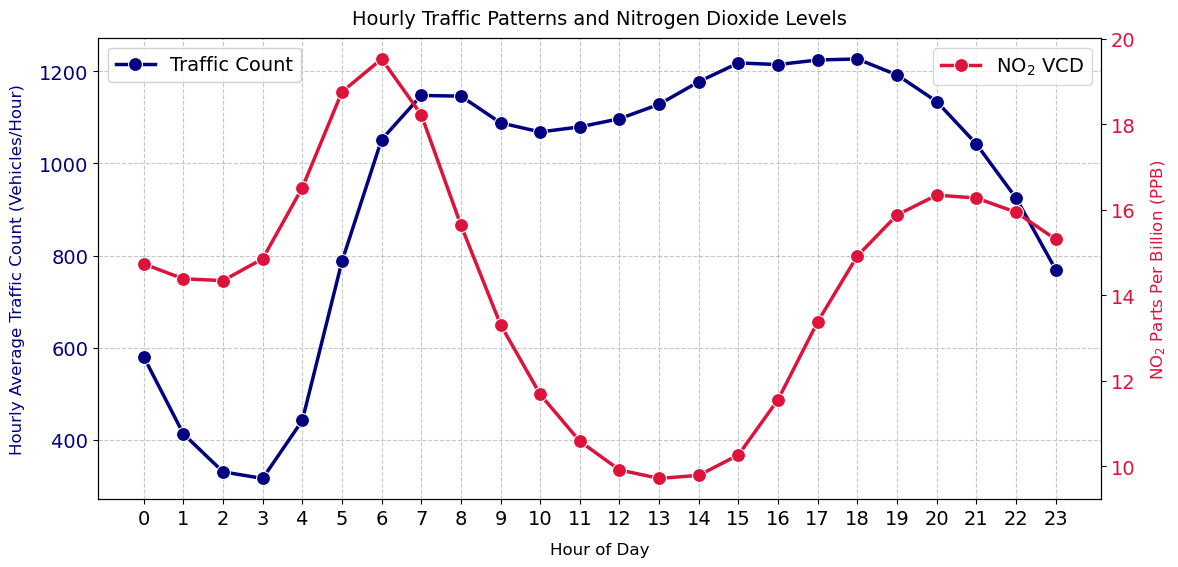

In [106]:
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(data=traffic, x="Hour", y="traffic_count", label="Traffic Count", color="navy", linewidth=2.5, ax=ax1, marker="o", markersize=10)
ax1.set_ylabel("Hourly Average Traffic Count (Vehicles/Hour)", color="navy", fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor="navy")
ax1.set_xlabel("Hour of Day", fontsize=12, labelpad=10)
ax1.set_xticks(range(0, 24)) 
ax1.grid(True, linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
sns.lineplot(data=no2, x="Hour", y="Sample Measurement", label="NO$_2$ VCD", color="crimson", linewidth=2.5, ax=ax2, marker="o", markersize=10)
ax2.set_ylabel("NO$_2$ Parts Per Billion (PPB)", color="crimson", fontsize=12, labelpad=10)
ax2.tick_params(axis='y', labelcolor="crimson")

plt.title("Hourly Traffic Patterns and Nitrogen Dioxide Levels", fontsize=14, pad=10, fontweight='normal')

lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1 , labels1, loc='upper left', frameon=True, framealpha=0.9)

# ax1.tick_params(labelsize=20)

ax2.ticklabel_format(style='scientific', axis = 'y') 
t = ax.yaxis.get_offset_text()
t.set_size(20)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  
plt.show()

In [107]:
epa_no2["year_month"] = epa_no2["year"].astype(str) + "-" + epa_no2["month"].astype(str).str.zfill(2)
EPA_year_month_avg = epa_no2.groupby("year_month")["Sample Measurement"].mean().reset_index()
EPA_year_month_avg.rename(columns={"Sample Measurement": "Average_NO2"}, inplace=True)
EPA_year_month_avg["year_month"] = pd.to_datetime(EPA_year_month_avg["year_month"])

In [108]:
traffic_long["year-month"] = traffic_long["year"].astype(str) + "-" + traffic_long["month"].astype(str).str.zfill(2)
Traffic_year_month_avg = traffic_long.groupby("year-month")["traffic_count"].mean().reset_index()
Traffic_year_month_avg.rename(columns={"traffic_count": "Average_Traffic_Count"}, inplace=True)
Traffic_year_month_avg["year-month"] = pd.to_datetime(Traffic_year_month_avg["year-month"])

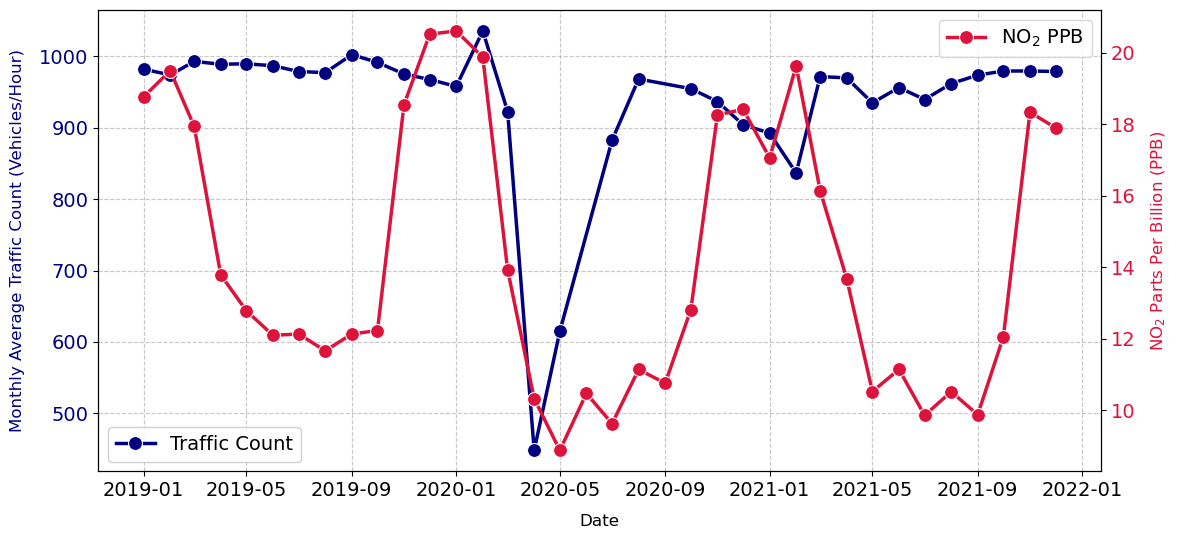

In [109]:
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(data=Traffic_year_month_avg, x="year-month", y="Average_Traffic_Count", label="Traffic Count", color="navy", linewidth=2.5, ax=ax1, marker="o", markersize=10)
ax1.set_ylabel("Monthly Average Traffic Count (Vehicles/Hour)", color="navy", fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor="navy")
ax1.set_xlabel("Date", fontsize=12, labelpad=10)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.ticklabel_format(style='scientific', axis = 'y') 
t = ax1.yaxis.get_offset_text()
t.set_size(20)

ax2 = ax1.twinx()
sns.lineplot(data=EPA_year_month_avg, x="year_month", y="Average_NO2", label="NO$_2$ PPB", color="crimson", linewidth=2.5, ax=ax2, marker="o", markersize=10)
ax2.set_ylabel("NO$_2$ Parts Per Billion (PPB)", color="crimson", fontsize=12, labelpad=10)
ax2.tick_params(axis='y', labelcolor="crimson")


lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1 , labels1, loc='lower left', frameon=True, framealpha=0.9)

ax2.ticklabel_format(style='scientific', axis = 'y') 
t = ax2.yaxis.get_offset_text()
t.set_size(20)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  
plt.show()

In [110]:
traffic_long1 = traffic_long.groupby(["year", "month", "day", "Hour"])["traffic_count"].mean().reset_index()

In [111]:
joined = epa_no2.merge(traffic_long1, on=["year", "month", "day", "Hour"], how="inner")
joined

year  month  day  Hour  Sample Measurement year_month  traffic_count
0      2019      1    1     0              18.700    2019-01     679.416667
1      2019      1    1     1              25.250    2019-01     959.083333
2      2019      1    1     2              30.275    2019-01     895.750000
3      2019      1    1     3              20.475    2019-01     721.666667
4      2019      1    1     4              15.750    2019-01     627.833333
...     ...    ...  ...   ...                 ...        ...            ...
24668  2021     12   31    19              25.700    2021-12    1108.583333
24669  2021     12   31    20              24.700    2021-12    1022.833333
24670  2021     12   31    21              25.000    2021-12     885.000000
24671  2021     12   31    22              24.700    2021-12     790.750000
24672  2021     12   31    23              21.500    2021-12     627.583333

[24673 rows x 7 columns]

In [112]:
joined["date"] = joined["year"].astype(str) + "-" + joined["month"].astype(str).str.zfill(2) + "-" + joined["day"].astype(str).str.zfill(2)
joined["date"] = pd.to_datetime(joined["date"])
joined["DayName"] = joined["date"].dt.day_name()
no_weekends_no2 = joined[joined["DayName"].isin(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])]

In [113]:
traffic_long["Date"] = traffic_long["year"].astype(str) + "-" + traffic_long["month"].astype(str).str.zfill(2) + "-" + traffic_long["day"].astype(str).str.zfill(2)
traffic_long["Date"] = pd.to_datetime(traffic_long["Date"])
traffic_long["DayName"] = traffic_long["Date"].dt.day_name()
no_weekends_traffic = traffic_long[traffic_long["DayName"].isin(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])]

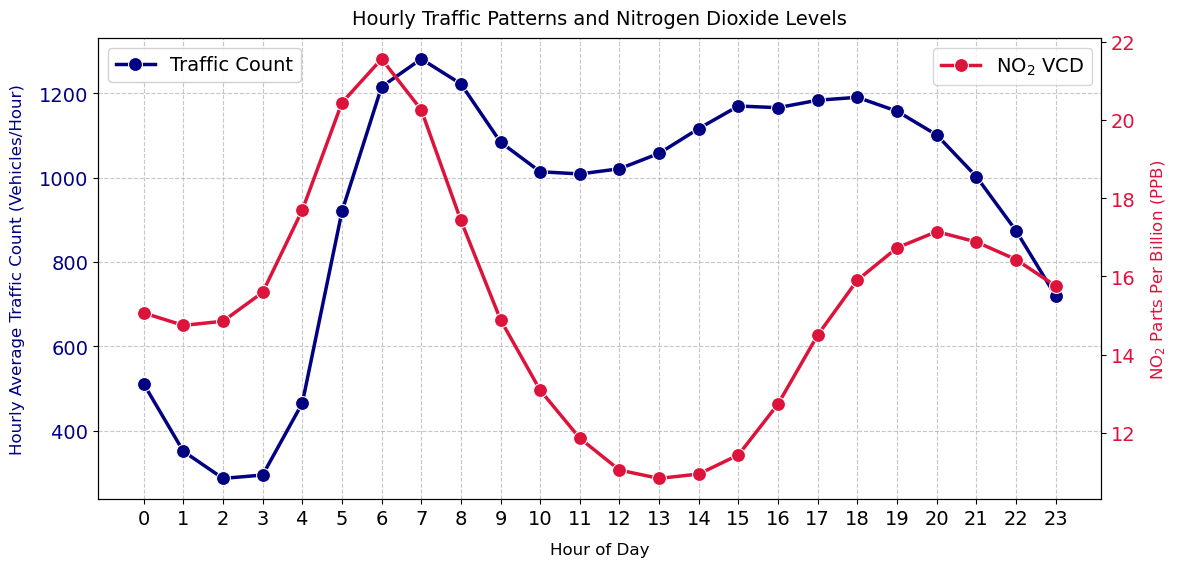

In [114]:
fig, ax1 = plt.subplots(figsize=(12, 6))

traffic = no_weekends_traffic.groupby("Hour")["traffic_count"].mean().reset_index()
no2 = no_weekends_no2.groupby("Hour")["Sample Measurement"].mean().reset_index()

sns.lineplot(data=traffic, x="Hour", y="traffic_count", label="Traffic Count", color="navy", linewidth=2.5, ax=ax1, marker="o", markersize=10)
ax1.set_ylabel("Hourly Average Traffic Count (Vehicles/Hour)", color="navy", fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor="navy")
ax1.set_xlabel("Hour of Day", fontsize=12, labelpad=10)
ax1.set_xticks(range(0, 24)) 
ax1.grid(True, linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
sns.lineplot(data=no2, x="Hour", y="Sample Measurement", label="NO$_2$ VCD", color="crimson", linewidth=2.5, ax=ax2, marker="o", markersize=10)
ax2.set_ylabel("NO$_2$ Parts Per Billion (PPB)", color="crimson", fontsize=12, labelpad=10)
ax2.tick_params(axis='y', labelcolor="crimson")

plt.title("Hourly Traffic Patterns and Nitrogen Dioxide Levels", fontsize=14, pad=10, fontweight='normal')

lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1 , labels1, loc='upper left', frameon=True, framealpha=0.9)

# ax1.tick_params(labelsize=20)

ax2.ticklabel_format(style='scientific', axis = 'y') 
t = ax.yaxis.get_offset_text()
t.set_size(20)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  
plt.show()

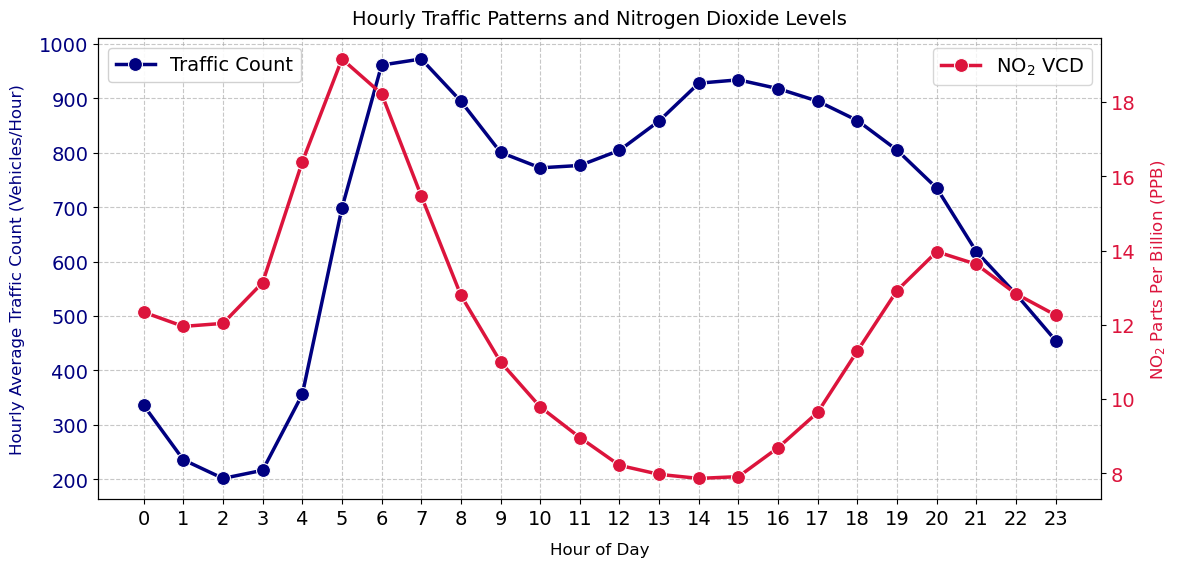

In [115]:
covidLockdown_2020_traffic = no_weekends_traffic[(no_weekends_traffic.year == 2020) & (no_weekends_traffic.month.isin([3, 4, 5]))].copy()
covidLockdown_2020_no2 = no_weekends_no2[(no_weekends_no2.year == 2020) & (no_weekends_no2.month.isin([3, 4, 5]))].copy()

fig, ax1 = plt.subplots(figsize=(12, 6))

traffic = covidLockdown_2020_traffic.groupby("Hour")["traffic_count"].mean().reset_index()
no2 = covidLockdown_2020_no2.groupby("Hour")["Sample Measurement"].mean().reset_index()

sns.lineplot(data=traffic, x="Hour", y="traffic_count", label="Traffic Count", color="navy", linewidth=2.5, ax=ax1, marker="o", markersize=10)
ax1.set_ylabel("Hourly Average Traffic Count (Vehicles/Hour)", color="navy", fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor="navy")
ax1.set_xlabel("Hour of Day", fontsize=12, labelpad=10)
ax1.set_xticks(range(0, 24)) 
ax1.grid(True, linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
sns.lineplot(data=no2, x="Hour", y="Sample Measurement", label="NO$_2$ VCD", color="crimson", linewidth=2.5, ax=ax2, marker="o", markersize=10)
ax2.set_ylabel("NO$_2$ Parts Per Billion (PPB)", color="crimson", fontsize=12, labelpad=10)
ax2.tick_params(axis='y', labelcolor="crimson")

plt.title("Hourly Traffic Patterns and Nitrogen Dioxide Levels", fontsize=14, pad=10, fontweight='normal')

lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1 , labels1, loc='upper left', frameon=True, framealpha=0.9)

# ax1.tick_params(labelsize=20)

ax2.ticklabel_format(style='scientific', axis = 'y') 
t = ax.yaxis.get_offset_text()
t.set_size(20)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  
plt.show()

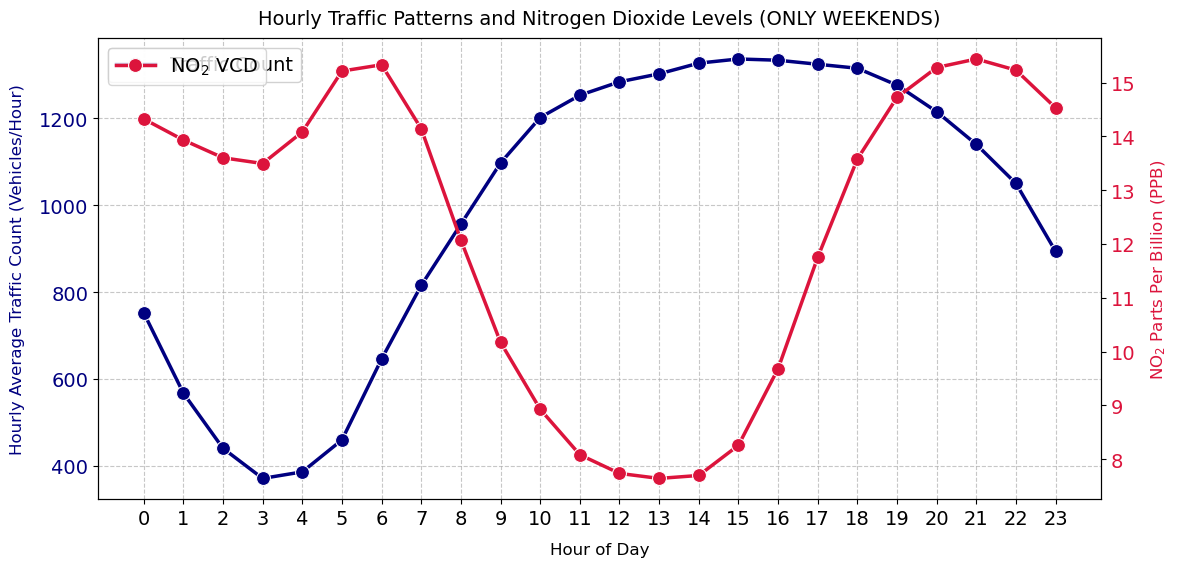

In [116]:
fig, ax1 = plt.subplots(figsize=(12, 6))


weekends = joined[joined["DayName"].isin(["Saturday", "Sunday"])]
weekends_traffic = traffic_long[traffic_long["DayName"].isin(["Saturday", "Sunday"])]

traffic = weekends_traffic.groupby("Hour")["traffic_count"].mean().reset_index()
no2 = weekends.groupby("Hour")["Sample Measurement"].mean().reset_index()

sns.lineplot(data=traffic, x="Hour", y="traffic_count", label="Traffic Count", color="navy", linewidth=2.5, ax=ax1, marker="o", markersize=10)
ax1.set_ylabel("Hourly Average Traffic Count (Vehicles/Hour)", color="navy", fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor="navy")
ax1.set_xlabel("Hour of Day", fontsize=12, labelpad=10)
ax1.set_xticks(range(0, 24)) 
ax1.grid(True, linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
sns.lineplot(data=no2, x="Hour", y="Sample Measurement", label="NO$_2$ VCD", color="crimson", linewidth=2.5, ax=ax2, marker="o", markersize=10)
ax2.set_ylabel("NO$_2$ Parts Per Billion (PPB)", color="crimson", fontsize=12, labelpad=10)
ax2.tick_params(axis='y', labelcolor="crimson")

plt.title("Hourly Traffic Patterns and Nitrogen Dioxide Levels (ONLY WEEKENDS)", fontsize=14, pad=10, fontweight='normal')

lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1 , labels1, loc='upper left', frameon=True, framealpha=0.9)

# ax1.tick_params(labelsize=20)

ax2.ticklabel_format(style='scientific', axis = 'y') 
t = ax.yaxis.get_offset_text()
t.set_size(20)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  
plt.show()

In [117]:
from scipy.stats import pearsonr

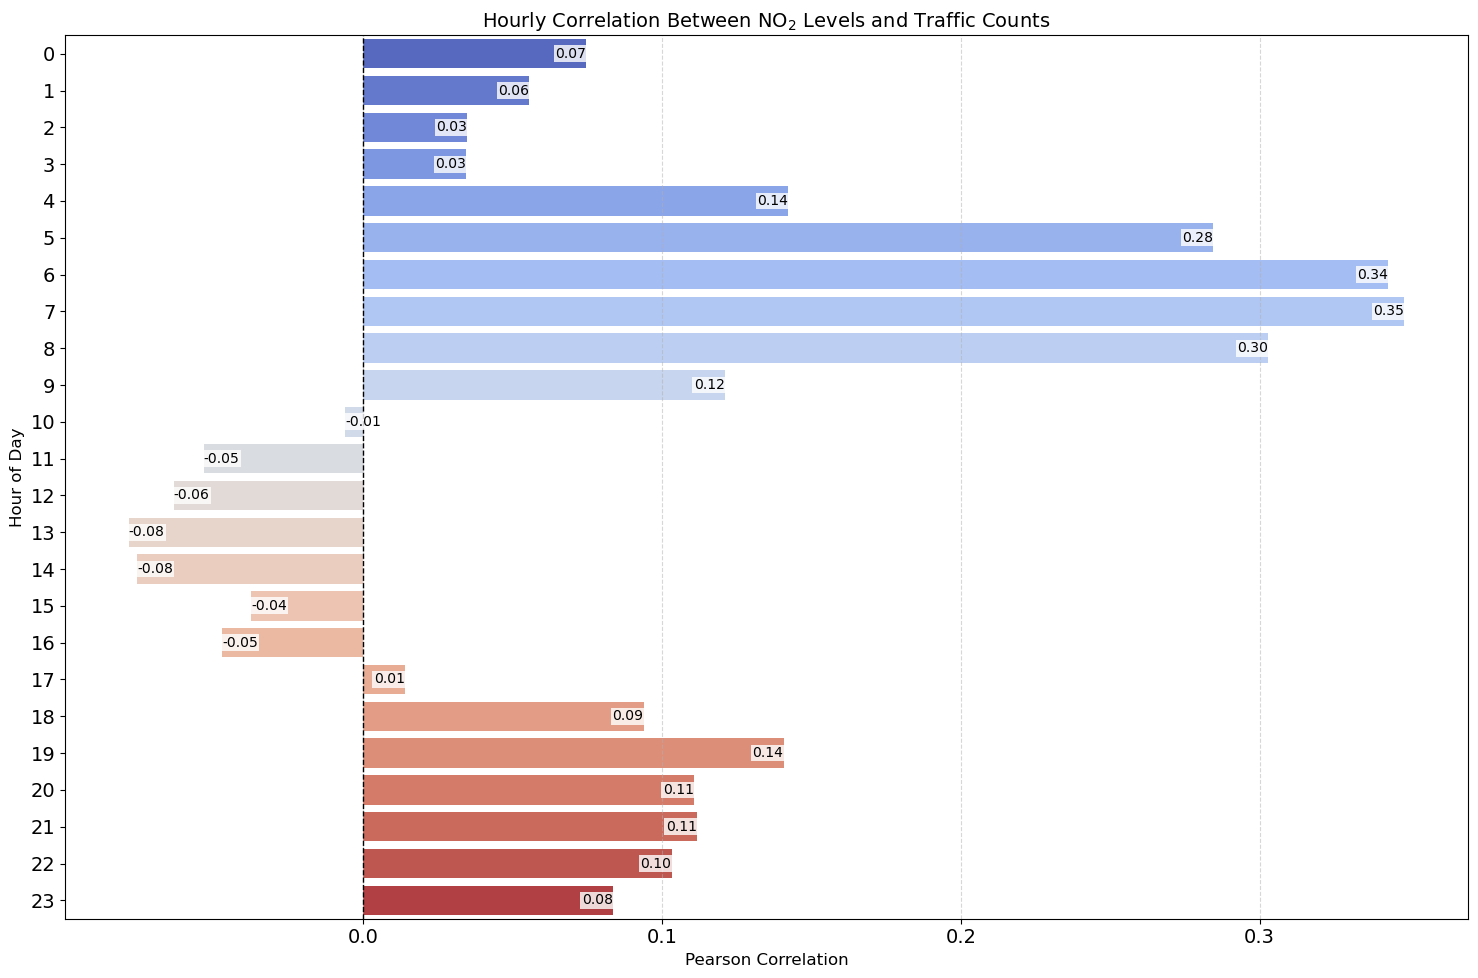

In [118]:
hourly_correlations = []
for hour in range(24):
    a = joined[joined["Hour"] == hour].copy()
    correlation = a[["Sample Measurement", "traffic_count"]].corr(method="pearson").iloc[0, 1]
    hourly_correlations.append(correlation)

plt.figure(figsize=(15, 10))
ax = sns.barplot(x=hourly_correlations, y=list(range(24)), palette="coolwarm", orient="h")

for i, correlation in enumerate(hourly_correlations):
    ax.text(correlation, i, f"{correlation:.2f}", va='center', ha='left' if correlation < 0 else 'right', 
            color="black", fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))

plt.xlabel("Pearson Correlation", fontsize=12)
plt.ylabel("Hour of Day", fontsize=12)
plt.title("Hourly Correlation Between NO$_2$ Levels and Traffic Counts", fontsize=14)
plt.axvline(0, color="black", linestyle="--", linewidth=1) 
plt.grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

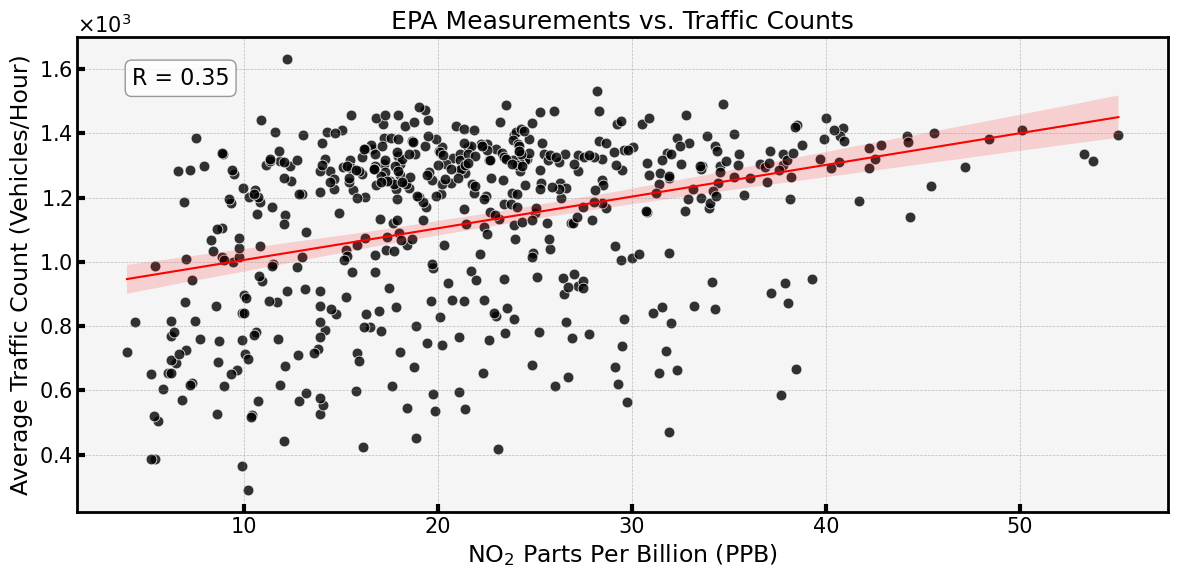

In [119]:
hour_combination = [6, 7, 8]
month_combination = [10, 11, 12, 1, 2, 3]
year_combination = [2020, 2021, 2019]

joined1 = joined[(joined.Hour.isin(hour_combination)) & (joined.month.isin(month_combination)) & (joined.year.isin(year_combination))].copy()
joined1 = joined1.groupby(["year", "month", "day"])[["Sample Measurement", "traffic_count"]].mean().reset_index()
# joined1 = joined1[joined1.traffic_count.between(0.25e3, 1.75e3)]

corr, __annotations__ = pearsonr(joined1["Sample Measurement"], joined1["traffic_count"])

fig, ax = plt.subplots(figsize=(12, 6))

scatter = sns.scatterplot(ax=ax, data=joined1, x="Sample Measurement", y="traffic_count", color="black", alpha=0.8, s=60)

ax.text(0.05, 0.9, f'R = {corr:.2f}',
    transform=ax.transAxes,
    fontsize=16,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round')
)

ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_facecolor('whitesmoke')  


sns.regplot(
    data=joined1,
    x="Sample Measurement",
    y="traffic_count",
    scatter=False,
    color='red',
    line_kws={'linewidth': 1.5},
    ax=ax
)

for spine in ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(0.8)

ax.tick_params(labelsize=15)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['left'].set_lw(2) 
ax.tick_params(which='both', width=3)
ax.tick_params(which='major', length=6)
ax.grid(True, linestyle="--", alpha=0.5)
ax.tick_params(which='minor', length=6)
ax.tick_params(which = 'both', direction = 'in')
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='scientific', axis = 'y') 
t = ax.yaxis.get_offset_text()
t.set_size(15)
ax.set_xlabel("NO$_2$ Parts Per Billion (PPB)", fontsize=17)
ax.set_ylabel("Average Traffic Count (Vehicles/Hour)", fontsize=17)
ax.set_title("EPA Measurements vs. Traffic Counts", fontsize=18)

plt.tight_layout()
plt.show()

## 3. Isolated FHA Station Traffic Frequency vs EPA NO2

In [120]:
from shapely.geometry import box

min_lon_isolated, min_lat_isolated = -77, 41
max_lon_isolated, max_lat_isolated = -75, 42
EPA_FHA_bounding_box = box(min_lon_isolated, min_lat_isolated, max_lon_isolated, max_lat_isolated)
EPA_FHA_bounding_box = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[EPA_FHA_bounding_box])

In [121]:
# Step 1: Project to meters
gdf_meters = gpd.GeoDataFrame(index=[0], geometry =[Point((-76.5, 41.7))], crs="EPSG:4326").to_crs(epsg=32618)
gdf_meters["geometry"] = gdf_meters.buffer(15000)
gdf_with_buffer = gdf_meters[["geometry"]].set_geometry("geometry").to_crs(epsg=4326)
gdf_with_buffer

geometry
0  POLYGON ((-76.31978 41.70221, -76.32037 41.688...

In [122]:
selected_epa_station = unique_epa_stations.sjoin(gdf_with_buffer, predicate="within")
selected_epa_station

Site Num                    geometry  index_right
434572        11  POINT (-76.51273 41.70523)            0

In [123]:
selected_FHW_station = station_data_2019.sjoin(gdf_with_buffer, predicate="within")
selected_FHW_station = selected_FHW_station[["Station_Id", "geometry"]].drop_duplicates()
selected_FHW_station = selected_FHW_station.reset_index(drop=True)
selected_FHW_station

Station_Id                    geometry
0     000005  POINT (-76.44277 41.79339)

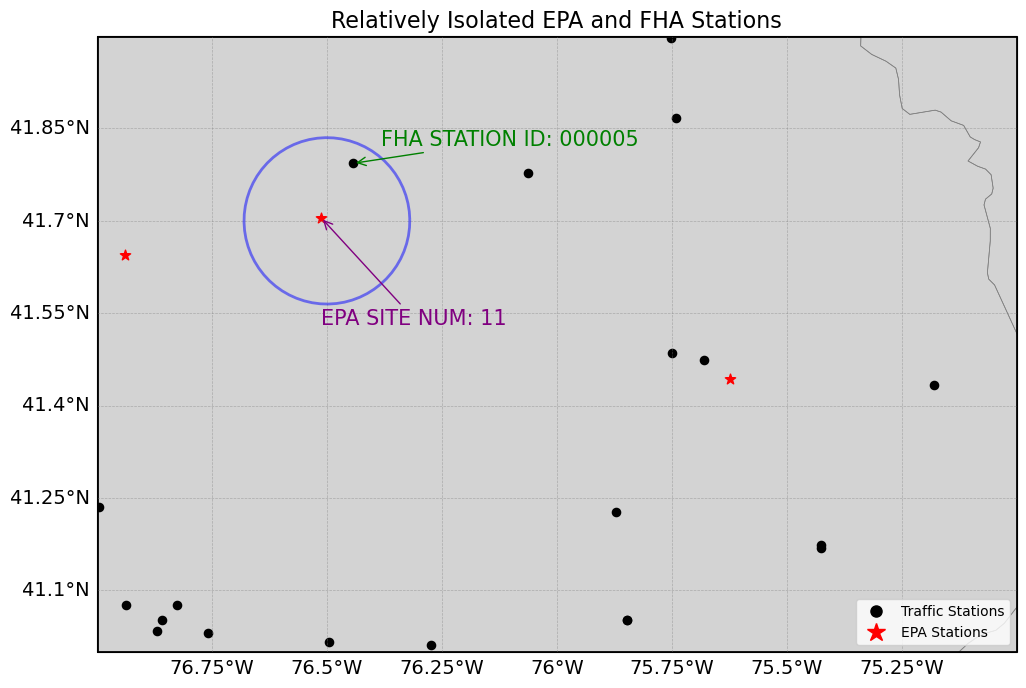

In [124]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([min_lon_isolated, max_lon_isolated, min_lat_isolated, max_lat_isolated], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot Maryland boundary
EPA_FHA_bounding_box.geometry.boundary.plot(ax=ax, color='black', linewidth=2, alpha=1, transform=ccrs.PlateCarree())

station_data_2019.plot(ax=ax, color='black', markersize=35, alpha=1, label="Traffic Stations")
station_legend = [Line2D([0], [0], marker='o', linestyle='None', markerfacecolor='black',
                                          markeredgecolor='black', label='Traffic Stations', markersize=8)]

for idx, (i, row) in enumerate(selected_FHW_station.iterrows()):
    ax.annotate(
        "FHA STATION ID: " + str(row["Station_Id"]),
        xy=(row.geometry.x, row.geometry.y),
        xytext=(20, 10),
        textcoords="offset points",
        fontsize=15,
        color='green',
        ha='left',
        va='bottom',
        arrowprops=dict(arrowstyle="->", color='green', lw=1)
    )


unique_epa_stations.plot(ax=ax, color='red', markersize=60, alpha=1, label="EPA Stations", marker="*")
epa_legend = Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='red',
                                          markeredgecolor='red', label='EPA Stations', markersize=13.5)

for idx, row in selected_epa_station.iterrows():
    ax.annotate(
        "EPA SITE NUM: " + str(row["Site Num"]),
        xy=(row.geometry.x, row.geometry.y),
        xytext=(0, -80),  # Larger offset for more separation (pixels)
        textcoords="offset points",
        fontsize=15,
        color='purple',
        ha='left',
        va='bottom',
        arrowprops=dict(arrowstyle="->", color='purple', lw=1)
    )

gdf_with_buffer.geometry.boundary.plot(ax=ax, color='blue', linewidth=2, alpha=0.5)

station_legend.append(epa_legend)
ax.legend(handles=station_legend, loc='lower right', fontsize=10, frameon=True)
plt.title("Relatively Isolated EPA and FHA Stations", fontsize=16)
plt.show()

In [125]:
selected_FHW_station

Station_Id                    geometry
0     000005  POINT (-76.44277 41.79339)

In [126]:
selected_epa_station

Site Num                    geometry  index_right
434572        11  POINT (-76.51273 41.70523)            0

In [127]:
epa_isolated = pd.concat([epa_2019, epa_2020, epa_2021], ignore_index=True)
epa_isolated = epa_isolated[epa_isolated["Site Num"] == 11].copy()
epa_isolated.reset_index(drop=True, inplace=True)

In [128]:
traffic_df_2019 = traffic_df_2019.merge(station_data_2019[["Station_Id",  "geometry"]], how="inner", on="Station_Id")
traffic_df_2020 = traffic_df_2020.merge(station_data_2020[["Station_Id",  "geometry"]], how="inner", on="Station_Id")
traffic_df_2021 = traffic_df_2021.merge(station_data_2021[["Station_Id", "geometry"]], how="inner", on="Station_Id")

In [129]:
traffic_isolated = pd.concat([traffic_df_2019, traffic_df_2020, traffic_df_2021], ignore_index=True)    
traffic_isolated = traffic_isolated.set_geometry("geometry")

In [130]:
traffic_isolated = traffic_isolated[traffic_df_2019.columns]

In [131]:
traffic_isolated = traffic_isolated.sjoin(EPA_FHA_bounding_box[["geometry"]], predicate="within")
try:
    traffic_isolated.drop(columns=["index_right"], inplace=True)
except:
    pass

In [132]:
traffic_isolated = traffic_isolated.melt(id_vars=['Station_Id', 'year', 'month', 'day'], value_vars=[f'hour_{h:02d}' for h in range(24)],
    var_name='hour_str',
    value_name='traffic_count'
)

In [133]:
traffic_isolated['Hour'] = traffic_isolated['hour_str'].str.extract(r'hour_(\d+)').astype(int)

In [134]:
epa_isolated["Date Local"] = pd.to_datetime(epa_isolated["Date Local"])
epa_isolated["year"] = epa_isolated["Date Local"].dt.year
epa_isolated["month"] = epa_isolated["Date Local"].dt.month
epa_isolated["day"] = epa_isolated["Date Local"].dt.day

In [135]:
epa_isolated = epa_isolated[["year", "month", "day", "Hour", "Sample Measurement"]]

In [136]:
traffic_isolated.head()

Station_Id  year  month  day hour_str  traffic_count  Hour
0     000005  2019      2    1  hour_00           13.0     0
1     000005  2019      2    2  hour_00           29.0     0
2     000005  2019      2    4  hour_00            0.0     0
3     000005  2019      2    5  hour_00           11.0     0
4     000005  2019      2    7  hour_00           10.0     0

In [137]:
epa_isolated.head()

year  month  day  Hour  Sample Measurement
0  2019      1    1     0                 4.7
1  2019      1    1     1                 5.9
2  2019      1    1     2                11.8
3  2019      1    1     3                 5.3
4  2019      1    1     4                 2.9

In [138]:
combined_isolated = traffic_isolated.merge(epa_isolated, how="inner", on=["year", "month", "day", "Hour"])

In [152]:
# for hour in range(24):
#     a = combined_isolated[combined_isolated["Hour"] == hour].copy()
#     for month in range(1, 13):
#         aa = a[a["month"] == month].copy()
#         correlation = aa[["Sample Measurement", "traffic_count"]].corr(method="pearson").iloc[0, 1]
#         print(f"month: {month}, Hour {hour}: {correlation:.2f}")
#     print()

In [160]:
# hour_combination = [10]
# month_combination = [1]
# year_combination = [2020, 2021, 2019]

# joined1 = combined_isolated[(combined_isolated.Hour.isin(hour_combination)) & (combined_isolated.month.isin(month_combination)) \
#                             & (combined_isolated.year.isin(year_combination))].copy()
# joined1 = joined1.groupby(["year", "month", "day"])[["Sample Measurement", "traffic_count"]].mean().reset_index()
# # joined1 = joined1.groupby(["year", "month", "day", "Hour"])[["Sample Measurement", "traffic_count"]].mean().reset_index()

In [165]:
for month in range(1, 13):
    a = combined_isolated[combined_isolated["month"] == month].copy()
    for hour in range(24):
        aa = a[a["Hour"] == hour].copy()
        correlation = aa[["Sample Measurement", "traffic_count"]].corr(method="pearson").iloc[0, 1]
        print(f"month: {month}, Hour {hour}: {correlation:.2f}")
    print()

month: 1, Hour 0: 0.27
month: 1, Hour 1: 0.43
month: 1, Hour 2: 0.20
month: 1, Hour 3: 0.27
month: 1, Hour 4: 0.32
month: 1, Hour 5: 0.23
month: 1, Hour 6: 0.29
month: 1, Hour 7: 0.28
month: 1, Hour 8: 0.21
month: 1, Hour 9: 0.38
month: 1, Hour 10: 0.41
month: 1, Hour 11: 0.44
month: 1, Hour 12: 0.30
month: 1, Hour 13: 0.41
month: 1, Hour 14: 0.09
month: 1, Hour 15: 0.09
month: 1, Hour 16: -0.01
month: 1, Hour 17: -0.01
month: 1, Hour 18: 0.01
month: 1, Hour 19: 0.00
month: 1, Hour 20: 0.01
month: 1, Hour 21: 0.13
month: 1, Hour 22: 0.23
month: 1, Hour 23: 0.34

month: 2, Hour 0: -0.26
month: 2, Hour 1: -0.22
month: 2, Hour 2: -0.31
month: 2, Hour 3: -0.33
month: 2, Hour 4: -0.33
month: 2, Hour 5: -0.25
month: 2, Hour 6: 0.06
month: 2, Hour 7: 0.15
month: 2, Hour 8: 0.21
month: 2, Hour 9: 0.18
month: 2, Hour 10: 0.20
month: 2, Hour 11: 0.28
month: 2, Hour 12: 0.29
month: 2, Hour 13: 0.30
month: 2, Hour 14: 0.29
month: 2, Hour 15: 0.30
month: 2, Hour 16: 0.30
month: 2, Hour 17: 0.28
mon

In [ ]:
hour_combination = [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 24, 23]
month_combination = [1, 2, 3, 4]
year_combination = [2020, 2021, 2019]

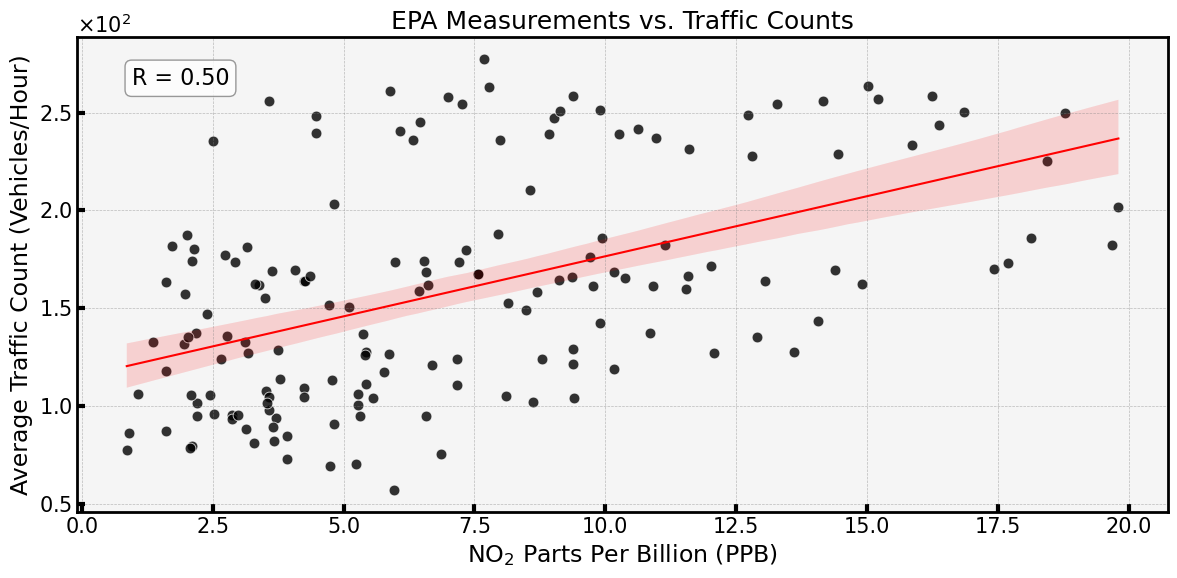

In [207]:
hour_combination = [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 24, 23]
month_combination = [1, 2, 3, 4]
year_combination = [2020, 2021, 2019]

joined1 = combined_isolated[(combined_isolated.Hour.isin(hour_combination)) & (combined_isolated.month.isin(month_combination)) \
                            & (combined_isolated.year.isin(year_combination))].copy()
joined1 = joined1.groupby(["year", "month", "day"])[["Sample Measurement", "traffic_count"]].mean().reset_index()


corr, _ = pearsonr(joined1["Sample Measurement"], joined1["traffic_count"])

fig, ax = plt.subplots(figsize=(12, 6))

scatter = sns.scatterplot(ax=ax, data=joined1, x="Sample Measurement", y="traffic_count", color="black", alpha=0.8, s=60)

ax.text(0.05, 0.9, f'R = {corr:.2f}',
    transform=ax.transAxes,
    fontsize=16,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round')
)

ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_facecolor('whitesmoke')  


sns.regplot(
    data=joined1,
    x="Sample Measurement",
    y="traffic_count",
    scatter=False,
    color='red',
    line_kws={'linewidth': 1.5},
    ax=ax
)

for spine in ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(0.8)

ax.tick_params(labelsize=15)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['left'].set_lw(2) 
ax.tick_params(which='both', width=3)
ax.tick_params(which='major', length=6)
ax.grid(True, linestyle="--", alpha=0.5)
ax.tick_params(which='minor', length=6)
ax.tick_params(which = 'both', direction = 'in')
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='scientific', axis = 'y') 
t = ax.yaxis.get_offset_text()
t.set_size(15)
ax.set_xlabel("NO$_2$ Parts Per Billion (PPB)", fontsize=17)
ax.set_ylabel("Average Traffic Count (Vehicles/Hour)", fontsize=17)
ax.set_title("EPA Measurements vs. Traffic Counts", fontsize=18)

plt.tight_layout()
plt.show()

1. Spatial 2018 to 2024 plot (OMI NO2)
2. Timeseries plot
3. Isolate EPA sensor and FHA station at around 78W and 41N